## Training Set Shifting ##

In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="6"

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import shift
from random import shuffle
import glob
import sys

from scipy.ndimage.interpolation import zoom
from scipy.misc import imsave
import argparse
import shutil

mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
mnist.train.images[1].shape

(784,)

In [19]:
def mnist_shift(data):
    mnist_list = []
    mnist_fin = []
    im_dims = [60,60]
    clutter_rate = 1
    for i in range(len(data)):
        mnist1 = np.reshape(data[i], (28,28))
        mnist1 = np.pad(mnist1, 16,'constant',constant_values = 0)
        mnist1 = shift(mnist1, (np.random.randint(-28,28),np.random.randint(-28,28)))
        
        
        for j in range(int(np.mean(im_dims) * clutter_rate)):
        # Randomly select MNIST digit
            idx = np.random.randint(len(data))
            if idx<len(data):
                fragment = data[idx].reshape(28,28)
        
        # Randomly select patch of selected digit
            px = np.random.randint(low=0, high= 28 - 8)
            py = np.random.randint(low=0, high= 28 - 8)

        # Randomly choose location to insert clutter
            x = np.random.randint(low=0, high=im_dims[1] - 8)
            y = np.random.randint(low=0, high=im_dims[0] - 8)

        # Insert digit fragment, but not on top of digits
            if np.sum(mnist1[y:(y + 8), x:(x + 8)]) == 0:
                mnist1[y:(y + 8), x:(x + 8)] += fragment[py:(py + 8), px:(px + 8)]

        mnist_list.append(mnist1)
    return mnist_list

In [20]:
# mnist_train1 = mnist_shift(mnist.train.images, 0, 10000, -21, -21)
# mnist_train2 = mnist_shift(mnist.train.images, 10000, 20000, 21, 21)
# mnist_train3 = mnist_shift(mnist.train.images, 20000, 30000,  21, -21)
# mnist_train4 = mnist_shift(mnist.train.images, 30000, 40000,  -21, 21)
# mnist_train5 = mnist_shift(mnist.train.images, 40000, 45000,  0, -21)
# mnist_train6 = mnist_shift(mnist.train.images, 45000, 50000,  0, 21)
# mnist_train7 = mnist_shift(mnist.train.images, 50000, 55000,  21, 0)
# mnist_train8 = mnist_shift(mnist.train.images, 50000, 55000,  -21, 0)

# mnist_train_shift = np.concatenate((mnist_train1,mnist_train2,mnist_train3,mnist_train4,mnist_train5,mnist_train6, mnist_train7,mnist_train8))
# mnist_train_labels = np.concatenate((mnist.train.labels, mnist.train.labels[50000:55000]))

mnist_train_shift = mnist_shift(mnist.train.images)


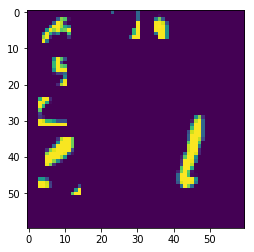

In [22]:
plt.imshow(mnist_train_shift[6])

In [23]:
len(mnist_train_shift)

55000

In [29]:
# import pickle

# with open('mnist_shifted_train_data', 'wb') as handle:
#     pickle.dump(mnist_train_shift, handle)
    
# with open('mnist_shifted_train_labels', 'wb') as handle:
#     pickle.dump(mnist_train_labels, handle)

# Testing Set Shifting

In [24]:
# mnist_test1 = mnist_shift(mnist.test.images, 0, 1000, -21, -21)
# mnist_test2 = mnist_shift(mnist.test.images, 1000, 2000, 21, 21)
# mnist_test3 = mnist_shift(mnist.test.images, 2000, 3000,  21, -21)
# mnist_test4 = mnist_shift(mnist.test.images, 3000, 4000,  -21, 21)
# mnist_test5 = mnist_shift(mnist.test.images, 4000, 5000,  0, -21)
# mnist_test6 = mnist_shift(mnist.test.images, 5000, 6000,  0, 21)
# mnist_test7 = mnist_shift(mnist.test.images, 6000, 7000,  21, 0)
# mnist_test8 = mnist_shift(mnist.test.images, 7000, 8000,  -21, 0)
# mnist_test9 = mnist_shift(mnist.test.images, 8000, 10000,  0, 0)

# mnist_test_shift = np.concatenate((mnist_test1,mnist_test2,mnist_test3,mnist_test4,mnist_test5,mnist_test6,mnist_test7,mnist_test8,mnist_test9))
# mnist_test_labels = mnist.test.labels


mnist_test_shift = mnist_shift(mnist.test.images)

In [7]:
type(mnist_test_shift)

list

In [30]:
# with open('mnist_shifted_test_data', 'wb') as handle:
#     pickle.dump(mnist_test_shift, handle)
    
# with open('mnist_shifted_test_labels', 'wb') as handle:
#     pickle.dump(mnist_test_labels, handle)

In [25]:
len(mnist_test_shift)

10000

## WRITING TF Records

In [26]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))`

In [27]:
train_filename = 'mnist_cluttered_train_data.tfrecords'  # address to save the TFRecords file
# open the TFRecords file
writer = tf.python_io.TFRecordWriter(train_filename)
for i in range(len(mnist_train_shift)):
    print ('Train data:',i,'out of ',len(mnist_train_shift))
    sys.stdout.flush()
        
    # Load the image
    img = mnist_train_shift[i]
    label = mnist.train.labels[i]
    # Create a feature
    feature = {'train/label': _int64_feature(np.argmax(label)),
               'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()

Train data: 0 out of  55000
Train data: 1 out of  55000
Train data: 2 out of  55000
Train data: 3 out of  55000
Train data: 4 out of  55000
Train data: 5 out of  55000
Train data: 6 out of  55000
Train data: 7 out of  55000
Train data: 8 out of  55000
Train data: 9 out of  55000
Train data: 10 out of  55000
Train data: 11 out of  55000
Train data: 12 out of  55000
Train data: 13 out of  55000
Train data: 14 out of  55000
Train data: 15 out of  55000
Train data: 16 out of  55000
Train data: 17 out of  55000
Train data: 18 out of  55000
Train data: 19 out of  55000
Train data: 20 out of  55000
Train data: 21 out of  55000
Train data: 22 out of  55000
Train data: 23 out of  55000
Train data: 24 out of  55000
Train data: 25 out of  55000
Train data: 26 out of  55000
Train data: 27 out of  55000
Train data: 28 out of  55000
Train data: 29 out of  55000
Train data: 30 out of  55000
Train data: 31 out of  55000
Train data: 32 out of  55000
Train data: 33 out of  55000
Train data: 34 out of  5

Train data: 277 out of  55000
Train data: 278 out of  55000
Train data: 279 out of  55000
Train data: 280 out of  55000
Train data: 281 out of  55000
Train data: 282 out of  55000
Train data: 283 out of  55000
Train data: 284 out of  55000
Train data: 285 out of  55000
Train data: 286 out of  55000
Train data: 287 out of  55000
Train data: 288 out of  55000
Train data: 289 out of  55000
Train data: 290 out of  55000
Train data: 291 out of  55000
Train data: 292 out of  55000
Train data: 293 out of  55000
Train data: 294 out of  55000
Train data: 295 out of  55000
Train data: 296 out of  55000
Train data: 297 out of  55000
Train data: 298 out of  55000
Train data: 299 out of  55000
Train data: 300 out of  55000
Train data: 301 out of  55000
Train data: 302 out of  55000
Train data: 303 out of  55000
Train data: 304 out of  55000
Train data: 305 out of  55000
Train data: 306 out of  55000
Train data: 307 out of  55000
Train data: 308 out of  55000
Train data: 309 out of  55000
Train data

Train data: 551 out of  55000
Train data: 552 out of  55000
Train data: 553 out of  55000
Train data: 554 out of  55000
Train data: 555 out of  55000
Train data: 556 out of  55000
Train data: 557 out of  55000
Train data: 558 out of  55000
Train data: 559 out of  55000
Train data: 560 out of  55000
Train data: 561 out of  55000
Train data: 562 out of  55000
Train data: 563 out of  55000
Train data: 564 out of  55000
Train data: 565 out of  55000
Train data: 566 out of  55000
Train data: 567 out of  55000
Train data: 568 out of  55000
Train data: 569 out of  55000
Train data: 570 out of  55000
Train data: 571 out of  55000
Train data: 572 out of  55000
Train data: 573 out of  55000
Train data: 574 out of  55000
Train data: 575 out of  55000
Train data: 576 out of  55000
Train data: 577 out of  55000
Train data: 578 out of  55000
Train data: 579 out of  55000
Train data: 580 out of  55000
Train data: 581 out of  55000
Train data: 582 out of  55000
Train data: 583 out of  55000
Train data

Train data: 825 out of  55000
Train data: 826 out of  55000
Train data: 827 out of  55000
Train data: 828 out of  55000
Train data: 829 out of  55000
Train data: 830 out of  55000
Train data: 831 out of  55000
Train data: 832 out of  55000
Train data: 833 out of  55000
Train data: 834 out of  55000
Train data: 835 out of  55000
Train data: 836 out of  55000
Train data: 837 out of  55000
Train data: 838 out of  55000
Train data: 839 out of  55000
Train data: 840 out of  55000
Train data: 841 out of  55000
Train data: 842 out of  55000
Train data: 843 out of  55000
Train data: 844 out of  55000
Train data: 845 out of  55000
Train data: 846 out of  55000
Train data: 847 out of  55000
Train data: 848 out of  55000
Train data: 849 out of  55000
Train data: 850 out of  55000
Train data: 851 out of  55000
Train data: 852 out of  55000
Train data: 853 out of  55000
Train data: 854 out of  55000
Train data: 855 out of  55000
Train data: 856 out of  55000
Train data: 857 out of  55000
Train data

Train data: 1095 out of  55000
Train data: 1096 out of  55000
Train data: 1097 out of  55000
Train data: 1098 out of  55000
Train data: 1099 out of  55000
Train data: 1100 out of  55000
Train data: 1101 out of  55000
Train data: 1102 out of  55000
Train data: 1103 out of  55000
Train data: 1104 out of  55000
Train data: 1105 out of  55000
Train data: 1106 out of  55000
Train data: 1107 out of  55000
Train data: 1108 out of  55000
Train data: 1109 out of  55000
Train data: 1110 out of  55000
Train data: 1111 out of  55000
Train data: 1112 out of  55000
Train data: 1113 out of  55000
Train data: 1114 out of  55000
Train data: 1115 out of  55000
Train data: 1116 out of  55000
Train data: 1117 out of  55000
Train data: 1118 out of  55000
Train data: 1119 out of  55000
Train data: 1120 out of  55000
Train data: 1121 out of  55000
Train data: 1122 out of  55000
Train data: 1123 out of  55000
Train data: 1124 out of  55000
Train data: 1125 out of  55000
Train data: 1126 out of  55000
Train da

Train data: 1360 out of  55000
Train data: 1361 out of  55000
Train data: 1362 out of  55000
Train data: 1363 out of  55000
Train data: 1364 out of  55000
Train data: 1365 out of  55000
Train data: 1366 out of  55000
Train data: 1367 out of  55000
Train data: 1368 out of  55000
Train data: 1369 out of  55000
Train data: 1370 out of  55000
Train data: 1371 out of  55000
Train data: 1372 out of  55000
Train data: 1373 out of  55000
Train data: 1374 out of  55000
Train data: 1375 out of  55000
Train data: 1376 out of  55000
Train data: 1377 out of  55000
Train data: 1378 out of  55000
Train data: 1379 out of  55000
Train data: 1380 out of  55000
Train data: 1381 out of  55000
Train data: 1382 out of  55000
Train data: 1383 out of  55000
Train data: 1384 out of  55000
Train data: 1385 out of  55000
Train data: 1386 out of  55000
Train data: 1387 out of  55000
Train data: 1388 out of  55000
Train data: 1389 out of  55000
Train data: 1390 out of  55000
Train data: 1391 out of  55000
Train da

Train data: 1625 out of  55000
Train data: 1626 out of  55000
Train data: 1627 out of  55000
Train data: 1628 out of  55000
Train data: 1629 out of  55000
Train data: 1630 out of  55000
Train data: 1631 out of  55000
Train data: 1632 out of  55000
Train data: 1633 out of  55000
Train data: 1634 out of  55000
Train data: 1635 out of  55000
Train data: 1636 out of  55000
Train data: 1637 out of  55000
Train data: 1638 out of  55000
Train data: 1639 out of  55000
Train data: 1640 out of  55000
Train data: 1641 out of  55000
Train data: 1642 out of  55000
Train data: 1643 out of  55000
Train data: 1644 out of  55000
Train data: 1645 out of  55000
Train data: 1646 out of  55000
Train data: 1647 out of  55000
Train data: 1648 out of  55000
Train data: 1649 out of  55000
Train data: 1650 out of  55000
Train data: 1651 out of  55000
Train data: 1652 out of  55000
Train data: 1653 out of  55000
Train data: 1654 out of  55000
Train data: 1655 out of  55000
Train data: 1656 out of  55000
Train da

Train data: 1890 out of  55000
Train data: 1891 out of  55000
Train data: 1892 out of  55000
Train data: 1893 out of  55000
Train data: 1894 out of  55000
Train data: 1895 out of  55000
Train data: 1896 out of  55000
Train data: 1897 out of  55000
Train data: 1898 out of  55000
Train data: 1899 out of  55000
Train data: 1900 out of  55000
Train data: 1901 out of  55000
Train data: 1902 out of  55000
Train data: 1903 out of  55000
Train data: 1904 out of  55000
Train data: 1905 out of  55000
Train data: 1906 out of  55000
Train data: 1907 out of  55000
Train data: 1908 out of  55000
Train data: 1909 out of  55000
Train data: 1910 out of  55000
Train data: 1911 out of  55000
Train data: 1912 out of  55000
Train data: 1913 out of  55000
Train data: 1914 out of  55000
Train data: 1915 out of  55000
Train data: 1916 out of  55000
Train data: 1917 out of  55000
Train data: 1918 out of  55000
Train data: 1919 out of  55000
Train data: 1920 out of  55000
Train data: 1921 out of  55000
Train da

Train data: 2155 out of  55000
Train data: 2156 out of  55000
Train data: 2157 out of  55000
Train data: 2158 out of  55000
Train data: 2159 out of  55000
Train data: 2160 out of  55000
Train data: 2161 out of  55000
Train data: 2162 out of  55000
Train data: 2163 out of  55000
Train data: 2164 out of  55000
Train data: 2165 out of  55000
Train data: 2166 out of  55000
Train data: 2167 out of  55000
Train data: 2168 out of  55000
Train data: 2169 out of  55000
Train data: 2170 out of  55000
Train data: 2171 out of  55000
Train data: 2172 out of  55000
Train data: 2173 out of  55000
Train data: 2174 out of  55000
Train data: 2175 out of  55000
Train data: 2176 out of  55000
Train data: 2177 out of  55000
Train data: 2178 out of  55000
Train data: 2179 out of  55000
Train data: 2180 out of  55000
Train data: 2181 out of  55000
Train data: 2182 out of  55000
Train data: 2183 out of  55000
Train data: 2184 out of  55000
Train data: 2185 out of  55000
Train data: 2186 out of  55000
Train da

Train data: 2420 out of  55000
Train data: 2421 out of  55000
Train data: 2422 out of  55000
Train data: 2423 out of  55000
Train data: 2424 out of  55000
Train data: 2425 out of  55000
Train data: 2426 out of  55000
Train data: 2427 out of  55000
Train data: 2428 out of  55000
Train data: 2429 out of  55000
Train data: 2430 out of  55000
Train data: 2431 out of  55000
Train data: 2432 out of  55000
Train data: 2433 out of  55000
Train data: 2434 out of  55000
Train data: 2435 out of  55000
Train data: 2436 out of  55000
Train data: 2437 out of  55000
Train data: 2438 out of  55000
Train data: 2439 out of  55000
Train data: 2440 out of  55000
Train data: 2441 out of  55000
Train data: 2442 out of  55000
Train data: 2443 out of  55000
Train data: 2444 out of  55000
Train data: 2445 out of  55000
Train data: 2446 out of  55000
Train data: 2447 out of  55000
Train data: 2448 out of  55000
Train data: 2449 out of  55000
Train data: 2450 out of  55000
Train data: 2451 out of  55000
Train da

Train data: 2685 out of  55000
Train data: 2686 out of  55000
Train data: 2687 out of  55000
Train data: 2688 out of  55000
Train data: 2689 out of  55000
Train data: 2690 out of  55000
Train data: 2691 out of  55000
Train data: 2692 out of  55000
Train data: 2693 out of  55000
Train data: 2694 out of  55000
Train data: 2695 out of  55000
Train data: 2696 out of  55000
Train data: 2697 out of  55000
Train data: 2698 out of  55000
Train data: 2699 out of  55000
Train data: 2700 out of  55000
Train data: 2701 out of  55000
Train data: 2702 out of  55000
Train data: 2703 out of  55000
Train data: 2704 out of  55000
Train data: 2705 out of  55000
Train data: 2706 out of  55000
Train data: 2707 out of  55000
Train data: 2708 out of  55000
Train data: 2709 out of  55000
Train data: 2710 out of  55000
Train data: 2711 out of  55000
Train data: 2712 out of  55000
Train data: 2713 out of  55000
Train data: 2714 out of  55000
Train data: 2715 out of  55000
Train data: 2716 out of  55000
Train da

Train data: 2950 out of  55000
Train data: 2951 out of  55000
Train data: 2952 out of  55000
Train data: 2953 out of  55000
Train data: 2954 out of  55000
Train data: 2955 out of  55000
Train data: 2956 out of  55000
Train data: 2957 out of  55000
Train data: 2958 out of  55000
Train data: 2959 out of  55000
Train data: 2960 out of  55000
Train data: 2961 out of  55000
Train data: 2962 out of  55000
Train data: 2963 out of  55000
Train data: 2964 out of  55000
Train data: 2965 out of  55000
Train data: 2966 out of  55000
Train data: 2967 out of  55000
Train data: 2968 out of  55000
Train data: 2969 out of  55000
Train data: 2970 out of  55000
Train data: 2971 out of  55000
Train data: 2972 out of  55000
Train data: 2973 out of  55000
Train data: 2974 out of  55000
Train data: 2975 out of  55000
Train data: 2976 out of  55000
Train data: 2977 out of  55000
Train data: 2978 out of  55000
Train data: 2979 out of  55000
Train data: 2980 out of  55000
Train data: 2981 out of  55000
Train da

Train data: 3215 out of  55000
Train data: 3216 out of  55000
Train data: 3217 out of  55000
Train data: 3218 out of  55000
Train data: 3219 out of  55000
Train data: 3220 out of  55000
Train data: 3221 out of  55000
Train data: 3222 out of  55000
Train data: 3223 out of  55000
Train data: 3224 out of  55000
Train data: 3225 out of  55000
Train data: 3226 out of  55000
Train data: 3227 out of  55000
Train data: 3228 out of  55000
Train data: 3229 out of  55000
Train data: 3230 out of  55000
Train data: 3231 out of  55000
Train data: 3232 out of  55000
Train data: 3233 out of  55000
Train data: 3234 out of  55000
Train data: 3235 out of  55000
Train data: 3236 out of  55000
Train data: 3237 out of  55000
Train data: 3238 out of  55000
Train data: 3239 out of  55000
Train data: 3240 out of  55000
Train data: 3241 out of  55000
Train data: 3242 out of  55000
Train data: 3243 out of  55000
Train data: 3244 out of  55000
Train data: 3245 out of  55000
Train data: 3246 out of  55000
Train da

Train data: 3480 out of  55000
Train data: 3481 out of  55000
Train data: 3482 out of  55000
Train data: 3483 out of  55000
Train data: 3484 out of  55000
Train data: 3485 out of  55000
Train data: 3486 out of  55000
Train data: 3487 out of  55000
Train data: 3488 out of  55000
Train data: 3489 out of  55000
Train data: 3490 out of  55000
Train data: 3491 out of  55000
Train data: 3492 out of  55000
Train data: 3493 out of  55000
Train data: 3494 out of  55000
Train data: 3495 out of  55000
Train data: 3496 out of  55000
Train data: 3497 out of  55000
Train data: 3498 out of  55000
Train data: 3499 out of  55000
Train data: 3500 out of  55000
Train data: 3501 out of  55000
Train data: 3502 out of  55000
Train data: 3503 out of  55000
Train data: 3504 out of  55000
Train data: 3505 out of  55000
Train data: 3506 out of  55000
Train data: 3507 out of  55000
Train data: 3508 out of  55000
Train data: 3509 out of  55000
Train data: 3510 out of  55000
Train data: 3511 out of  55000
Train da

Train data: 3745 out of  55000
Train data: 3746 out of  55000
Train data: 3747 out of  55000
Train data: 3748 out of  55000
Train data: 3749 out of  55000
Train data: 3750 out of  55000
Train data: 3751 out of  55000
Train data: 3752 out of  55000
Train data: 3753 out of  55000
Train data: 3754 out of  55000
Train data: 3755 out of  55000
Train data: 3756 out of  55000
Train data: 3757 out of  55000
Train data: 3758 out of  55000
Train data: 3759 out of  55000
Train data: 3760 out of  55000
Train data: 3761 out of  55000
Train data: 3762 out of  55000
Train data: 3763 out of  55000
Train data: 3764 out of  55000
Train data: 3765 out of  55000
Train data: 3766 out of  55000
Train data: 3767 out of  55000
Train data: 3768 out of  55000
Train data: 3769 out of  55000
Train data: 3770 out of  55000
Train data: 3771 out of  55000
Train data: 3772 out of  55000
Train data: 3773 out of  55000
Train data: 3774 out of  55000
Train data: 3775 out of  55000
Train data: 3776 out of  55000
Train da

Train data: 4010 out of  55000
Train data: 4011 out of  55000
Train data: 4012 out of  55000
Train data: 4013 out of  55000
Train data: 4014 out of  55000
Train data: 4015 out of  55000
Train data: 4016 out of  55000
Train data: 4017 out of  55000
Train data: 4018 out of  55000
Train data: 4019 out of  55000
Train data: 4020 out of  55000
Train data: 4021 out of  55000
Train data: 4022 out of  55000
Train data: 4023 out of  55000
Train data: 4024 out of  55000
Train data: 4025 out of  55000
Train data: 4026 out of  55000
Train data: 4027 out of  55000
Train data: 4028 out of  55000
Train data: 4029 out of  55000
Train data: 4030 out of  55000
Train data: 4031 out of  55000
Train data: 4032 out of  55000
Train data: 4033 out of  55000
Train data: 4034 out of  55000
Train data: 4035 out of  55000
Train data: 4036 out of  55000
Train data: 4037 out of  55000
Train data: 4038 out of  55000
Train data: 4039 out of  55000
Train data: 4040 out of  55000
Train data: 4041 out of  55000
Train da

Train data: 4275 out of  55000
Train data: 4276 out of  55000
Train data: 4277 out of  55000
Train data: 4278 out of  55000
Train data: 4279 out of  55000
Train data: 4280 out of  55000
Train data: 4281 out of  55000
Train data: 4282 out of  55000
Train data: 4283 out of  55000
Train data: 4284 out of  55000
Train data: 4285 out of  55000
Train data: 4286 out of  55000
Train data: 4287 out of  55000
Train data: 4288 out of  55000
Train data: 4289 out of  55000
Train data: 4290 out of  55000
Train data: 4291 out of  55000
Train data: 4292 out of  55000
Train data: 4293 out of  55000
Train data: 4294 out of  55000
Train data: 4295 out of  55000
Train data: 4296 out of  55000
Train data: 4297 out of  55000
Train data: 4298 out of  55000
Train data: 4299 out of  55000
Train data: 4300 out of  55000
Train data: 4301 out of  55000
Train data: 4302 out of  55000
Train data: 4303 out of  55000
Train data: 4304 out of  55000
Train data: 4305 out of  55000
Train data: 4306 out of  55000
Train da

Train data: 4540 out of  55000
Train data: 4541 out of  55000
Train data: 4542 out of  55000
Train data: 4543 out of  55000
Train data: 4544 out of  55000
Train data: 4545 out of  55000
Train data: 4546 out of  55000
Train data: 4547 out of  55000
Train data: 4548 out of  55000
Train data: 4549 out of  55000
Train data: 4550 out of  55000
Train data: 4551 out of  55000
Train data: 4552 out of  55000
Train data: 4553 out of  55000
Train data: 4554 out of  55000
Train data: 4555 out of  55000
Train data: 4556 out of  55000
Train data: 4557 out of  55000
Train data: 4558 out of  55000
Train data: 4559 out of  55000
Train data: 4560 out of  55000
Train data: 4561 out of  55000
Train data: 4562 out of  55000
Train data: 4563 out of  55000
Train data: 4564 out of  55000
Train data: 4565 out of  55000
Train data: 4566 out of  55000
Train data: 4567 out of  55000
Train data: 4568 out of  55000
Train data: 4569 out of  55000
Train data: 4570 out of  55000
Train data: 4571 out of  55000
Train da

Train data: 4805 out of  55000
Train data: 4806 out of  55000
Train data: 4807 out of  55000
Train data: 4808 out of  55000
Train data: 4809 out of  55000
Train data: 4810 out of  55000
Train data: 4811 out of  55000
Train data: 4812 out of  55000
Train data: 4813 out of  55000
Train data: 4814 out of  55000
Train data: 4815 out of  55000
Train data: 4816 out of  55000
Train data: 4817 out of  55000
Train data: 4818 out of  55000
Train data: 4819 out of  55000
Train data: 4820 out of  55000
Train data: 4821 out of  55000
Train data: 4822 out of  55000
Train data: 4823 out of  55000
Train data: 4824 out of  55000
Train data: 4825 out of  55000
Train data: 4826 out of  55000
Train data: 4827 out of  55000
Train data: 4828 out of  55000
Train data: 4829 out of  55000
Train data: 4830 out of  55000
Train data: 4831 out of  55000
Train data: 4832 out of  55000
Train data: 4833 out of  55000
Train data: 4834 out of  55000
Train data: 4835 out of  55000
Train data: 4836 out of  55000
Train da

Train data: 5070 out of  55000
Train data: 5071 out of  55000
Train data: 5072 out of  55000
Train data: 5073 out of  55000
Train data: 5074 out of  55000
Train data: 5075 out of  55000
Train data: 5076 out of  55000
Train data: 5077 out of  55000
Train data: 5078 out of  55000
Train data: 5079 out of  55000
Train data: 5080 out of  55000
Train data: 5081 out of  55000
Train data: 5082 out of  55000
Train data: 5083 out of  55000
Train data: 5084 out of  55000
Train data: 5085 out of  55000
Train data: 5086 out of  55000
Train data: 5087 out of  55000
Train data: 5088 out of  55000
Train data: 5089 out of  55000
Train data: 5090 out of  55000
Train data: 5091 out of  55000
Train data: 5092 out of  55000
Train data: 5093 out of  55000
Train data: 5094 out of  55000
Train data: 5095 out of  55000
Train data: 5096 out of  55000
Train data: 5097 out of  55000
Train data: 5098 out of  55000
Train data: 5099 out of  55000
Train data: 5100 out of  55000
Train data: 5101 out of  55000
Train da

Train data: 5335 out of  55000
Train data: 5336 out of  55000
Train data: 5337 out of  55000
Train data: 5338 out of  55000
Train data: 5339 out of  55000
Train data: 5340 out of  55000
Train data: 5341 out of  55000
Train data: 5342 out of  55000
Train data: 5343 out of  55000
Train data: 5344 out of  55000
Train data: 5345 out of  55000
Train data: 5346 out of  55000
Train data: 5347 out of  55000
Train data: 5348 out of  55000
Train data: 5349 out of  55000
Train data: 5350 out of  55000
Train data: 5351 out of  55000
Train data: 5352 out of  55000
Train data: 5353 out of  55000
Train data: 5354 out of  55000
Train data: 5355 out of  55000
Train data: 5356 out of  55000
Train data: 5357 out of  55000
Train data: 5358 out of  55000
Train data: 5359 out of  55000
Train data: 5360 out of  55000
Train data: 5361 out of  55000
Train data: 5362 out of  55000
Train data: 5363 out of  55000
Train data: 5364 out of  55000
Train data: 5365 out of  55000
Train data: 5366 out of  55000
Train da

Train data: 5600 out of  55000
Train data: 5601 out of  55000
Train data: 5602 out of  55000
Train data: 5603 out of  55000
Train data: 5604 out of  55000
Train data: 5605 out of  55000
Train data: 5606 out of  55000
Train data: 5607 out of  55000
Train data: 5608 out of  55000
Train data: 5609 out of  55000
Train data: 5610 out of  55000
Train data: 5611 out of  55000
Train data: 5612 out of  55000
Train data: 5613 out of  55000
Train data: 5614 out of  55000
Train data: 5615 out of  55000
Train data: 5616 out of  55000
Train data: 5617 out of  55000
Train data: 5618 out of  55000
Train data: 5619 out of  55000
Train data: 5620 out of  55000
Train data: 5621 out of  55000
Train data: 5622 out of  55000
Train data: 5623 out of  55000
Train data: 5624 out of  55000
Train data: 5625 out of  55000
Train data: 5626 out of  55000
Train data: 5627 out of  55000
Train data: 5628 out of  55000
Train data: 5629 out of  55000
Train data: 5630 out of  55000
Train data: 5631 out of  55000
Train da

Train data: 5865 out of  55000
Train data: 5866 out of  55000
Train data: 5867 out of  55000
Train data: 5868 out of  55000
Train data: 5869 out of  55000
Train data: 5870 out of  55000
Train data: 5871 out of  55000
Train data: 5872 out of  55000
Train data: 5873 out of  55000
Train data: 5874 out of  55000
Train data: 5875 out of  55000
Train data: 5876 out of  55000
Train data: 5877 out of  55000
Train data: 5878 out of  55000
Train data: 5879 out of  55000
Train data: 5880 out of  55000
Train data: 5881 out of  55000
Train data: 5882 out of  55000
Train data: 5883 out of  55000
Train data: 5884 out of  55000
Train data: 5885 out of  55000
Train data: 5886 out of  55000
Train data: 5887 out of  55000
Train data: 5888 out of  55000
Train data: 5889 out of  55000
Train data: 5890 out of  55000
Train data: 5891 out of  55000
Train data: 5892 out of  55000
Train data: 5893 out of  55000
Train data: 5894 out of  55000
Train data: 5895 out of  55000
Train data: 5896 out of  55000
Train da

Train data: 6130 out of  55000
Train data: 6131 out of  55000
Train data: 6132 out of  55000
Train data: 6133 out of  55000
Train data: 6134 out of  55000
Train data: 6135 out of  55000
Train data: 6136 out of  55000
Train data: 6137 out of  55000
Train data: 6138 out of  55000
Train data: 6139 out of  55000
Train data: 6140 out of  55000
Train data: 6141 out of  55000
Train data: 6142 out of  55000
Train data: 6143 out of  55000
Train data: 6144 out of  55000
Train data: 6145 out of  55000
Train data: 6146 out of  55000
Train data: 6147 out of  55000
Train data: 6148 out of  55000
Train data: 6149 out of  55000
Train data: 6150 out of  55000
Train data: 6151 out of  55000
Train data: 6152 out of  55000
Train data: 6153 out of  55000
Train data: 6154 out of  55000
Train data: 6155 out of  55000
Train data: 6156 out of  55000
Train data: 6157 out of  55000
Train data: 6158 out of  55000
Train data: 6159 out of  55000
Train data: 6160 out of  55000
Train data: 6161 out of  55000
Train da

Train data: 6395 out of  55000
Train data: 6396 out of  55000
Train data: 6397 out of  55000
Train data: 6398 out of  55000
Train data: 6399 out of  55000
Train data: 6400 out of  55000
Train data: 6401 out of  55000
Train data: 6402 out of  55000
Train data: 6403 out of  55000
Train data: 6404 out of  55000
Train data: 6405 out of  55000
Train data: 6406 out of  55000
Train data: 6407 out of  55000
Train data: 6408 out of  55000
Train data: 6409 out of  55000
Train data: 6410 out of  55000
Train data: 6411 out of  55000
Train data: 6412 out of  55000
Train data: 6413 out of  55000
Train data: 6414 out of  55000
Train data: 6415 out of  55000
Train data: 6416 out of  55000
Train data: 6417 out of  55000
Train data: 6418 out of  55000
Train data: 6419 out of  55000
Train data: 6420 out of  55000
Train data: 6421 out of  55000
Train data: 6422 out of  55000
Train data: 6423 out of  55000
Train data: 6424 out of  55000
Train data: 6425 out of  55000
Train data: 6426 out of  55000
Train da

Train data: 6660 out of  55000
Train data: 6661 out of  55000
Train data: 6662 out of  55000
Train data: 6663 out of  55000
Train data: 6664 out of  55000
Train data: 6665 out of  55000
Train data: 6666 out of  55000
Train data: 6667 out of  55000
Train data: 6668 out of  55000
Train data: 6669 out of  55000
Train data: 6670 out of  55000
Train data: 6671 out of  55000
Train data: 6672 out of  55000
Train data: 6673 out of  55000
Train data: 6674 out of  55000
Train data: 6675 out of  55000
Train data: 6676 out of  55000
Train data: 6677 out of  55000
Train data: 6678 out of  55000
Train data: 6679 out of  55000
Train data: 6680 out of  55000
Train data: 6681 out of  55000
Train data: 6682 out of  55000
Train data: 6683 out of  55000
Train data: 6684 out of  55000
Train data: 6685 out of  55000
Train data: 6686 out of  55000
Train data: 6687 out of  55000
Train data: 6688 out of  55000
Train data: 6689 out of  55000
Train data: 6690 out of  55000
Train data: 6691 out of  55000
Train da

Train data: 6925 out of  55000
Train data: 6926 out of  55000
Train data: 6927 out of  55000
Train data: 6928 out of  55000
Train data: 6929 out of  55000
Train data: 6930 out of  55000
Train data: 6931 out of  55000
Train data: 6932 out of  55000
Train data: 6933 out of  55000
Train data: 6934 out of  55000
Train data: 6935 out of  55000
Train data: 6936 out of  55000
Train data: 6937 out of  55000
Train data: 6938 out of  55000
Train data: 6939 out of  55000
Train data: 6940 out of  55000
Train data: 6941 out of  55000
Train data: 6942 out of  55000
Train data: 6943 out of  55000
Train data: 6944 out of  55000
Train data: 6945 out of  55000
Train data: 6946 out of  55000
Train data: 6947 out of  55000
Train data: 6948 out of  55000
Train data: 6949 out of  55000
Train data: 6950 out of  55000
Train data: 6951 out of  55000
Train data: 6952 out of  55000
Train data: 6953 out of  55000
Train data: 6954 out of  55000
Train data: 6955 out of  55000
Train data: 6956 out of  55000
Train da

Train data: 7190 out of  55000
Train data: 7191 out of  55000
Train data: 7192 out of  55000
Train data: 7193 out of  55000
Train data: 7194 out of  55000
Train data: 7195 out of  55000
Train data: 7196 out of  55000
Train data: 7197 out of  55000
Train data: 7198 out of  55000
Train data: 7199 out of  55000
Train data: 7200 out of  55000
Train data: 7201 out of  55000
Train data: 7202 out of  55000
Train data: 7203 out of  55000
Train data: 7204 out of  55000
Train data: 7205 out of  55000
Train data: 7206 out of  55000
Train data: 7207 out of  55000
Train data: 7208 out of  55000
Train data: 7209 out of  55000
Train data: 7210 out of  55000
Train data: 7211 out of  55000
Train data: 7212 out of  55000
Train data: 7213 out of  55000
Train data: 7214 out of  55000
Train data: 7215 out of  55000
Train data: 7216 out of  55000
Train data: 7217 out of  55000
Train data: 7218 out of  55000
Train data: 7219 out of  55000
Train data: 7220 out of  55000
Train data: 7221 out of  55000
Train da

Train data: 7455 out of  55000
Train data: 7456 out of  55000
Train data: 7457 out of  55000
Train data: 7458 out of  55000
Train data: 7459 out of  55000
Train data: 7460 out of  55000
Train data: 7461 out of  55000
Train data: 7462 out of  55000
Train data: 7463 out of  55000
Train data: 7464 out of  55000
Train data: 7465 out of  55000
Train data: 7466 out of  55000
Train data: 7467 out of  55000
Train data: 7468 out of  55000
Train data: 7469 out of  55000
Train data: 7470 out of  55000
Train data: 7471 out of  55000
Train data: 7472 out of  55000
Train data: 7473 out of  55000
Train data: 7474 out of  55000
Train data: 7475 out of  55000
Train data: 7476 out of  55000
Train data: 7477 out of  55000
Train data: 7478 out of  55000
Train data: 7479 out of  55000
Train data: 7480 out of  55000
Train data: 7481 out of  55000
Train data: 7482 out of  55000
Train data: 7483 out of  55000
Train data: 7484 out of  55000
Train data: 7485 out of  55000
Train data: 7486 out of  55000
Train da

Train data: 7720 out of  55000
Train data: 7721 out of  55000
Train data: 7722 out of  55000
Train data: 7723 out of  55000
Train data: 7724 out of  55000
Train data: 7725 out of  55000
Train data: 7726 out of  55000
Train data: 7727 out of  55000
Train data: 7728 out of  55000
Train data: 7729 out of  55000
Train data: 7730 out of  55000
Train data: 7731 out of  55000
Train data: 7732 out of  55000
Train data: 7733 out of  55000
Train data: 7734 out of  55000
Train data: 7735 out of  55000
Train data: 7736 out of  55000
Train data: 7737 out of  55000
Train data: 7738 out of  55000
Train data: 7739 out of  55000
Train data: 7740 out of  55000
Train data: 7741 out of  55000
Train data: 7742 out of  55000
Train data: 7743 out of  55000
Train data: 7744 out of  55000
Train data: 7745 out of  55000
Train data: 7746 out of  55000
Train data: 7747 out of  55000
Train data: 7748 out of  55000
Train data: 7749 out of  55000
Train data: 7750 out of  55000
Train data: 7751 out of  55000
Train da

Train data: 7985 out of  55000
Train data: 7986 out of  55000
Train data: 7987 out of  55000
Train data: 7988 out of  55000
Train data: 7989 out of  55000
Train data: 7990 out of  55000
Train data: 7991 out of  55000
Train data: 7992 out of  55000
Train data: 7993 out of  55000
Train data: 7994 out of  55000
Train data: 7995 out of  55000
Train data: 7996 out of  55000
Train data: 7997 out of  55000
Train data: 7998 out of  55000
Train data: 7999 out of  55000
Train data: 8000 out of  55000
Train data: 8001 out of  55000
Train data: 8002 out of  55000
Train data: 8003 out of  55000
Train data: 8004 out of  55000
Train data: 8005 out of  55000
Train data: 8006 out of  55000
Train data: 8007 out of  55000
Train data: 8008 out of  55000
Train data: 8009 out of  55000
Train data: 8010 out of  55000
Train data: 8011 out of  55000
Train data: 8012 out of  55000
Train data: 8013 out of  55000
Train data: 8014 out of  55000
Train data: 8015 out of  55000
Train data: 8016 out of  55000
Train da

Train data: 8250 out of  55000
Train data: 8251 out of  55000
Train data: 8252 out of  55000
Train data: 8253 out of  55000
Train data: 8254 out of  55000
Train data: 8255 out of  55000
Train data: 8256 out of  55000
Train data: 8257 out of  55000
Train data: 8258 out of  55000
Train data: 8259 out of  55000
Train data: 8260 out of  55000
Train data: 8261 out of  55000
Train data: 8262 out of  55000
Train data: 8263 out of  55000
Train data: 8264 out of  55000
Train data: 8265 out of  55000
Train data: 8266 out of  55000
Train data: 8267 out of  55000
Train data: 8268 out of  55000
Train data: 8269 out of  55000
Train data: 8270 out of  55000
Train data: 8271 out of  55000
Train data: 8272 out of  55000
Train data: 8273 out of  55000
Train data: 8274 out of  55000
Train data: 8275 out of  55000
Train data: 8276 out of  55000
Train data: 8277 out of  55000
Train data: 8278 out of  55000
Train data: 8279 out of  55000
Train data: 8280 out of  55000
Train data: 8281 out of  55000
Train da

Train data: 8515 out of  55000
Train data: 8516 out of  55000
Train data: 8517 out of  55000
Train data: 8518 out of  55000
Train data: 8519 out of  55000
Train data: 8520 out of  55000
Train data: 8521 out of  55000
Train data: 8522 out of  55000
Train data: 8523 out of  55000
Train data: 8524 out of  55000
Train data: 8525 out of  55000
Train data: 8526 out of  55000
Train data: 8527 out of  55000
Train data: 8528 out of  55000
Train data: 8529 out of  55000
Train data: 8530 out of  55000
Train data: 8531 out of  55000
Train data: 8532 out of  55000
Train data: 8533 out of  55000
Train data: 8534 out of  55000
Train data: 8535 out of  55000
Train data: 8536 out of  55000
Train data: 8537 out of  55000
Train data: 8538 out of  55000
Train data: 8539 out of  55000
Train data: 8540 out of  55000
Train data: 8541 out of  55000
Train data: 8542 out of  55000
Train data: 8543 out of  55000
Train data: 8544 out of  55000
Train data: 8545 out of  55000
Train data: 8546 out of  55000
Train da

Train data: 8780 out of  55000
Train data: 8781 out of  55000
Train data: 8782 out of  55000
Train data: 8783 out of  55000
Train data: 8784 out of  55000
Train data: 8785 out of  55000
Train data: 8786 out of  55000
Train data: 8787 out of  55000
Train data: 8788 out of  55000
Train data: 8789 out of  55000
Train data: 8790 out of  55000
Train data: 8791 out of  55000
Train data: 8792 out of  55000
Train data: 8793 out of  55000
Train data: 8794 out of  55000
Train data: 8795 out of  55000
Train data: 8796 out of  55000
Train data: 8797 out of  55000
Train data: 8798 out of  55000
Train data: 8799 out of  55000
Train data: 8800 out of  55000
Train data: 8801 out of  55000
Train data: 8802 out of  55000
Train data: 8803 out of  55000
Train data: 8804 out of  55000
Train data: 8805 out of  55000
Train data: 8806 out of  55000
Train data: 8807 out of  55000
Train data: 8808 out of  55000
Train data: 8809 out of  55000
Train data: 8810 out of  55000
Train data: 8811 out of  55000
Train da

Train data: 9045 out of  55000
Train data: 9046 out of  55000
Train data: 9047 out of  55000
Train data: 9048 out of  55000
Train data: 9049 out of  55000
Train data: 9050 out of  55000
Train data: 9051 out of  55000
Train data: 9052 out of  55000
Train data: 9053 out of  55000
Train data: 9054 out of  55000
Train data: 9055 out of  55000
Train data: 9056 out of  55000
Train data: 9057 out of  55000
Train data: 9058 out of  55000
Train data: 9059 out of  55000
Train data: 9060 out of  55000
Train data: 9061 out of  55000
Train data: 9062 out of  55000
Train data: 9063 out of  55000
Train data: 9064 out of  55000
Train data: 9065 out of  55000
Train data: 9066 out of  55000
Train data: 9067 out of  55000
Train data: 9068 out of  55000
Train data: 9069 out of  55000
Train data: 9070 out of  55000
Train data: 9071 out of  55000
Train data: 9072 out of  55000
Train data: 9073 out of  55000
Train data: 9074 out of  55000
Train data: 9075 out of  55000
Train data: 9076 out of  55000
Train da

Train data: 9310 out of  55000
Train data: 9311 out of  55000
Train data: 9312 out of  55000
Train data: 9313 out of  55000
Train data: 9314 out of  55000
Train data: 9315 out of  55000
Train data: 9316 out of  55000
Train data: 9317 out of  55000
Train data: 9318 out of  55000
Train data: 9319 out of  55000
Train data: 9320 out of  55000
Train data: 9321 out of  55000
Train data: 9322 out of  55000
Train data: 9323 out of  55000
Train data: 9324 out of  55000
Train data: 9325 out of  55000
Train data: 9326 out of  55000
Train data: 9327 out of  55000
Train data: 9328 out of  55000
Train data: 9329 out of  55000
Train data: 9330 out of  55000
Train data: 9331 out of  55000
Train data: 9332 out of  55000
Train data: 9333 out of  55000
Train data: 9334 out of  55000
Train data: 9335 out of  55000
Train data: 9336 out of  55000
Train data: 9337 out of  55000
Train data: 9338 out of  55000
Train data: 9339 out of  55000
Train data: 9340 out of  55000
Train data: 9341 out of  55000
Train da

Train data: 9575 out of  55000
Train data: 9576 out of  55000
Train data: 9577 out of  55000
Train data: 9578 out of  55000
Train data: 9579 out of  55000
Train data: 9580 out of  55000
Train data: 9581 out of  55000
Train data: 9582 out of  55000
Train data: 9583 out of  55000
Train data: 9584 out of  55000
Train data: 9585 out of  55000
Train data: 9586 out of  55000
Train data: 9587 out of  55000
Train data: 9588 out of  55000
Train data: 9589 out of  55000
Train data: 9590 out of  55000
Train data: 9591 out of  55000
Train data: 9592 out of  55000
Train data: 9593 out of  55000
Train data: 9594 out of  55000
Train data: 9595 out of  55000
Train data: 9596 out of  55000
Train data: 9597 out of  55000
Train data: 9598 out of  55000
Train data: 9599 out of  55000
Train data: 9600 out of  55000
Train data: 9601 out of  55000
Train data: 9602 out of  55000
Train data: 9603 out of  55000
Train data: 9604 out of  55000
Train data: 9605 out of  55000
Train data: 9606 out of  55000
Train da

Train data: 9840 out of  55000
Train data: 9841 out of  55000
Train data: 9842 out of  55000
Train data: 9843 out of  55000
Train data: 9844 out of  55000
Train data: 9845 out of  55000
Train data: 9846 out of  55000
Train data: 9847 out of  55000
Train data: 9848 out of  55000
Train data: 9849 out of  55000
Train data: 9850 out of  55000
Train data: 9851 out of  55000
Train data: 9852 out of  55000
Train data: 9853 out of  55000
Train data: 9854 out of  55000
Train data: 9855 out of  55000
Train data: 9856 out of  55000
Train data: 9857 out of  55000
Train data: 9858 out of  55000
Train data: 9859 out of  55000
Train data: 9860 out of  55000
Train data: 9861 out of  55000
Train data: 9862 out of  55000
Train data: 9863 out of  55000
Train data: 9864 out of  55000
Train data: 9865 out of  55000
Train data: 9866 out of  55000
Train data: 9867 out of  55000
Train data: 9868 out of  55000
Train data: 9869 out of  55000
Train data: 9870 out of  55000
Train data: 9871 out of  55000
Train da

Train data: 10102 out of  55000
Train data: 10103 out of  55000
Train data: 10104 out of  55000
Train data: 10105 out of  55000
Train data: 10106 out of  55000
Train data: 10107 out of  55000
Train data: 10108 out of  55000
Train data: 10109 out of  55000
Train data: 10110 out of  55000
Train data: 10111 out of  55000
Train data: 10112 out of  55000
Train data: 10113 out of  55000
Train data: 10114 out of  55000
Train data: 10115 out of  55000
Train data: 10116 out of  55000
Train data: 10117 out of  55000
Train data: 10118 out of  55000
Train data: 10119 out of  55000
Train data: 10120 out of  55000
Train data: 10121 out of  55000
Train data: 10122 out of  55000
Train data: 10123 out of  55000
Train data: 10124 out of  55000
Train data: 10125 out of  55000
Train data: 10126 out of  55000
Train data: 10127 out of  55000
Train data: 10128 out of  55000
Train data: 10129 out of  55000
Train data: 10130 out of  55000
Train data: 10131 out of  55000
Train data: 10132 out of  55000
Train da

Train data: 10359 out of  55000
Train data: 10360 out of  55000
Train data: 10361 out of  55000
Train data: 10362 out of  55000
Train data: 10363 out of  55000
Train data: 10364 out of  55000
Train data: 10365 out of  55000
Train data: 10366 out of  55000
Train data: 10367 out of  55000
Train data: 10368 out of  55000
Train data: 10369 out of  55000
Train data: 10370 out of  55000
Train data: 10371 out of  55000
Train data: 10372 out of  55000
Train data: 10373 out of  55000
Train data: 10374 out of  55000
Train data: 10375 out of  55000
Train data: 10376 out of  55000
Train data: 10377 out of  55000
Train data: 10378 out of  55000
Train data: 10379 out of  55000
Train data: 10380 out of  55000
Train data: 10381 out of  55000
Train data: 10382 out of  55000
Train data: 10383 out of  55000
Train data: 10384 out of  55000
Train data: 10385 out of  55000
Train data: 10386 out of  55000
Train data: 10387 out of  55000
Train data: 10388 out of  55000
Train data: 10389 out of  55000
Train da

Train data: 10616 out of  55000
Train data: 10617 out of  55000
Train data: 10618 out of  55000
Train data: 10619 out of  55000
Train data: 10620 out of  55000
Train data: 10621 out of  55000
Train data: 10622 out of  55000
Train data: 10623 out of  55000
Train data: 10624 out of  55000
Train data: 10625 out of  55000
Train data: 10626 out of  55000
Train data: 10627 out of  55000
Train data: 10628 out of  55000
Train data: 10629 out of  55000
Train data: 10630 out of  55000
Train data: 10631 out of  55000
Train data: 10632 out of  55000
Train data: 10633 out of  55000
Train data: 10634 out of  55000
Train data: 10635 out of  55000
Train data: 10636 out of  55000
Train data: 10637 out of  55000
Train data: 10638 out of  55000
Train data: 10639 out of  55000
Train data: 10640 out of  55000
Train data: 10641 out of  55000
Train data: 10642 out of  55000
Train data: 10643 out of  55000
Train data: 10644 out of  55000
Train data: 10645 out of  55000
Train data: 10646 out of  55000
Train da

Train data: 10873 out of  55000
Train data: 10874 out of  55000
Train data: 10875 out of  55000
Train data: 10876 out of  55000
Train data: 10877 out of  55000
Train data: 10878 out of  55000
Train data: 10879 out of  55000
Train data: 10880 out of  55000
Train data: 10881 out of  55000
Train data: 10882 out of  55000
Train data: 10883 out of  55000
Train data: 10884 out of  55000
Train data: 10885 out of  55000
Train data: 10886 out of  55000
Train data: 10887 out of  55000
Train data: 10888 out of  55000
Train data: 10889 out of  55000
Train data: 10890 out of  55000
Train data: 10891 out of  55000
Train data: 10892 out of  55000
Train data: 10893 out of  55000
Train data: 10894 out of  55000
Train data: 10895 out of  55000
Train data: 10896 out of  55000
Train data: 10897 out of  55000
Train data: 10898 out of  55000
Train data: 10899 out of  55000
Train data: 10900 out of  55000
Train data: 10901 out of  55000
Train data: 10902 out of  55000
Train data: 10903 out of  55000
Train da

Train data: 11130 out of  55000
Train data: 11131 out of  55000
Train data: 11132 out of  55000
Train data: 11133 out of  55000
Train data: 11134 out of  55000
Train data: 11135 out of  55000
Train data: 11136 out of  55000
Train data: 11137 out of  55000
Train data: 11138 out of  55000
Train data: 11139 out of  55000
Train data: 11140 out of  55000
Train data: 11141 out of  55000
Train data: 11142 out of  55000
Train data: 11143 out of  55000
Train data: 11144 out of  55000
Train data: 11145 out of  55000
Train data: 11146 out of  55000
Train data: 11147 out of  55000
Train data: 11148 out of  55000
Train data: 11149 out of  55000
Train data: 11150 out of  55000
Train data: 11151 out of  55000
Train data: 11152 out of  55000
Train data: 11153 out of  55000
Train data: 11154 out of  55000
Train data: 11155 out of  55000
Train data: 11156 out of  55000
Train data: 11157 out of  55000
Train data: 11158 out of  55000
Train data: 11159 out of  55000
Train data: 11160 out of  55000
Train da

Train data: 11387 out of  55000
Train data: 11388 out of  55000
Train data: 11389 out of  55000
Train data: 11390 out of  55000
Train data: 11391 out of  55000
Train data: 11392 out of  55000
Train data: 11393 out of  55000
Train data: 11394 out of  55000
Train data: 11395 out of  55000
Train data: 11396 out of  55000
Train data: 11397 out of  55000
Train data: 11398 out of  55000
Train data: 11399 out of  55000
Train data: 11400 out of  55000
Train data: 11401 out of  55000
Train data: 11402 out of  55000
Train data: 11403 out of  55000
Train data: 11404 out of  55000
Train data: 11405 out of  55000
Train data: 11406 out of  55000
Train data: 11407 out of  55000
Train data: 11408 out of  55000
Train data: 11409 out of  55000
Train data: 11410 out of  55000
Train data: 11411 out of  55000
Train data: 11412 out of  55000
Train data: 11413 out of  55000
Train data: 11414 out of  55000
Train data: 11415 out of  55000
Train data: 11416 out of  55000
Train data: 11417 out of  55000
Train da

Train data: 11644 out of  55000
Train data: 11645 out of  55000
Train data: 11646 out of  55000
Train data: 11647 out of  55000
Train data: 11648 out of  55000
Train data: 11649 out of  55000
Train data: 11650 out of  55000
Train data: 11651 out of  55000
Train data: 11652 out of  55000
Train data: 11653 out of  55000
Train data: 11654 out of  55000
Train data: 11655 out of  55000
Train data: 11656 out of  55000
Train data: 11657 out of  55000
Train data: 11658 out of  55000
Train data: 11659 out of  55000
Train data: 11660 out of  55000
Train data: 11661 out of  55000
Train data: 11662 out of  55000
Train data: 11663 out of  55000
Train data: 11664 out of  55000
Train data: 11665 out of  55000
Train data: 11666 out of  55000
Train data: 11667 out of  55000
Train data: 11668 out of  55000
Train data: 11669 out of  55000
Train data: 11670 out of  55000
Train data: 11671 out of  55000
Train data: 11672 out of  55000
Train data: 11673 out of  55000
Train data: 11674 out of  55000
Train da

Train data: 11901 out of  55000
Train data: 11902 out of  55000
Train data: 11903 out of  55000
Train data: 11904 out of  55000
Train data: 11905 out of  55000
Train data: 11906 out of  55000
Train data: 11907 out of  55000
Train data: 11908 out of  55000
Train data: 11909 out of  55000
Train data: 11910 out of  55000
Train data: 11911 out of  55000
Train data: 11912 out of  55000
Train data: 11913 out of  55000
Train data: 11914 out of  55000
Train data: 11915 out of  55000
Train data: 11916 out of  55000
Train data: 11917 out of  55000
Train data: 11918 out of  55000
Train data: 11919 out of  55000
Train data: 11920 out of  55000
Train data: 11921 out of  55000
Train data: 11922 out of  55000
Train data: 11923 out of  55000
Train data: 11924 out of  55000
Train data: 11925 out of  55000
Train data: 11926 out of  55000
Train data: 11927 out of  55000
Train data: 11928 out of  55000
Train data: 11929 out of  55000
Train data: 11930 out of  55000
Train data: 11931 out of  55000
Train da

Train data: 12158 out of  55000
Train data: 12159 out of  55000
Train data: 12160 out of  55000
Train data: 12161 out of  55000
Train data: 12162 out of  55000
Train data: 12163 out of  55000
Train data: 12164 out of  55000
Train data: 12165 out of  55000
Train data: 12166 out of  55000
Train data: 12167 out of  55000
Train data: 12168 out of  55000
Train data: 12169 out of  55000
Train data: 12170 out of  55000
Train data: 12171 out of  55000
Train data: 12172 out of  55000
Train data: 12173 out of  55000
Train data: 12174 out of  55000
Train data: 12175 out of  55000
Train data: 12176 out of  55000
Train data: 12177 out of  55000
Train data: 12178 out of  55000
Train data: 12179 out of  55000
Train data: 12180 out of  55000
Train data: 12181 out of  55000
Train data: 12182 out of  55000
Train data: 12183 out of  55000
Train data: 12184 out of  55000
Train data: 12185 out of  55000
Train data: 12186 out of  55000
Train data: 12187 out of  55000
Train data: 12188 out of  55000
Train da

Train data: 12415 out of  55000
Train data: 12416 out of  55000
Train data: 12417 out of  55000
Train data: 12418 out of  55000
Train data: 12419 out of  55000
Train data: 12420 out of  55000
Train data: 12421 out of  55000
Train data: 12422 out of  55000
Train data: 12423 out of  55000
Train data: 12424 out of  55000
Train data: 12425 out of  55000
Train data: 12426 out of  55000
Train data: 12427 out of  55000
Train data: 12428 out of  55000
Train data: 12429 out of  55000
Train data: 12430 out of  55000
Train data: 12431 out of  55000
Train data: 12432 out of  55000
Train data: 12433 out of  55000
Train data: 12434 out of  55000
Train data: 12435 out of  55000
Train data: 12436 out of  55000
Train data: 12437 out of  55000
Train data: 12438 out of  55000
Train data: 12439 out of  55000
Train data: 12440 out of  55000
Train data: 12441 out of  55000
Train data: 12442 out of  55000
Train data: 12443 out of  55000
Train data: 12444 out of  55000
Train data: 12445 out of  55000
Train da

Train data: 12672 out of  55000
Train data: 12673 out of  55000
Train data: 12674 out of  55000
Train data: 12675 out of  55000
Train data: 12676 out of  55000
Train data: 12677 out of  55000
Train data: 12678 out of  55000
Train data: 12679 out of  55000
Train data: 12680 out of  55000
Train data: 12681 out of  55000
Train data: 12682 out of  55000
Train data: 12683 out of  55000
Train data: 12684 out of  55000
Train data: 12685 out of  55000
Train data: 12686 out of  55000
Train data: 12687 out of  55000
Train data: 12688 out of  55000
Train data: 12689 out of  55000
Train data: 12690 out of  55000
Train data: 12691 out of  55000
Train data: 12692 out of  55000
Train data: 12693 out of  55000
Train data: 12694 out of  55000
Train data: 12695 out of  55000
Train data: 12696 out of  55000
Train data: 12697 out of  55000
Train data: 12698 out of  55000
Train data: 12699 out of  55000
Train data: 12700 out of  55000
Train data: 12701 out of  55000
Train data: 12702 out of  55000
Train da

Train data: 12929 out of  55000
Train data: 12930 out of  55000
Train data: 12931 out of  55000
Train data: 12932 out of  55000
Train data: 12933 out of  55000
Train data: 12934 out of  55000
Train data: 12935 out of  55000
Train data: 12936 out of  55000
Train data: 12937 out of  55000
Train data: 12938 out of  55000
Train data: 12939 out of  55000
Train data: 12940 out of  55000
Train data: 12941 out of  55000
Train data: 12942 out of  55000
Train data: 12943 out of  55000
Train data: 12944 out of  55000
Train data: 12945 out of  55000
Train data: 12946 out of  55000
Train data: 12947 out of  55000
Train data: 12948 out of  55000
Train data: 12949 out of  55000
Train data: 12950 out of  55000
Train data: 12951 out of  55000
Train data: 12952 out of  55000
Train data: 12953 out of  55000
Train data: 12954 out of  55000
Train data: 12955 out of  55000
Train data: 12956 out of  55000
Train data: 12957 out of  55000
Train data: 12958 out of  55000
Train data: 12959 out of  55000
Train da

Train data: 13186 out of  55000
Train data: 13187 out of  55000
Train data: 13188 out of  55000
Train data: 13189 out of  55000
Train data: 13190 out of  55000
Train data: 13191 out of  55000
Train data: 13192 out of  55000
Train data: 13193 out of  55000
Train data: 13194 out of  55000
Train data: 13195 out of  55000
Train data: 13196 out of  55000
Train data: 13197 out of  55000
Train data: 13198 out of  55000
Train data: 13199 out of  55000
Train data: 13200 out of  55000
Train data: 13201 out of  55000
Train data: 13202 out of  55000
Train data: 13203 out of  55000
Train data: 13204 out of  55000
Train data: 13205 out of  55000
Train data: 13206 out of  55000
Train data: 13207 out of  55000
Train data: 13208 out of  55000
Train data: 13209 out of  55000
Train data: 13210 out of  55000
Train data: 13211 out of  55000
Train data: 13212 out of  55000
Train data: 13213 out of  55000
Train data: 13214 out of  55000
Train data: 13215 out of  55000
Train data: 13216 out of  55000
Train da

Train data: 13443 out of  55000
Train data: 13444 out of  55000
Train data: 13445 out of  55000
Train data: 13446 out of  55000
Train data: 13447 out of  55000
Train data: 13448 out of  55000
Train data: 13449 out of  55000
Train data: 13450 out of  55000
Train data: 13451 out of  55000
Train data: 13452 out of  55000
Train data: 13453 out of  55000
Train data: 13454 out of  55000
Train data: 13455 out of  55000
Train data: 13456 out of  55000
Train data: 13457 out of  55000
Train data: 13458 out of  55000
Train data: 13459 out of  55000
Train data: 13460 out of  55000
Train data: 13461 out of  55000
Train data: 13462 out of  55000
Train data: 13463 out of  55000
Train data: 13464 out of  55000
Train data: 13465 out of  55000
Train data: 13466 out of  55000
Train data: 13467 out of  55000
Train data: 13468 out of  55000
Train data: 13469 out of  55000
Train data: 13470 out of  55000
Train data: 13471 out of  55000
Train data: 13472 out of  55000
Train data: 13473 out of  55000
Train da

Train data: 13700 out of  55000
Train data: 13701 out of  55000
Train data: 13702 out of  55000
Train data: 13703 out of  55000
Train data: 13704 out of  55000
Train data: 13705 out of  55000
Train data: 13706 out of  55000
Train data: 13707 out of  55000
Train data: 13708 out of  55000
Train data: 13709 out of  55000
Train data: 13710 out of  55000
Train data: 13711 out of  55000
Train data: 13712 out of  55000
Train data: 13713 out of  55000
Train data: 13714 out of  55000
Train data: 13715 out of  55000
Train data: 13716 out of  55000
Train data: 13717 out of  55000
Train data: 13718 out of  55000
Train data: 13719 out of  55000
Train data: 13720 out of  55000
Train data: 13721 out of  55000
Train data: 13722 out of  55000
Train data: 13723 out of  55000
Train data: 13724 out of  55000
Train data: 13725 out of  55000
Train data: 13726 out of  55000
Train data: 13727 out of  55000
Train data: 13728 out of  55000
Train data: 13729 out of  55000
Train data: 13730 out of  55000
Train da

Train data: 13957 out of  55000
Train data: 13958 out of  55000
Train data: 13959 out of  55000
Train data: 13960 out of  55000
Train data: 13961 out of  55000
Train data: 13962 out of  55000
Train data: 13963 out of  55000
Train data: 13964 out of  55000
Train data: 13965 out of  55000
Train data: 13966 out of  55000
Train data: 13967 out of  55000
Train data: 13968 out of  55000
Train data: 13969 out of  55000
Train data: 13970 out of  55000
Train data: 13971 out of  55000
Train data: 13972 out of  55000
Train data: 13973 out of  55000
Train data: 13974 out of  55000
Train data: 13975 out of  55000
Train data: 13976 out of  55000
Train data: 13977 out of  55000
Train data: 13978 out of  55000
Train data: 13979 out of  55000
Train data: 13980 out of  55000
Train data: 13981 out of  55000
Train data: 13982 out of  55000
Train data: 13983 out of  55000
Train data: 13984 out of  55000
Train data: 13985 out of  55000
Train data: 13986 out of  55000
Train data: 13987 out of  55000
Train da

Train data: 14214 out of  55000
Train data: 14215 out of  55000
Train data: 14216 out of  55000
Train data: 14217 out of  55000
Train data: 14218 out of  55000
Train data: 14219 out of  55000
Train data: 14220 out of  55000
Train data: 14221 out of  55000
Train data: 14222 out of  55000
Train data: 14223 out of  55000
Train data: 14224 out of  55000
Train data: 14225 out of  55000
Train data: 14226 out of  55000
Train data: 14227 out of  55000
Train data: 14228 out of  55000
Train data: 14229 out of  55000
Train data: 14230 out of  55000
Train data: 14231 out of  55000
Train data: 14232 out of  55000
Train data: 14233 out of  55000
Train data: 14234 out of  55000
Train data: 14235 out of  55000
Train data: 14236 out of  55000
Train data: 14237 out of  55000
Train data: 14238 out of  55000
Train data: 14239 out of  55000
Train data: 14240 out of  55000
Train data: 14241 out of  55000
Train data: 14242 out of  55000
Train data: 14243 out of  55000
Train data: 14244 out of  55000
Train da

Train data: 14471 out of  55000
Train data: 14472 out of  55000
Train data: 14473 out of  55000
Train data: 14474 out of  55000
Train data: 14475 out of  55000
Train data: 14476 out of  55000
Train data: 14477 out of  55000
Train data: 14478 out of  55000
Train data: 14479 out of  55000
Train data: 14480 out of  55000
Train data: 14481 out of  55000
Train data: 14482 out of  55000
Train data: 14483 out of  55000
Train data: 14484 out of  55000
Train data: 14485 out of  55000
Train data: 14486 out of  55000
Train data: 14487 out of  55000
Train data: 14488 out of  55000
Train data: 14489 out of  55000
Train data: 14490 out of  55000
Train data: 14491 out of  55000
Train data: 14492 out of  55000
Train data: 14493 out of  55000
Train data: 14494 out of  55000
Train data: 14495 out of  55000
Train data: 14496 out of  55000
Train data: 14497 out of  55000
Train data: 14498 out of  55000
Train data: 14499 out of  55000
Train data: 14500 out of  55000
Train data: 14501 out of  55000
Train da

Train data: 14728 out of  55000
Train data: 14729 out of  55000
Train data: 14730 out of  55000
Train data: 14731 out of  55000
Train data: 14732 out of  55000
Train data: 14733 out of  55000
Train data: 14734 out of  55000
Train data: 14735 out of  55000
Train data: 14736 out of  55000
Train data: 14737 out of  55000
Train data: 14738 out of  55000
Train data: 14739 out of  55000
Train data: 14740 out of  55000
Train data: 14741 out of  55000
Train data: 14742 out of  55000
Train data: 14743 out of  55000
Train data: 14744 out of  55000
Train data: 14745 out of  55000
Train data: 14746 out of  55000
Train data: 14747 out of  55000
Train data: 14748 out of  55000
Train data: 14749 out of  55000
Train data: 14750 out of  55000
Train data: 14751 out of  55000
Train data: 14752 out of  55000
Train data: 14753 out of  55000
Train data: 14754 out of  55000
Train data: 14755 out of  55000
Train data: 14756 out of  55000
Train data: 14757 out of  55000
Train data: 14758 out of  55000
Train da

Train data: 14985 out of  55000
Train data: 14986 out of  55000
Train data: 14987 out of  55000
Train data: 14988 out of  55000
Train data: 14989 out of  55000
Train data: 14990 out of  55000
Train data: 14991 out of  55000
Train data: 14992 out of  55000
Train data: 14993 out of  55000
Train data: 14994 out of  55000
Train data: 14995 out of  55000
Train data: 14996 out of  55000
Train data: 14997 out of  55000
Train data: 14998 out of  55000
Train data: 14999 out of  55000
Train data: 15000 out of  55000
Train data: 15001 out of  55000
Train data: 15002 out of  55000
Train data: 15003 out of  55000
Train data: 15004 out of  55000
Train data: 15005 out of  55000
Train data: 15006 out of  55000
Train data: 15007 out of  55000
Train data: 15008 out of  55000
Train data: 15009 out of  55000
Train data: 15010 out of  55000
Train data: 15011 out of  55000
Train data: 15012 out of  55000
Train data: 15013 out of  55000
Train data: 15014 out of  55000
Train data: 15015 out of  55000
Train da

Train data: 15242 out of  55000
Train data: 15243 out of  55000
Train data: 15244 out of  55000
Train data: 15245 out of  55000
Train data: 15246 out of  55000
Train data: 15247 out of  55000
Train data: 15248 out of  55000
Train data: 15249 out of  55000
Train data: 15250 out of  55000
Train data: 15251 out of  55000
Train data: 15252 out of  55000
Train data: 15253 out of  55000
Train data: 15254 out of  55000
Train data: 15255 out of  55000
Train data: 15256 out of  55000
Train data: 15257 out of  55000
Train data: 15258 out of  55000
Train data: 15259 out of  55000
Train data: 15260 out of  55000
Train data: 15261 out of  55000
Train data: 15262 out of  55000
Train data: 15263 out of  55000
Train data: 15264 out of  55000
Train data: 15265 out of  55000
Train data: 15266 out of  55000
Train data: 15267 out of  55000
Train data: 15268 out of  55000
Train data: 15269 out of  55000
Train data: 15270 out of  55000
Train data: 15271 out of  55000
Train data: 15272 out of  55000
Train da

Train data: 15499 out of  55000
Train data: 15500 out of  55000
Train data: 15501 out of  55000
Train data: 15502 out of  55000
Train data: 15503 out of  55000
Train data: 15504 out of  55000
Train data: 15505 out of  55000
Train data: 15506 out of  55000
Train data: 15507 out of  55000
Train data: 15508 out of  55000
Train data: 15509 out of  55000
Train data: 15510 out of  55000
Train data: 15511 out of  55000
Train data: 15512 out of  55000
Train data: 15513 out of  55000
Train data: 15514 out of  55000
Train data: 15515 out of  55000
Train data: 15516 out of  55000
Train data: 15517 out of  55000
Train data: 15518 out of  55000
Train data: 15519 out of  55000
Train data: 15520 out of  55000
Train data: 15521 out of  55000
Train data: 15522 out of  55000
Train data: 15523 out of  55000
Train data: 15524 out of  55000
Train data: 15525 out of  55000
Train data: 15526 out of  55000
Train data: 15527 out of  55000
Train data: 15528 out of  55000
Train data: 15529 out of  55000
Train da

Train data: 15756 out of  55000
Train data: 15757 out of  55000
Train data: 15758 out of  55000
Train data: 15759 out of  55000
Train data: 15760 out of  55000
Train data: 15761 out of  55000
Train data: 15762 out of  55000
Train data: 15763 out of  55000
Train data: 15764 out of  55000
Train data: 15765 out of  55000
Train data: 15766 out of  55000
Train data: 15767 out of  55000
Train data: 15768 out of  55000
Train data: 15769 out of  55000
Train data: 15770 out of  55000
Train data: 15771 out of  55000
Train data: 15772 out of  55000
Train data: 15773 out of  55000
Train data: 15774 out of  55000
Train data: 15775 out of  55000
Train data: 15776 out of  55000
Train data: 15777 out of  55000
Train data: 15778 out of  55000
Train data: 15779 out of  55000
Train data: 15780 out of  55000
Train data: 15781 out of  55000
Train data: 15782 out of  55000
Train data: 15783 out of  55000
Train data: 15784 out of  55000
Train data: 15785 out of  55000
Train data: 15786 out of  55000
Train da

Train data: 16013 out of  55000
Train data: 16014 out of  55000
Train data: 16015 out of  55000
Train data: 16016 out of  55000
Train data: 16017 out of  55000
Train data: 16018 out of  55000
Train data: 16019 out of  55000
Train data: 16020 out of  55000
Train data: 16021 out of  55000
Train data: 16022 out of  55000
Train data: 16023 out of  55000
Train data: 16024 out of  55000
Train data: 16025 out of  55000
Train data: 16026 out of  55000
Train data: 16027 out of  55000
Train data: 16028 out of  55000
Train data: 16029 out of  55000
Train data: 16030 out of  55000
Train data: 16031 out of  55000
Train data: 16032 out of  55000
Train data: 16033 out of  55000
Train data: 16034 out of  55000
Train data: 16035 out of  55000
Train data: 16036 out of  55000
Train data: 16037 out of  55000
Train data: 16038 out of  55000
Train data: 16039 out of  55000
Train data: 16040 out of  55000
Train data: 16041 out of  55000
Train data: 16042 out of  55000
Train data: 16043 out of  55000
Train da

Train data: 16270 out of  55000
Train data: 16271 out of  55000
Train data: 16272 out of  55000
Train data: 16273 out of  55000
Train data: 16274 out of  55000
Train data: 16275 out of  55000
Train data: 16276 out of  55000
Train data: 16277 out of  55000
Train data: 16278 out of  55000
Train data: 16279 out of  55000
Train data: 16280 out of  55000
Train data: 16281 out of  55000
Train data: 16282 out of  55000
Train data: 16283 out of  55000
Train data: 16284 out of  55000
Train data: 16285 out of  55000
Train data: 16286 out of  55000
Train data: 16287 out of  55000
Train data: 16288 out of  55000
Train data: 16289 out of  55000
Train data: 16290 out of  55000
Train data: 16291 out of  55000
Train data: 16292 out of  55000
Train data: 16293 out of  55000
Train data: 16294 out of  55000
Train data: 16295 out of  55000
Train data: 16296 out of  55000
Train data: 16297 out of  55000
Train data: 16298 out of  55000
Train data: 16299 out of  55000
Train data: 16300 out of  55000
Train da

Train data: 16527 out of  55000
Train data: 16528 out of  55000
Train data: 16529 out of  55000
Train data: 16530 out of  55000
Train data: 16531 out of  55000
Train data: 16532 out of  55000
Train data: 16533 out of  55000
Train data: 16534 out of  55000
Train data: 16535 out of  55000
Train data: 16536 out of  55000
Train data: 16537 out of  55000
Train data: 16538 out of  55000
Train data: 16539 out of  55000
Train data: 16540 out of  55000
Train data: 16541 out of  55000
Train data: 16542 out of  55000
Train data: 16543 out of  55000
Train data: 16544 out of  55000
Train data: 16545 out of  55000
Train data: 16546 out of  55000
Train data: 16547 out of  55000
Train data: 16548 out of  55000
Train data: 16549 out of  55000
Train data: 16550 out of  55000
Train data: 16551 out of  55000
Train data: 16552 out of  55000
Train data: 16553 out of  55000
Train data: 16554 out of  55000
Train data: 16555 out of  55000
Train data: 16556 out of  55000
Train data: 16557 out of  55000
Train da

Train data: 16784 out of  55000
Train data: 16785 out of  55000
Train data: 16786 out of  55000
Train data: 16787 out of  55000
Train data: 16788 out of  55000
Train data: 16789 out of  55000
Train data: 16790 out of  55000
Train data: 16791 out of  55000
Train data: 16792 out of  55000
Train data: 16793 out of  55000
Train data: 16794 out of  55000
Train data: 16795 out of  55000
Train data: 16796 out of  55000
Train data: 16797 out of  55000
Train data: 16798 out of  55000
Train data: 16799 out of  55000
Train data: 16800 out of  55000
Train data: 16801 out of  55000
Train data: 16802 out of  55000
Train data: 16803 out of  55000
Train data: 16804 out of  55000
Train data: 16805 out of  55000
Train data: 16806 out of  55000
Train data: 16807 out of  55000
Train data: 16808 out of  55000
Train data: 16809 out of  55000
Train data: 16810 out of  55000
Train data: 16811 out of  55000
Train data: 16812 out of  55000
Train data: 16813 out of  55000
Train data: 16814 out of  55000
Train da

Train data: 17041 out of  55000
Train data: 17042 out of  55000
Train data: 17043 out of  55000
Train data: 17044 out of  55000
Train data: 17045 out of  55000
Train data: 17046 out of  55000
Train data: 17047 out of  55000
Train data: 17048 out of  55000
Train data: 17049 out of  55000
Train data: 17050 out of  55000
Train data: 17051 out of  55000
Train data: 17052 out of  55000
Train data: 17053 out of  55000
Train data: 17054 out of  55000
Train data: 17055 out of  55000
Train data: 17056 out of  55000
Train data: 17057 out of  55000
Train data: 17058 out of  55000
Train data: 17059 out of  55000
Train data: 17060 out of  55000
Train data: 17061 out of  55000
Train data: 17062 out of  55000
Train data: 17063 out of  55000
Train data: 17064 out of  55000
Train data: 17065 out of  55000
Train data: 17066 out of  55000
Train data: 17067 out of  55000
Train data: 17068 out of  55000
Train data: 17069 out of  55000
Train data: 17070 out of  55000
Train data: 17071 out of  55000
Train da

Train data: 17298 out of  55000
Train data: 17299 out of  55000
Train data: 17300 out of  55000
Train data: 17301 out of  55000
Train data: 17302 out of  55000
Train data: 17303 out of  55000
Train data: 17304 out of  55000
Train data: 17305 out of  55000
Train data: 17306 out of  55000
Train data: 17307 out of  55000
Train data: 17308 out of  55000
Train data: 17309 out of  55000
Train data: 17310 out of  55000
Train data: 17311 out of  55000
Train data: 17312 out of  55000
Train data: 17313 out of  55000
Train data: 17314 out of  55000
Train data: 17315 out of  55000
Train data: 17316 out of  55000
Train data: 17317 out of  55000
Train data: 17318 out of  55000
Train data: 17319 out of  55000
Train data: 17320 out of  55000
Train data: 17321 out of  55000
Train data: 17322 out of  55000
Train data: 17323 out of  55000
Train data: 17324 out of  55000
Train data: 17325 out of  55000
Train data: 17326 out of  55000
Train data: 17327 out of  55000
Train data: 17328 out of  55000
Train da

Train data: 17555 out of  55000
Train data: 17556 out of  55000
Train data: 17557 out of  55000
Train data: 17558 out of  55000
Train data: 17559 out of  55000
Train data: 17560 out of  55000
Train data: 17561 out of  55000
Train data: 17562 out of  55000
Train data: 17563 out of  55000
Train data: 17564 out of  55000
Train data: 17565 out of  55000
Train data: 17566 out of  55000
Train data: 17567 out of  55000
Train data: 17568 out of  55000
Train data: 17569 out of  55000
Train data: 17570 out of  55000
Train data: 17571 out of  55000
Train data: 17572 out of  55000
Train data: 17573 out of  55000
Train data: 17574 out of  55000
Train data: 17575 out of  55000
Train data: 17576 out of  55000
Train data: 17577 out of  55000
Train data: 17578 out of  55000
Train data: 17579 out of  55000
Train data: 17580 out of  55000
Train data: 17581 out of  55000
Train data: 17582 out of  55000
Train data: 17583 out of  55000
Train data: 17584 out of  55000
Train data: 17585 out of  55000
Train da

Train data: 17812 out of  55000
Train data: 17813 out of  55000
Train data: 17814 out of  55000
Train data: 17815 out of  55000
Train data: 17816 out of  55000
Train data: 17817 out of  55000
Train data: 17818 out of  55000
Train data: 17819 out of  55000
Train data: 17820 out of  55000
Train data: 17821 out of  55000
Train data: 17822 out of  55000
Train data: 17823 out of  55000
Train data: 17824 out of  55000
Train data: 17825 out of  55000
Train data: 17826 out of  55000
Train data: 17827 out of  55000
Train data: 17828 out of  55000
Train data: 17829 out of  55000
Train data: 17830 out of  55000
Train data: 17831 out of  55000
Train data: 17832 out of  55000
Train data: 17833 out of  55000
Train data: 17834 out of  55000
Train data: 17835 out of  55000
Train data: 17836 out of  55000
Train data: 17837 out of  55000
Train data: 17838 out of  55000
Train data: 17839 out of  55000
Train data: 17840 out of  55000
Train data: 17841 out of  55000
Train data: 17842 out of  55000
Train da

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train data: 18641 out of  55000
Train data: 18642 out of  55000
Train data: 18643 out of  55000
Train data: 18644 out of  55000
Train data: 18645 out of  55000
Train data: 18646 out of  55000
Train data: 18647 out of  55000
Train data: 18648 out of  55000
Train data: 18649 out of  55000
Train data: 18650 out of  55000
Train data: 18651 out of  55000
Train data: 18652 out of  55000
Train data: 18653 out of  55000
Train data: 18654 out of  55000
Train data: 18655 out of  55000
Train data: 18656 out of  55000
Train data: 18657 out of  55000
Train data: 18658 out of  55000
Train data: 18659 out of  55000
Train data: 18660 out of  55000
Train data: 18661 out of  55000
Train data: 18662 out of  55000
Train data: 18663 out of  55000
Train data: 18664 out of  55000
Train data: 18665 out of  55000
Train data: 18666 out of  55000
Train data: 18667 out of  55000
Train data: 18668 out of  55000
Train data: 18669 out of  55000
Train data: 18670 out of  55000
Train data: 18671 out of  55000
Train da

Train data: 18898 out of  55000
Train data: 18899 out of  55000
Train data: 18900 out of  55000
Train data: 18901 out of  55000
Train data: 18902 out of  55000
Train data: 18903 out of  55000
Train data: 18904 out of  55000
Train data: 18905 out of  55000
Train data: 18906 out of  55000
Train data: 18907 out of  55000
Train data: 18908 out of  55000
Train data: 18909 out of  55000
Train data: 18910 out of  55000
Train data: 18911 out of  55000
Train data: 18912 out of  55000
Train data: 18913 out of  55000
Train data: 18914 out of  55000
Train data: 18915 out of  55000
Train data: 18916 out of  55000
Train data: 18917 out of  55000
Train data: 18918 out of  55000
Train data: 18919 out of  55000
Train data: 18920 out of  55000
Train data: 18921 out of  55000
Train data: 18922 out of  55000
Train data: 18923 out of  55000
Train data: 18924 out of  55000
Train data: 18925 out of  55000
Train data: 18926 out of  55000
Train data: 18927 out of  55000
Train data: 18928 out of  55000
Train da

Train data: 19155 out of  55000
Train data: 19156 out of  55000
Train data: 19157 out of  55000
Train data: 19158 out of  55000
Train data: 19159 out of  55000
Train data: 19160 out of  55000
Train data: 19161 out of  55000
Train data: 19162 out of  55000
Train data: 19163 out of  55000
Train data: 19164 out of  55000
Train data: 19165 out of  55000
Train data: 19166 out of  55000
Train data: 19167 out of  55000
Train data: 19168 out of  55000
Train data: 19169 out of  55000
Train data: 19170 out of  55000
Train data: 19171 out of  55000
Train data: 19172 out of  55000
Train data: 19173 out of  55000
Train data: 19174 out of  55000
Train data: 19175 out of  55000
Train data: 19176 out of  55000
Train data: 19177 out of  55000
Train data: 19178 out of  55000
Train data: 19179 out of  55000
Train data: 19180 out of  55000
Train data: 19181 out of  55000
Train data: 19182 out of  55000
Train data: 19183 out of  55000
Train data: 19184 out of  55000
Train data: 19185 out of  55000
Train da

Train data: 19412 out of  55000
Train data: 19413 out of  55000
Train data: 19414 out of  55000
Train data: 19415 out of  55000
Train data: 19416 out of  55000
Train data: 19417 out of  55000
Train data: 19418 out of  55000
Train data: 19419 out of  55000
Train data: 19420 out of  55000
Train data: 19421 out of  55000
Train data: 19422 out of  55000
Train data: 19423 out of  55000
Train data: 19424 out of  55000
Train data: 19425 out of  55000
Train data: 19426 out of  55000
Train data: 19427 out of  55000
Train data: 19428 out of  55000
Train data: 19429 out of  55000
Train data: 19430 out of  55000
Train data: 19431 out of  55000
Train data: 19432 out of  55000
Train data: 19433 out of  55000
Train data: 19434 out of  55000
Train data: 19435 out of  55000
Train data: 19436 out of  55000
Train data: 19437 out of  55000
Train data: 19438 out of  55000
Train data: 19439 out of  55000
Train data: 19440 out of  55000
Train data: 19441 out of  55000
Train data: 19442 out of  55000
Train da

Train data: 19669 out of  55000
Train data: 19670 out of  55000
Train data: 19671 out of  55000
Train data: 19672 out of  55000
Train data: 19673 out of  55000
Train data: 19674 out of  55000
Train data: 19675 out of  55000
Train data: 19676 out of  55000
Train data: 19677 out of  55000
Train data: 19678 out of  55000
Train data: 19679 out of  55000
Train data: 19680 out of  55000
Train data: 19681 out of  55000
Train data: 19682 out of  55000
Train data: 19683 out of  55000
Train data: 19684 out of  55000
Train data: 19685 out of  55000
Train data: 19686 out of  55000
Train data: 19687 out of  55000
Train data: 19688 out of  55000
Train data: 19689 out of  55000
Train data: 19690 out of  55000
Train data: 19691 out of  55000
Train data: 19692 out of  55000
Train data: 19693 out of  55000
Train data: 19694 out of  55000
Train data: 19695 out of  55000
Train data: 19696 out of  55000
Train data: 19697 out of  55000
Train data: 19698 out of  55000
Train data: 19699 out of  55000
Train da

Train data: 19926 out of  55000
Train data: 19927 out of  55000
Train data: 19928 out of  55000
Train data: 19929 out of  55000
Train data: 19930 out of  55000
Train data: 19931 out of  55000
Train data: 19932 out of  55000
Train data: 19933 out of  55000
Train data: 19934 out of  55000
Train data: 19935 out of  55000
Train data: 19936 out of  55000
Train data: 19937 out of  55000
Train data: 19938 out of  55000
Train data: 19939 out of  55000
Train data: 19940 out of  55000
Train data: 19941 out of  55000
Train data: 19942 out of  55000
Train data: 19943 out of  55000
Train data: 19944 out of  55000
Train data: 19945 out of  55000
Train data: 19946 out of  55000
Train data: 19947 out of  55000
Train data: 19948 out of  55000
Train data: 19949 out of  55000
Train data: 19950 out of  55000
Train data: 19951 out of  55000
Train data: 19952 out of  55000
Train data: 19953 out of  55000
Train data: 19954 out of  55000
Train data: 19955 out of  55000
Train data: 19956 out of  55000
Train da

Train data: 20183 out of  55000
Train data: 20184 out of  55000
Train data: 20185 out of  55000
Train data: 20186 out of  55000
Train data: 20187 out of  55000
Train data: 20188 out of  55000
Train data: 20189 out of  55000
Train data: 20190 out of  55000
Train data: 20191 out of  55000
Train data: 20192 out of  55000
Train data: 20193 out of  55000
Train data: 20194 out of  55000
Train data: 20195 out of  55000
Train data: 20196 out of  55000
Train data: 20197 out of  55000
Train data: 20198 out of  55000
Train data: 20199 out of  55000
Train data: 20200 out of  55000
Train data: 20201 out of  55000
Train data: 20202 out of  55000
Train data: 20203 out of  55000
Train data: 20204 out of  55000
Train data: 20205 out of  55000
Train data: 20206 out of  55000
Train data: 20207 out of  55000
Train data: 20208 out of  55000
Train data: 20209 out of  55000
Train data: 20210 out of  55000
Train data: 20211 out of  55000
Train data: 20212 out of  55000
Train data: 20213 out of  55000
Train da

Train data: 20440 out of  55000
Train data: 20441 out of  55000
Train data: 20442 out of  55000
Train data: 20443 out of  55000
Train data: 20444 out of  55000
Train data: 20445 out of  55000
Train data: 20446 out of  55000
Train data: 20447 out of  55000
Train data: 20448 out of  55000
Train data: 20449 out of  55000
Train data: 20450 out of  55000
Train data: 20451 out of  55000
Train data: 20452 out of  55000
Train data: 20453 out of  55000
Train data: 20454 out of  55000
Train data: 20455 out of  55000
Train data: 20456 out of  55000
Train data: 20457 out of  55000
Train data: 20458 out of  55000
Train data: 20459 out of  55000
Train data: 20460 out of  55000
Train data: 20461 out of  55000
Train data: 20462 out of  55000
Train data: 20463 out of  55000
Train data: 20464 out of  55000
Train data: 20465 out of  55000
Train data: 20466 out of  55000
Train data: 20467 out of  55000
Train data: 20468 out of  55000
Train data: 20469 out of  55000
Train data: 20470 out of  55000
Train da

Train data: 20697 out of  55000
Train data: 20698 out of  55000
Train data: 20699 out of  55000
Train data: 20700 out of  55000
Train data: 20701 out of  55000
Train data: 20702 out of  55000
Train data: 20703 out of  55000
Train data: 20704 out of  55000
Train data: 20705 out of  55000
Train data: 20706 out of  55000
Train data: 20707 out of  55000
Train data: 20708 out of  55000
Train data: 20709 out of  55000
Train data: 20710 out of  55000
Train data: 20711 out of  55000
Train data: 20712 out of  55000
Train data: 20713 out of  55000
Train data: 20714 out of  55000
Train data: 20715 out of  55000
Train data: 20716 out of  55000
Train data: 20717 out of  55000
Train data: 20718 out of  55000
Train data: 20719 out of  55000
Train data: 20720 out of  55000
Train data: 20721 out of  55000
Train data: 20722 out of  55000
Train data: 20723 out of  55000
Train data: 20724 out of  55000
Train data: 20725 out of  55000
Train data: 20726 out of  55000
Train data: 20727 out of  55000
Train da

Train data: 20954 out of  55000
Train data: 20955 out of  55000
Train data: 20956 out of  55000
Train data: 20957 out of  55000
Train data: 20958 out of  55000
Train data: 20959 out of  55000
Train data: 20960 out of  55000
Train data: 20961 out of  55000
Train data: 20962 out of  55000
Train data: 20963 out of  55000
Train data: 20964 out of  55000
Train data: 20965 out of  55000
Train data: 20966 out of  55000
Train data: 20967 out of  55000
Train data: 20968 out of  55000
Train data: 20969 out of  55000
Train data: 20970 out of  55000
Train data: 20971 out of  55000
Train data: 20972 out of  55000
Train data: 20973 out of  55000
Train data: 20974 out of  55000
Train data: 20975 out of  55000
Train data: 20976 out of  55000
Train data: 20977 out of  55000
Train data: 20978 out of  55000
Train data: 20979 out of  55000
Train data: 20980 out of  55000
Train data: 20981 out of  55000
Train data: 20982 out of  55000
Train data: 20983 out of  55000
Train data: 20984 out of  55000
Train da

Train data: 21211 out of  55000
Train data: 21212 out of  55000
Train data: 21213 out of  55000
Train data: 21214 out of  55000
Train data: 21215 out of  55000
Train data: 21216 out of  55000
Train data: 21217 out of  55000
Train data: 21218 out of  55000
Train data: 21219 out of  55000
Train data: 21220 out of  55000
Train data: 21221 out of  55000
Train data: 21222 out of  55000
Train data: 21223 out of  55000
Train data: 21224 out of  55000
Train data: 21225 out of  55000
Train data: 21226 out of  55000
Train data: 21227 out of  55000
Train data: 21228 out of  55000
Train data: 21229 out of  55000
Train data: 21230 out of  55000
Train data: 21231 out of  55000
Train data: 21232 out of  55000
Train data: 21233 out of  55000
Train data: 21234 out of  55000
Train data: 21235 out of  55000
Train data: 21236 out of  55000
Train data: 21237 out of  55000
Train data: 21238 out of  55000
Train data: 21239 out of  55000
Train data: 21240 out of  55000
Train data: 21241 out of  55000
Train da

Train data: 21468 out of  55000
Train data: 21469 out of  55000
Train data: 21470 out of  55000
Train data: 21471 out of  55000
Train data: 21472 out of  55000
Train data: 21473 out of  55000
Train data: 21474 out of  55000
Train data: 21475 out of  55000
Train data: 21476 out of  55000
Train data: 21477 out of  55000
Train data: 21478 out of  55000
Train data: 21479 out of  55000
Train data: 21480 out of  55000
Train data: 21481 out of  55000
Train data: 21482 out of  55000
Train data: 21483 out of  55000
Train data: 21484 out of  55000
Train data: 21485 out of  55000
Train data: 21486 out of  55000
Train data: 21487 out of  55000
Train data: 21488 out of  55000
Train data: 21489 out of  55000
Train data: 21490 out of  55000
Train data: 21491 out of  55000
Train data: 21492 out of  55000
Train data: 21493 out of  55000
Train data: 21494 out of  55000
Train data: 21495 out of  55000
Train data: 21496 out of  55000
Train data: 21497 out of  55000
Train data: 21498 out of  55000
Train da

Train data: 21725 out of  55000
Train data: 21726 out of  55000
Train data: 21727 out of  55000
Train data: 21728 out of  55000
Train data: 21729 out of  55000
Train data: 21730 out of  55000
Train data: 21731 out of  55000
Train data: 21732 out of  55000
Train data: 21733 out of  55000
Train data: 21734 out of  55000
Train data: 21735 out of  55000
Train data: 21736 out of  55000
Train data: 21737 out of  55000
Train data: 21738 out of  55000
Train data: 21739 out of  55000
Train data: 21740 out of  55000
Train data: 21741 out of  55000
Train data: 21742 out of  55000
Train data: 21743 out of  55000
Train data: 21744 out of  55000
Train data: 21745 out of  55000
Train data: 21746 out of  55000
Train data: 21747 out of  55000
Train data: 21748 out of  55000
Train data: 21749 out of  55000
Train data: 21750 out of  55000
Train data: 21751 out of  55000
Train data: 21752 out of  55000
Train data: 21753 out of  55000
Train data: 21754 out of  55000
Train data: 21755 out of  55000
Train da

Train data: 21982 out of  55000
Train data: 21983 out of  55000
Train data: 21984 out of  55000
Train data: 21985 out of  55000
Train data: 21986 out of  55000
Train data: 21987 out of  55000
Train data: 21988 out of  55000
Train data: 21989 out of  55000
Train data: 21990 out of  55000
Train data: 21991 out of  55000
Train data: 21992 out of  55000
Train data: 21993 out of  55000
Train data: 21994 out of  55000
Train data: 21995 out of  55000
Train data: 21996 out of  55000
Train data: 21997 out of  55000
Train data: 21998 out of  55000
Train data: 21999 out of  55000
Train data: 22000 out of  55000
Train data: 22001 out of  55000
Train data: 22002 out of  55000
Train data: 22003 out of  55000
Train data: 22004 out of  55000
Train data: 22005 out of  55000
Train data: 22006 out of  55000
Train data: 22007 out of  55000
Train data: 22008 out of  55000
Train data: 22009 out of  55000
Train data: 22010 out of  55000
Train data: 22011 out of  55000
Train data: 22012 out of  55000
Train da

Train data: 22239 out of  55000
Train data: 22240 out of  55000
Train data: 22241 out of  55000
Train data: 22242 out of  55000
Train data: 22243 out of  55000
Train data: 22244 out of  55000
Train data: 22245 out of  55000
Train data: 22246 out of  55000
Train data: 22247 out of  55000
Train data: 22248 out of  55000
Train data: 22249 out of  55000
Train data: 22250 out of  55000
Train data: 22251 out of  55000
Train data: 22252 out of  55000
Train data: 22253 out of  55000
Train data: 22254 out of  55000
Train data: 22255 out of  55000
Train data: 22256 out of  55000
Train data: 22257 out of  55000
Train data: 22258 out of  55000
Train data: 22259 out of  55000
Train data: 22260 out of  55000
Train data: 22261 out of  55000
Train data: 22262 out of  55000
Train data: 22263 out of  55000
Train data: 22264 out of  55000
Train data: 22265 out of  55000
Train data: 22266 out of  55000
Train data: 22267 out of  55000
Train data: 22268 out of  55000
Train data: 22269 out of  55000
Train da

Train data: 22496 out of  55000
Train data: 22497 out of  55000
Train data: 22498 out of  55000
Train data: 22499 out of  55000
Train data: 22500 out of  55000
Train data: 22501 out of  55000
Train data: 22502 out of  55000
Train data: 22503 out of  55000
Train data: 22504 out of  55000
Train data: 22505 out of  55000
Train data: 22506 out of  55000
Train data: 22507 out of  55000
Train data: 22508 out of  55000
Train data: 22509 out of  55000
Train data: 22510 out of  55000
Train data: 22511 out of  55000
Train data: 22512 out of  55000
Train data: 22513 out of  55000
Train data: 22514 out of  55000
Train data: 22515 out of  55000
Train data: 22516 out of  55000
Train data: 22517 out of  55000
Train data: 22518 out of  55000
Train data: 22519 out of  55000
Train data: 22520 out of  55000
Train data: 22521 out of  55000
Train data: 22522 out of  55000
Train data: 22523 out of  55000
Train data: 22524 out of  55000
Train data: 22525 out of  55000
Train data: 22526 out of  55000
Train da

Train data: 22753 out of  55000
Train data: 22754 out of  55000
Train data: 22755 out of  55000
Train data: 22756 out of  55000
Train data: 22757 out of  55000
Train data: 22758 out of  55000
Train data: 22759 out of  55000
Train data: 22760 out of  55000
Train data: 22761 out of  55000
Train data: 22762 out of  55000
Train data: 22763 out of  55000
Train data: 22764 out of  55000
Train data: 22765 out of  55000
Train data: 22766 out of  55000
Train data: 22767 out of  55000
Train data: 22768 out of  55000
Train data: 22769 out of  55000
Train data: 22770 out of  55000
Train data: 22771 out of  55000
Train data: 22772 out of  55000
Train data: 22773 out of  55000
Train data: 22774 out of  55000
Train data: 22775 out of  55000
Train data: 22776 out of  55000
Train data: 22777 out of  55000
Train data: 22778 out of  55000
Train data: 22779 out of  55000
Train data: 22780 out of  55000
Train data: 22781 out of  55000
Train data: 22782 out of  55000
Train data: 22783 out of  55000
Train da

Train data: 23010 out of  55000
Train data: 23011 out of  55000
Train data: 23012 out of  55000
Train data: 23013 out of  55000
Train data: 23014 out of  55000
Train data: 23015 out of  55000
Train data: 23016 out of  55000
Train data: 23017 out of  55000
Train data: 23018 out of  55000
Train data: 23019 out of  55000
Train data: 23020 out of  55000
Train data: 23021 out of  55000
Train data: 23022 out of  55000
Train data: 23023 out of  55000
Train data: 23024 out of  55000
Train data: 23025 out of  55000
Train data: 23026 out of  55000
Train data: 23027 out of  55000
Train data: 23028 out of  55000
Train data: 23029 out of  55000
Train data: 23030 out of  55000
Train data: 23031 out of  55000
Train data: 23032 out of  55000
Train data: 23033 out of  55000
Train data: 23034 out of  55000
Train data: 23035 out of  55000
Train data: 23036 out of  55000
Train data: 23037 out of  55000
Train data: 23038 out of  55000
Train data: 23039 out of  55000
Train data: 23040 out of  55000
Train da

Train data: 23267 out of  55000
Train data: 23268 out of  55000
Train data: 23269 out of  55000
Train data: 23270 out of  55000
Train data: 23271 out of  55000
Train data: 23272 out of  55000
Train data: 23273 out of  55000
Train data: 23274 out of  55000
Train data: 23275 out of  55000
Train data: 23276 out of  55000
Train data: 23277 out of  55000
Train data: 23278 out of  55000
Train data: 23279 out of  55000
Train data: 23280 out of  55000
Train data: 23281 out of  55000
Train data: 23282 out of  55000
Train data: 23283 out of  55000
Train data: 23284 out of  55000
Train data: 23285 out of  55000
Train data: 23286 out of  55000
Train data: 23287 out of  55000
Train data: 23288 out of  55000
Train data: 23289 out of  55000
Train data: 23290 out of  55000
Train data: 23291 out of  55000
Train data: 23292 out of  55000
Train data: 23293 out of  55000
Train data: 23294 out of  55000
Train data: 23295 out of  55000
Train data: 23296 out of  55000
Train data: 23297 out of  55000
Train da

Train data: 23524 out of  55000
Train data: 23525 out of  55000
Train data: 23526 out of  55000
Train data: 23527 out of  55000
Train data: 23528 out of  55000
Train data: 23529 out of  55000
Train data: 23530 out of  55000
Train data: 23531 out of  55000
Train data: 23532 out of  55000
Train data: 23533 out of  55000
Train data: 23534 out of  55000
Train data: 23535 out of  55000
Train data: 23536 out of  55000
Train data: 23537 out of  55000
Train data: 23538 out of  55000
Train data: 23539 out of  55000
Train data: 23540 out of  55000
Train data: 23541 out of  55000
Train data: 23542 out of  55000
Train data: 23543 out of  55000
Train data: 23544 out of  55000
Train data: 23545 out of  55000
Train data: 23546 out of  55000
Train data: 23547 out of  55000
Train data: 23548 out of  55000
Train data: 23549 out of  55000
Train data: 23550 out of  55000
Train data: 23551 out of  55000
Train data: 23552 out of  55000
Train data: 23553 out of  55000
Train data: 23554 out of  55000
Train da

Train data: 23781 out of  55000
Train data: 23782 out of  55000
Train data: 23783 out of  55000
Train data: 23784 out of  55000
Train data: 23785 out of  55000
Train data: 23786 out of  55000
Train data: 23787 out of  55000
Train data: 23788 out of  55000
Train data: 23789 out of  55000
Train data: 23790 out of  55000
Train data: 23791 out of  55000
Train data: 23792 out of  55000
Train data: 23793 out of  55000
Train data: 23794 out of  55000
Train data: 23795 out of  55000
Train data: 23796 out of  55000
Train data: 23797 out of  55000
Train data: 23798 out of  55000
Train data: 23799 out of  55000
Train data: 23800 out of  55000
Train data: 23801 out of  55000
Train data: 23802 out of  55000
Train data: 23803 out of  55000
Train data: 23804 out of  55000
Train data: 23805 out of  55000
Train data: 23806 out of  55000
Train data: 23807 out of  55000
Train data: 23808 out of  55000
Train data: 23809 out of  55000
Train data: 23810 out of  55000
Train data: 23811 out of  55000
Train da

Train data: 24038 out of  55000
Train data: 24039 out of  55000
Train data: 24040 out of  55000
Train data: 24041 out of  55000
Train data: 24042 out of  55000
Train data: 24043 out of  55000
Train data: 24044 out of  55000
Train data: 24045 out of  55000
Train data: 24046 out of  55000
Train data: 24047 out of  55000
Train data: 24048 out of  55000
Train data: 24049 out of  55000
Train data: 24050 out of  55000
Train data: 24051 out of  55000
Train data: 24052 out of  55000
Train data: 24053 out of  55000
Train data: 24054 out of  55000
Train data: 24055 out of  55000
Train data: 24056 out of  55000
Train data: 24057 out of  55000
Train data: 24058 out of  55000
Train data: 24059 out of  55000
Train data: 24060 out of  55000
Train data: 24061 out of  55000
Train data: 24062 out of  55000
Train data: 24063 out of  55000
Train data: 24064 out of  55000
Train data: 24065 out of  55000
Train data: 24066 out of  55000
Train data: 24067 out of  55000
Train data: 24068 out of  55000
Train da

Train data: 24295 out of  55000
Train data: 24296 out of  55000
Train data: 24297 out of  55000
Train data: 24298 out of  55000
Train data: 24299 out of  55000
Train data: 24300 out of  55000
Train data: 24301 out of  55000
Train data: 24302 out of  55000
Train data: 24303 out of  55000
Train data: 24304 out of  55000
Train data: 24305 out of  55000
Train data: 24306 out of  55000
Train data: 24307 out of  55000
Train data: 24308 out of  55000
Train data: 24309 out of  55000
Train data: 24310 out of  55000
Train data: 24311 out of  55000
Train data: 24312 out of  55000
Train data: 24313 out of  55000
Train data: 24314 out of  55000
Train data: 24315 out of  55000
Train data: 24316 out of  55000
Train data: 24317 out of  55000
Train data: 24318 out of  55000
Train data: 24319 out of  55000
Train data: 24320 out of  55000
Train data: 24321 out of  55000
Train data: 24322 out of  55000
Train data: 24323 out of  55000
Train data: 24324 out of  55000
Train data: 24325 out of  55000
Train da

Train data: 24552 out of  55000
Train data: 24553 out of  55000
Train data: 24554 out of  55000
Train data: 24555 out of  55000
Train data: 24556 out of  55000
Train data: 24557 out of  55000
Train data: 24558 out of  55000
Train data: 24559 out of  55000
Train data: 24560 out of  55000
Train data: 24561 out of  55000
Train data: 24562 out of  55000
Train data: 24563 out of  55000
Train data: 24564 out of  55000
Train data: 24565 out of  55000
Train data: 24566 out of  55000
Train data: 24567 out of  55000
Train data: 24568 out of  55000
Train data: 24569 out of  55000
Train data: 24570 out of  55000
Train data: 24571 out of  55000
Train data: 24572 out of  55000
Train data: 24573 out of  55000
Train data: 24574 out of  55000
Train data: 24575 out of  55000
Train data: 24576 out of  55000
Train data: 24577 out of  55000
Train data: 24578 out of  55000
Train data: 24579 out of  55000
Train data: 24580 out of  55000
Train data: 24581 out of  55000
Train data: 24582 out of  55000
Train da

Train data: 24809 out of  55000
Train data: 24810 out of  55000
Train data: 24811 out of  55000
Train data: 24812 out of  55000
Train data: 24813 out of  55000
Train data: 24814 out of  55000
Train data: 24815 out of  55000
Train data: 24816 out of  55000
Train data: 24817 out of  55000
Train data: 24818 out of  55000
Train data: 24819 out of  55000
Train data: 24820 out of  55000
Train data: 24821 out of  55000
Train data: 24822 out of  55000
Train data: 24823 out of  55000
Train data: 24824 out of  55000
Train data: 24825 out of  55000
Train data: 24826 out of  55000
Train data: 24827 out of  55000
Train data: 24828 out of  55000
Train data: 24829 out of  55000
Train data: 24830 out of  55000
Train data: 24831 out of  55000
Train data: 24832 out of  55000
Train data: 24833 out of  55000
Train data: 24834 out of  55000
Train data: 24835 out of  55000
Train data: 24836 out of  55000
Train data: 24837 out of  55000
Train data: 24838 out of  55000
Train data: 24839 out of  55000
Train da

Train data: 25066 out of  55000
Train data: 25067 out of  55000
Train data: 25068 out of  55000
Train data: 25069 out of  55000
Train data: 25070 out of  55000
Train data: 25071 out of  55000
Train data: 25072 out of  55000
Train data: 25073 out of  55000
Train data: 25074 out of  55000
Train data: 25075 out of  55000
Train data: 25076 out of  55000
Train data: 25077 out of  55000
Train data: 25078 out of  55000
Train data: 25079 out of  55000
Train data: 25080 out of  55000
Train data: 25081 out of  55000
Train data: 25082 out of  55000
Train data: 25083 out of  55000
Train data: 25084 out of  55000
Train data: 25085 out of  55000
Train data: 25086 out of  55000
Train data: 25087 out of  55000
Train data: 25088 out of  55000
Train data: 25089 out of  55000
Train data: 25090 out of  55000
Train data: 25091 out of  55000
Train data: 25092 out of  55000
Train data: 25093 out of  55000
Train data: 25094 out of  55000
Train data: 25095 out of  55000
Train data: 25096 out of  55000
Train da

Train data: 25323 out of  55000
Train data: 25324 out of  55000
Train data: 25325 out of  55000
Train data: 25326 out of  55000
Train data: 25327 out of  55000
Train data: 25328 out of  55000
Train data: 25329 out of  55000
Train data: 25330 out of  55000
Train data: 25331 out of  55000
Train data: 25332 out of  55000
Train data: 25333 out of  55000
Train data: 25334 out of  55000
Train data: 25335 out of  55000
Train data: 25336 out of  55000
Train data: 25337 out of  55000
Train data: 25338 out of  55000
Train data: 25339 out of  55000
Train data: 25340 out of  55000
Train data: 25341 out of  55000
Train data: 25342 out of  55000
Train data: 25343 out of  55000
Train data: 25344 out of  55000
Train data: 25345 out of  55000
Train data: 25346 out of  55000
Train data: 25347 out of  55000
Train data: 25348 out of  55000
Train data: 25349 out of  55000
Train data: 25350 out of  55000
Train data: 25351 out of  55000
Train data: 25352 out of  55000
Train data: 25353 out of  55000
Train da

Train data: 25580 out of  55000
Train data: 25581 out of  55000
Train data: 25582 out of  55000
Train data: 25583 out of  55000
Train data: 25584 out of  55000
Train data: 25585 out of  55000
Train data: 25586 out of  55000
Train data: 25587 out of  55000
Train data: 25588 out of  55000
Train data: 25589 out of  55000
Train data: 25590 out of  55000
Train data: 25591 out of  55000
Train data: 25592 out of  55000
Train data: 25593 out of  55000
Train data: 25594 out of  55000
Train data: 25595 out of  55000
Train data: 25596 out of  55000
Train data: 25597 out of  55000
Train data: 25598 out of  55000
Train data: 25599 out of  55000
Train data: 25600 out of  55000
Train data: 25601 out of  55000
Train data: 25602 out of  55000
Train data: 25603 out of  55000
Train data: 25604 out of  55000
Train data: 25605 out of  55000
Train data: 25606 out of  55000
Train data: 25607 out of  55000
Train data: 25608 out of  55000
Train data: 25609 out of  55000
Train data: 25610 out of  55000
Train da

Train data: 25837 out of  55000
Train data: 25838 out of  55000
Train data: 25839 out of  55000
Train data: 25840 out of  55000
Train data: 25841 out of  55000
Train data: 25842 out of  55000
Train data: 25843 out of  55000
Train data: 25844 out of  55000
Train data: 25845 out of  55000
Train data: 25846 out of  55000
Train data: 25847 out of  55000
Train data: 25848 out of  55000
Train data: 25849 out of  55000
Train data: 25850 out of  55000
Train data: 25851 out of  55000
Train data: 25852 out of  55000
Train data: 25853 out of  55000
Train data: 25854 out of  55000
Train data: 25855 out of  55000
Train data: 25856 out of  55000
Train data: 25857 out of  55000
Train data: 25858 out of  55000
Train data: 25859 out of  55000
Train data: 25860 out of  55000
Train data: 25861 out of  55000
Train data: 25862 out of  55000
Train data: 25863 out of  55000
Train data: 25864 out of  55000
Train data: 25865 out of  55000
Train data: 25866 out of  55000
Train data: 25867 out of  55000
Train da

Train data: 26094 out of  55000
Train data: 26095 out of  55000
Train data: 26096 out of  55000
Train data: 26097 out of  55000
Train data: 26098 out of  55000
Train data: 26099 out of  55000
Train data: 26100 out of  55000
Train data: 26101 out of  55000
Train data: 26102 out of  55000
Train data: 26103 out of  55000
Train data: 26104 out of  55000
Train data: 26105 out of  55000
Train data: 26106 out of  55000
Train data: 26107 out of  55000
Train data: 26108 out of  55000
Train data: 26109 out of  55000
Train data: 26110 out of  55000
Train data: 26111 out of  55000
Train data: 26112 out of  55000
Train data: 26113 out of  55000
Train data: 26114 out of  55000
Train data: 26115 out of  55000
Train data: 26116 out of  55000
Train data: 26117 out of  55000
Train data: 26118 out of  55000
Train data: 26119 out of  55000
Train data: 26120 out of  55000
Train data: 26121 out of  55000
Train data: 26122 out of  55000
Train data: 26123 out of  55000
Train data: 26124 out of  55000
Train da

Train data: 26351 out of  55000
Train data: 26352 out of  55000
Train data: 26353 out of  55000
Train data: 26354 out of  55000
Train data: 26355 out of  55000
Train data: 26356 out of  55000
Train data: 26357 out of  55000
Train data: 26358 out of  55000
Train data: 26359 out of  55000
Train data: 26360 out of  55000
Train data: 26361 out of  55000
Train data: 26362 out of  55000
Train data: 26363 out of  55000
Train data: 26364 out of  55000
Train data: 26365 out of  55000
Train data: 26366 out of  55000
Train data: 26367 out of  55000
Train data: 26368 out of  55000
Train data: 26369 out of  55000
Train data: 26370 out of  55000
Train data: 26371 out of  55000
Train data: 26372 out of  55000
Train data: 26373 out of  55000
Train data: 26374 out of  55000
Train data: 26375 out of  55000
Train data: 26376 out of  55000
Train data: 26377 out of  55000
Train data: 26378 out of  55000
Train data: 26379 out of  55000
Train data: 26380 out of  55000
Train data: 26381 out of  55000
Train da

Train data: 26608 out of  55000
Train data: 26609 out of  55000
Train data: 26610 out of  55000
Train data: 26611 out of  55000
Train data: 26612 out of  55000
Train data: 26613 out of  55000
Train data: 26614 out of  55000
Train data: 26615 out of  55000
Train data: 26616 out of  55000
Train data: 26617 out of  55000
Train data: 26618 out of  55000
Train data: 26619 out of  55000
Train data: 26620 out of  55000
Train data: 26621 out of  55000
Train data: 26622 out of  55000
Train data: 26623 out of  55000
Train data: 26624 out of  55000
Train data: 26625 out of  55000
Train data: 26626 out of  55000
Train data: 26627 out of  55000
Train data: 26628 out of  55000
Train data: 26629 out of  55000
Train data: 26630 out of  55000
Train data: 26631 out of  55000
Train data: 26632 out of  55000
Train data: 26633 out of  55000
Train data: 26634 out of  55000
Train data: 26635 out of  55000
Train data: 26636 out of  55000
Train data: 26637 out of  55000
Train data: 26638 out of  55000
Train da

Train data: 26865 out of  55000
Train data: 26866 out of  55000
Train data: 26867 out of  55000
Train data: 26868 out of  55000
Train data: 26869 out of  55000
Train data: 26870 out of  55000
Train data: 26871 out of  55000
Train data: 26872 out of  55000
Train data: 26873 out of  55000
Train data: 26874 out of  55000
Train data: 26875 out of  55000
Train data: 26876 out of  55000
Train data: 26877 out of  55000
Train data: 26878 out of  55000
Train data: 26879 out of  55000
Train data: 26880 out of  55000
Train data: 26881 out of  55000
Train data: 26882 out of  55000
Train data: 26883 out of  55000
Train data: 26884 out of  55000
Train data: 26885 out of  55000
Train data: 26886 out of  55000
Train data: 26887 out of  55000
Train data: 26888 out of  55000
Train data: 26889 out of  55000
Train data: 26890 out of  55000
Train data: 26891 out of  55000
Train data: 26892 out of  55000
Train data: 26893 out of  55000
Train data: 26894 out of  55000
Train data: 26895 out of  55000
Train da

Train data: 27122 out of  55000
Train data: 27123 out of  55000
Train data: 27124 out of  55000
Train data: 27125 out of  55000
Train data: 27126 out of  55000
Train data: 27127 out of  55000
Train data: 27128 out of  55000
Train data: 27129 out of  55000
Train data: 27130 out of  55000
Train data: 27131 out of  55000
Train data: 27132 out of  55000
Train data: 27133 out of  55000
Train data: 27134 out of  55000
Train data: 27135 out of  55000
Train data: 27136 out of  55000
Train data: 27137 out of  55000
Train data: 27138 out of  55000
Train data: 27139 out of  55000
Train data: 27140 out of  55000
Train data: 27141 out of  55000
Train data: 27142 out of  55000
Train data: 27143 out of  55000
Train data: 27144 out of  55000
Train data: 27145 out of  55000
Train data: 27146 out of  55000
Train data: 27147 out of  55000
Train data: 27148 out of  55000
Train data: 27149 out of  55000
Train data: 27150 out of  55000
Train data: 27151 out of  55000
Train data: 27152 out of  55000
Train da

Train data: 27379 out of  55000
Train data: 27380 out of  55000
Train data: 27381 out of  55000
Train data: 27382 out of  55000
Train data: 27383 out of  55000
Train data: 27384 out of  55000
Train data: 27385 out of  55000
Train data: 27386 out of  55000
Train data: 27387 out of  55000
Train data: 27388 out of  55000
Train data: 27389 out of  55000
Train data: 27390 out of  55000
Train data: 27391 out of  55000
Train data: 27392 out of  55000
Train data: 27393 out of  55000
Train data: 27394 out of  55000
Train data: 27395 out of  55000
Train data: 27396 out of  55000
Train data: 27397 out of  55000
Train data: 27398 out of  55000
Train data: 27399 out of  55000
Train data: 27400 out of  55000
Train data: 27401 out of  55000
Train data: 27402 out of  55000
Train data: 27403 out of  55000
Train data: 27404 out of  55000
Train data: 27405 out of  55000
Train data: 27406 out of  55000
Train data: 27407 out of  55000
Train data: 27408 out of  55000
Train data: 27409 out of  55000
Train da

Train data: 27636 out of  55000
Train data: 27637 out of  55000
Train data: 27638 out of  55000
Train data: 27639 out of  55000
Train data: 27640 out of  55000
Train data: 27641 out of  55000
Train data: 27642 out of  55000
Train data: 27643 out of  55000
Train data: 27644 out of  55000
Train data: 27645 out of  55000
Train data: 27646 out of  55000
Train data: 27647 out of  55000
Train data: 27648 out of  55000
Train data: 27649 out of  55000
Train data: 27650 out of  55000
Train data: 27651 out of  55000
Train data: 27652 out of  55000
Train data: 27653 out of  55000
Train data: 27654 out of  55000
Train data: 27655 out of  55000
Train data: 27656 out of  55000
Train data: 27657 out of  55000
Train data: 27658 out of  55000
Train data: 27659 out of  55000
Train data: 27660 out of  55000
Train data: 27661 out of  55000
Train data: 27662 out of  55000
Train data: 27663 out of  55000
Train data: 27664 out of  55000
Train data: 27665 out of  55000
Train data: 27666 out of  55000
Train da

Train data: 27893 out of  55000
Train data: 27894 out of  55000
Train data: 27895 out of  55000
Train data: 27896 out of  55000
Train data: 27897 out of  55000
Train data: 27898 out of  55000
Train data: 27899 out of  55000
Train data: 27900 out of  55000
Train data: 27901 out of  55000
Train data: 27902 out of  55000
Train data: 27903 out of  55000
Train data: 27904 out of  55000
Train data: 27905 out of  55000
Train data: 27906 out of  55000
Train data: 27907 out of  55000
Train data: 27908 out of  55000
Train data: 27909 out of  55000
Train data: 27910 out of  55000
Train data: 27911 out of  55000
Train data: 27912 out of  55000
Train data: 27913 out of  55000
Train data: 27914 out of  55000
Train data: 27915 out of  55000
Train data: 27916 out of  55000
Train data: 27917 out of  55000
Train data: 27918 out of  55000
Train data: 27919 out of  55000
Train data: 27920 out of  55000
Train data: 27921 out of  55000
Train data: 27922 out of  55000
Train data: 27923 out of  55000
Train da

Train data: 28150 out of  55000
Train data: 28151 out of  55000
Train data: 28152 out of  55000
Train data: 28153 out of  55000
Train data: 28154 out of  55000
Train data: 28155 out of  55000
Train data: 28156 out of  55000
Train data: 28157 out of  55000
Train data: 28158 out of  55000
Train data: 28159 out of  55000
Train data: 28160 out of  55000
Train data: 28161 out of  55000
Train data: 28162 out of  55000
Train data: 28163 out of  55000
Train data: 28164 out of  55000
Train data: 28165 out of  55000
Train data: 28166 out of  55000
Train data: 28167 out of  55000
Train data: 28168 out of  55000
Train data: 28169 out of  55000
Train data: 28170 out of  55000
Train data: 28171 out of  55000
Train data: 28172 out of  55000
Train data: 28173 out of  55000
Train data: 28174 out of  55000
Train data: 28175 out of  55000
Train data: 28176 out of  55000
Train data: 28177 out of  55000
Train data: 28178 out of  55000
Train data: 28179 out of  55000
Train data: 28180 out of  55000
Train da

Train data: 28407 out of  55000
Train data: 28408 out of  55000
Train data: 28409 out of  55000
Train data: 28410 out of  55000
Train data: 28411 out of  55000
Train data: 28412 out of  55000
Train data: 28413 out of  55000
Train data: 28414 out of  55000
Train data: 28415 out of  55000
Train data: 28416 out of  55000
Train data: 28417 out of  55000
Train data: 28418 out of  55000
Train data: 28419 out of  55000
Train data: 28420 out of  55000
Train data: 28421 out of  55000
Train data: 28422 out of  55000
Train data: 28423 out of  55000
Train data: 28424 out of  55000
Train data: 28425 out of  55000
Train data: 28426 out of  55000
Train data: 28427 out of  55000
Train data: 28428 out of  55000
Train data: 28429 out of  55000
Train data: 28430 out of  55000
Train data: 28431 out of  55000
Train data: 28432 out of  55000
Train data: 28433 out of  55000
Train data: 28434 out of  55000
Train data: 28435 out of  55000
Train data: 28436 out of  55000
Train data: 28437 out of  55000
Train da

Train data: 28664 out of  55000
Train data: 28665 out of  55000
Train data: 28666 out of  55000
Train data: 28667 out of  55000
Train data: 28668 out of  55000
Train data: 28669 out of  55000
Train data: 28670 out of  55000
Train data: 28671 out of  55000
Train data: 28672 out of  55000
Train data: 28673 out of  55000
Train data: 28674 out of  55000
Train data: 28675 out of  55000
Train data: 28676 out of  55000
Train data: 28677 out of  55000
Train data: 28678 out of  55000
Train data: 28679 out of  55000
Train data: 28680 out of  55000
Train data: 28681 out of  55000
Train data: 28682 out of  55000
Train data: 28683 out of  55000
Train data: 28684 out of  55000
Train data: 28685 out of  55000
Train data: 28686 out of  55000
Train data: 28687 out of  55000
Train data: 28688 out of  55000
Train data: 28689 out of  55000
Train data: 28690 out of  55000
Train data: 28691 out of  55000
Train data: 28692 out of  55000
Train data: 28693 out of  55000
Train data: 28694 out of  55000
Train da

Train data: 28921 out of  55000
Train data: 28922 out of  55000
Train data: 28923 out of  55000
Train data: 28924 out of  55000
Train data: 28925 out of  55000
Train data: 28926 out of  55000
Train data: 28927 out of  55000
Train data: 28928 out of  55000
Train data: 28929 out of  55000
Train data: 28930 out of  55000
Train data: 28931 out of  55000
Train data: 28932 out of  55000
Train data: 28933 out of  55000
Train data: 28934 out of  55000
Train data: 28935 out of  55000
Train data: 28936 out of  55000
Train data: 28937 out of  55000
Train data: 28938 out of  55000
Train data: 28939 out of  55000
Train data: 28940 out of  55000
Train data: 28941 out of  55000
Train data: 28942 out of  55000
Train data: 28943 out of  55000
Train data: 28944 out of  55000
Train data: 28945 out of  55000
Train data: 28946 out of  55000
Train data: 28947 out of  55000
Train data: 28948 out of  55000
Train data: 28949 out of  55000
Train data: 28950 out of  55000
Train data: 28951 out of  55000
Train da

Train data: 29178 out of  55000
Train data: 29179 out of  55000
Train data: 29180 out of  55000
Train data: 29181 out of  55000
Train data: 29182 out of  55000
Train data: 29183 out of  55000
Train data: 29184 out of  55000
Train data: 29185 out of  55000
Train data: 29186 out of  55000
Train data: 29187 out of  55000
Train data: 29188 out of  55000
Train data: 29189 out of  55000
Train data: 29190 out of  55000
Train data: 29191 out of  55000
Train data: 29192 out of  55000
Train data: 29193 out of  55000
Train data: 29194 out of  55000
Train data: 29195 out of  55000
Train data: 29196 out of  55000
Train data: 29197 out of  55000
Train data: 29198 out of  55000
Train data: 29199 out of  55000
Train data: 29200 out of  55000
Train data: 29201 out of  55000
Train data: 29202 out of  55000
Train data: 29203 out of  55000
Train data: 29204 out of  55000
Train data: 29205 out of  55000
Train data: 29206 out of  55000
Train data: 29207 out of  55000
Train data: 29208 out of  55000
Train da

Train data: 29435 out of  55000
Train data: 29436 out of  55000
Train data: 29437 out of  55000
Train data: 29438 out of  55000
Train data: 29439 out of  55000
Train data: 29440 out of  55000
Train data: 29441 out of  55000
Train data: 29442 out of  55000
Train data: 29443 out of  55000
Train data: 29444 out of  55000
Train data: 29445 out of  55000
Train data: 29446 out of  55000
Train data: 29447 out of  55000
Train data: 29448 out of  55000
Train data: 29449 out of  55000
Train data: 29450 out of  55000
Train data: 29451 out of  55000
Train data: 29452 out of  55000
Train data: 29453 out of  55000
Train data: 29454 out of  55000
Train data: 29455 out of  55000
Train data: 29456 out of  55000
Train data: 29457 out of  55000
Train data: 29458 out of  55000
Train data: 29459 out of  55000
Train data: 29460 out of  55000
Train data: 29461 out of  55000
Train data: 29462 out of  55000
Train data: 29463 out of  55000
Train data: 29464 out of  55000
Train data: 29465 out of  55000
Train da

Train data: 29692 out of  55000
Train data: 29693 out of  55000
Train data: 29694 out of  55000
Train data: 29695 out of  55000
Train data: 29696 out of  55000
Train data: 29697 out of  55000
Train data: 29698 out of  55000
Train data: 29699 out of  55000
Train data: 29700 out of  55000
Train data: 29701 out of  55000
Train data: 29702 out of  55000
Train data: 29703 out of  55000
Train data: 29704 out of  55000
Train data: 29705 out of  55000
Train data: 29706 out of  55000
Train data: 29707 out of  55000
Train data: 29708 out of  55000
Train data: 29709 out of  55000
Train data: 29710 out of  55000
Train data: 29711 out of  55000
Train data: 29712 out of  55000
Train data: 29713 out of  55000
Train data: 29714 out of  55000
Train data: 29715 out of  55000
Train data: 29716 out of  55000
Train data: 29717 out of  55000
Train data: 29718 out of  55000
Train data: 29719 out of  55000
Train data: 29720 out of  55000
Train data: 29721 out of  55000
Train data: 29722 out of  55000
Train da

Train data: 29949 out of  55000
Train data: 29950 out of  55000
Train data: 29951 out of  55000
Train data: 29952 out of  55000
Train data: 29953 out of  55000
Train data: 29954 out of  55000
Train data: 29955 out of  55000
Train data: 29956 out of  55000
Train data: 29957 out of  55000
Train data: 29958 out of  55000
Train data: 29959 out of  55000
Train data: 29960 out of  55000
Train data: 29961 out of  55000
Train data: 29962 out of  55000
Train data: 29963 out of  55000
Train data: 29964 out of  55000
Train data: 29965 out of  55000
Train data: 29966 out of  55000
Train data: 29967 out of  55000
Train data: 29968 out of  55000
Train data: 29969 out of  55000
Train data: 29970 out of  55000
Train data: 29971 out of  55000
Train data: 29972 out of  55000
Train data: 29973 out of  55000
Train data: 29974 out of  55000
Train data: 29975 out of  55000
Train data: 29976 out of  55000
Train data: 29977 out of  55000
Train data: 29978 out of  55000
Train data: 29979 out of  55000
Train da

Train data: 30206 out of  55000
Train data: 30207 out of  55000
Train data: 30208 out of  55000
Train data: 30209 out of  55000
Train data: 30210 out of  55000
Train data: 30211 out of  55000
Train data: 30212 out of  55000
Train data: 30213 out of  55000
Train data: 30214 out of  55000
Train data: 30215 out of  55000
Train data: 30216 out of  55000
Train data: 30217 out of  55000
Train data: 30218 out of  55000
Train data: 30219 out of  55000
Train data: 30220 out of  55000
Train data: 30221 out of  55000
Train data: 30222 out of  55000
Train data: 30223 out of  55000
Train data: 30224 out of  55000
Train data: 30225 out of  55000
Train data: 30226 out of  55000
Train data: 30227 out of  55000
Train data: 30228 out of  55000
Train data: 30229 out of  55000
Train data: 30230 out of  55000
Train data: 30231 out of  55000
Train data: 30232 out of  55000
Train data: 30233 out of  55000
Train data: 30234 out of  55000
Train data: 30235 out of  55000
Train data: 30236 out of  55000
Train da

Train data: 30463 out of  55000
Train data: 30464 out of  55000
Train data: 30465 out of  55000
Train data: 30466 out of  55000
Train data: 30467 out of  55000
Train data: 30468 out of  55000
Train data: 30469 out of  55000
Train data: 30470 out of  55000
Train data: 30471 out of  55000
Train data: 30472 out of  55000
Train data: 30473 out of  55000
Train data: 30474 out of  55000
Train data: 30475 out of  55000
Train data: 30476 out of  55000
Train data: 30477 out of  55000
Train data: 30478 out of  55000
Train data: 30479 out of  55000
Train data: 30480 out of  55000
Train data: 30481 out of  55000
Train data: 30482 out of  55000
Train data: 30483 out of  55000
Train data: 30484 out of  55000
Train data: 30485 out of  55000
Train data: 30486 out of  55000
Train data: 30487 out of  55000
Train data: 30488 out of  55000
Train data: 30489 out of  55000
Train data: 30490 out of  55000
Train data: 30491 out of  55000
Train data: 30492 out of  55000
Train data: 30493 out of  55000
Train da

Train data: 30720 out of  55000
Train data: 30721 out of  55000
Train data: 30722 out of  55000
Train data: 30723 out of  55000
Train data: 30724 out of  55000
Train data: 30725 out of  55000
Train data: 30726 out of  55000
Train data: 30727 out of  55000
Train data: 30728 out of  55000
Train data: 30729 out of  55000
Train data: 30730 out of  55000
Train data: 30731 out of  55000
Train data: 30732 out of  55000
Train data: 30733 out of  55000
Train data: 30734 out of  55000
Train data: 30735 out of  55000
Train data: 30736 out of  55000
Train data: 30737 out of  55000
Train data: 30738 out of  55000
Train data: 30739 out of  55000
Train data: 30740 out of  55000
Train data: 30741 out of  55000
Train data: 30742 out of  55000
Train data: 30743 out of  55000
Train data: 30744 out of  55000
Train data: 30745 out of  55000
Train data: 30746 out of  55000
Train data: 30747 out of  55000
Train data: 30748 out of  55000
Train data: 30749 out of  55000
Train data: 30750 out of  55000
Train da

Train data: 30977 out of  55000
Train data: 30978 out of  55000
Train data: 30979 out of  55000
Train data: 30980 out of  55000
Train data: 30981 out of  55000
Train data: 30982 out of  55000
Train data: 30983 out of  55000
Train data: 30984 out of  55000
Train data: 30985 out of  55000
Train data: 30986 out of  55000
Train data: 30987 out of  55000
Train data: 30988 out of  55000
Train data: 30989 out of  55000
Train data: 30990 out of  55000
Train data: 30991 out of  55000
Train data: 30992 out of  55000
Train data: 30993 out of  55000
Train data: 30994 out of  55000
Train data: 30995 out of  55000
Train data: 30996 out of  55000
Train data: 30997 out of  55000
Train data: 30998 out of  55000
Train data: 30999 out of  55000
Train data: 31000 out of  55000
Train data: 31001 out of  55000
Train data: 31002 out of  55000
Train data: 31003 out of  55000
Train data: 31004 out of  55000
Train data: 31005 out of  55000
Train data: 31006 out of  55000
Train data: 31007 out of  55000
Train da

Train data: 31234 out of  55000
Train data: 31235 out of  55000
Train data: 31236 out of  55000
Train data: 31237 out of  55000
Train data: 31238 out of  55000
Train data: 31239 out of  55000
Train data: 31240 out of  55000
Train data: 31241 out of  55000
Train data: 31242 out of  55000
Train data: 31243 out of  55000
Train data: 31244 out of  55000
Train data: 31245 out of  55000
Train data: 31246 out of  55000
Train data: 31247 out of  55000
Train data: 31248 out of  55000
Train data: 31249 out of  55000
Train data: 31250 out of  55000
Train data: 31251 out of  55000
Train data: 31252 out of  55000
Train data: 31253 out of  55000
Train data: 31254 out of  55000
Train data: 31255 out of  55000
Train data: 31256 out of  55000
Train data: 31257 out of  55000
Train data: 31258 out of  55000
Train data: 31259 out of  55000
Train data: 31260 out of  55000
Train data: 31261 out of  55000
Train data: 31262 out of  55000
Train data: 31263 out of  55000
Train data: 31264 out of  55000
Train da

Train data: 31491 out of  55000
Train data: 31492 out of  55000
Train data: 31493 out of  55000
Train data: 31494 out of  55000
Train data: 31495 out of  55000
Train data: 31496 out of  55000
Train data: 31497 out of  55000
Train data: 31498 out of  55000
Train data: 31499 out of  55000
Train data: 31500 out of  55000
Train data: 31501 out of  55000
Train data: 31502 out of  55000
Train data: 31503 out of  55000
Train data: 31504 out of  55000
Train data: 31505 out of  55000
Train data: 31506 out of  55000
Train data: 31507 out of  55000
Train data: 31508 out of  55000
Train data: 31509 out of  55000
Train data: 31510 out of  55000
Train data: 31511 out of  55000
Train data: 31512 out of  55000
Train data: 31513 out of  55000
Train data: 31514 out of  55000
Train data: 31515 out of  55000
Train data: 31516 out of  55000
Train data: 31517 out of  55000
Train data: 31518 out of  55000
Train data: 31519 out of  55000
Train data: 31520 out of  55000
Train data: 31521 out of  55000
Train da

Train data: 31748 out of  55000
Train data: 31749 out of  55000
Train data: 31750 out of  55000
Train data: 31751 out of  55000
Train data: 31752 out of  55000
Train data: 31753 out of  55000
Train data: 31754 out of  55000
Train data: 31755 out of  55000
Train data: 31756 out of  55000
Train data: 31757 out of  55000
Train data: 31758 out of  55000
Train data: 31759 out of  55000
Train data: 31760 out of  55000
Train data: 31761 out of  55000
Train data: 31762 out of  55000
Train data: 31763 out of  55000
Train data: 31764 out of  55000
Train data: 31765 out of  55000
Train data: 31766 out of  55000
Train data: 31767 out of  55000
Train data: 31768 out of  55000
Train data: 31769 out of  55000
Train data: 31770 out of  55000
Train data: 31771 out of  55000
Train data: 31772 out of  55000
Train data: 31773 out of  55000
Train data: 31774 out of  55000
Train data: 31775 out of  55000
Train data: 31776 out of  55000
Train data: 31777 out of  55000
Train data: 31778 out of  55000
Train da

Train data: 32005 out of  55000
Train data: 32006 out of  55000
Train data: 32007 out of  55000
Train data: 32008 out of  55000
Train data: 32009 out of  55000
Train data: 32010 out of  55000
Train data: 32011 out of  55000
Train data: 32012 out of  55000
Train data: 32013 out of  55000
Train data: 32014 out of  55000
Train data: 32015 out of  55000
Train data: 32016 out of  55000
Train data: 32017 out of  55000
Train data: 32018 out of  55000
Train data: 32019 out of  55000
Train data: 32020 out of  55000
Train data: 32021 out of  55000
Train data: 32022 out of  55000
Train data: 32023 out of  55000
Train data: 32024 out of  55000
Train data: 32025 out of  55000
Train data: 32026 out of  55000
Train data: 32027 out of  55000
Train data: 32028 out of  55000
Train data: 32029 out of  55000
Train data: 32030 out of  55000
Train data: 32031 out of  55000
Train data: 32032 out of  55000
Train data: 32033 out of  55000
Train data: 32034 out of  55000
Train data: 32035 out of  55000
Train da

Train data: 32262 out of  55000
Train data: 32263 out of  55000
Train data: 32264 out of  55000
Train data: 32265 out of  55000
Train data: 32266 out of  55000
Train data: 32267 out of  55000
Train data: 32268 out of  55000
Train data: 32269 out of  55000
Train data: 32270 out of  55000
Train data: 32271 out of  55000
Train data: 32272 out of  55000
Train data: 32273 out of  55000
Train data: 32274 out of  55000
Train data: 32275 out of  55000
Train data: 32276 out of  55000
Train data: 32277 out of  55000
Train data: 32278 out of  55000
Train data: 32279 out of  55000
Train data: 32280 out of  55000
Train data: 32281 out of  55000
Train data: 32282 out of  55000
Train data: 32283 out of  55000
Train data: 32284 out of  55000
Train data: 32285 out of  55000
Train data: 32286 out of  55000
Train data: 32287 out of  55000
Train data: 32288 out of  55000
Train data: 32289 out of  55000
Train data: 32290 out of  55000
Train data: 32291 out of  55000
Train data: 32292 out of  55000
Train da

Train data: 32519 out of  55000
Train data: 32520 out of  55000
Train data: 32521 out of  55000
Train data: 32522 out of  55000
Train data: 32523 out of  55000
Train data: 32524 out of  55000
Train data: 32525 out of  55000
Train data: 32526 out of  55000
Train data: 32527 out of  55000
Train data: 32528 out of  55000
Train data: 32529 out of  55000
Train data: 32530 out of  55000
Train data: 32531 out of  55000
Train data: 32532 out of  55000
Train data: 32533 out of  55000
Train data: 32534 out of  55000
Train data: 32535 out of  55000
Train data: 32536 out of  55000
Train data: 32537 out of  55000
Train data: 32538 out of  55000
Train data: 32539 out of  55000
Train data: 32540 out of  55000
Train data: 32541 out of  55000
Train data: 32542 out of  55000
Train data: 32543 out of  55000
Train data: 32544 out of  55000
Train data: 32545 out of  55000
Train data: 32546 out of  55000
Train data: 32547 out of  55000
Train data: 32548 out of  55000
Train data: 32549 out of  55000
Train da

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train data: 33367 out of  55000
Train data: 33368 out of  55000
Train data: 33369 out of  55000
Train data: 33370 out of  55000
Train data: 33371 out of  55000
Train data: 33372 out of  55000
Train data: 33373 out of  55000
Train data: 33374 out of  55000
Train data: 33375 out of  55000
Train data: 33376 out of  55000
Train data: 33377 out of  55000
Train data: 33378 out of  55000
Train data: 33379 out of  55000
Train data: 33380 out of  55000
Train data: 33381 out of  55000
Train data: 33382 out of  55000
Train data: 33383 out of  55000
Train data: 33384 out of  55000
Train data: 33385 out of  55000
Train data: 33386 out of  55000
Train data: 33387 out of  55000
Train data: 33388 out of  55000
Train data: 33389 out of  55000
Train data: 33390 out of  55000
Train data: 33391 out of  55000
Train data: 33392 out of  55000
Train data: 33393 out of  55000
Train data: 33394 out of  55000
Train data: 33395 out of  55000
Train data: 33396 out of  55000
Train data: 33397 out of  55000
Train da

Train data: 33624 out of  55000
Train data: 33625 out of  55000
Train data: 33626 out of  55000
Train data: 33627 out of  55000
Train data: 33628 out of  55000
Train data: 33629 out of  55000
Train data: 33630 out of  55000
Train data: 33631 out of  55000
Train data: 33632 out of  55000
Train data: 33633 out of  55000
Train data: 33634 out of  55000
Train data: 33635 out of  55000
Train data: 33636 out of  55000
Train data: 33637 out of  55000
Train data: 33638 out of  55000
Train data: 33639 out of  55000
Train data: 33640 out of  55000
Train data: 33641 out of  55000
Train data: 33642 out of  55000
Train data: 33643 out of  55000
Train data: 33644 out of  55000
Train data: 33645 out of  55000
Train data: 33646 out of  55000
Train data: 33647 out of  55000
Train data: 33648 out of  55000
Train data: 33649 out of  55000
Train data: 33650 out of  55000
Train data: 33651 out of  55000
Train data: 33652 out of  55000
Train data: 33653 out of  55000
Train data: 33654 out of  55000
Train da

Train data: 33881 out of  55000
Train data: 33882 out of  55000
Train data: 33883 out of  55000
Train data: 33884 out of  55000
Train data: 33885 out of  55000
Train data: 33886 out of  55000
Train data: 33887 out of  55000
Train data: 33888 out of  55000
Train data: 33889 out of  55000
Train data: 33890 out of  55000
Train data: 33891 out of  55000
Train data: 33892 out of  55000
Train data: 33893 out of  55000
Train data: 33894 out of  55000
Train data: 33895 out of  55000
Train data: 33896 out of  55000
Train data: 33897 out of  55000
Train data: 33898 out of  55000
Train data: 33899 out of  55000
Train data: 33900 out of  55000
Train data: 33901 out of  55000
Train data: 33902 out of  55000
Train data: 33903 out of  55000
Train data: 33904 out of  55000
Train data: 33905 out of  55000
Train data: 33906 out of  55000
Train data: 33907 out of  55000
Train data: 33908 out of  55000
Train data: 33909 out of  55000
Train data: 33910 out of  55000
Train data: 33911 out of  55000
Train da

Train data: 34138 out of  55000
Train data: 34139 out of  55000
Train data: 34140 out of  55000
Train data: 34141 out of  55000
Train data: 34142 out of  55000
Train data: 34143 out of  55000
Train data: 34144 out of  55000
Train data: 34145 out of  55000
Train data: 34146 out of  55000
Train data: 34147 out of  55000
Train data: 34148 out of  55000
Train data: 34149 out of  55000
Train data: 34150 out of  55000
Train data: 34151 out of  55000
Train data: 34152 out of  55000
Train data: 34153 out of  55000
Train data: 34154 out of  55000
Train data: 34155 out of  55000
Train data: 34156 out of  55000
Train data: 34157 out of  55000
Train data: 34158 out of  55000
Train data: 34159 out of  55000
Train data: 34160 out of  55000
Train data: 34161 out of  55000
Train data: 34162 out of  55000
Train data: 34163 out of  55000
Train data: 34164 out of  55000
Train data: 34165 out of  55000
Train data: 34166 out of  55000
Train data: 34167 out of  55000
Train data: 34168 out of  55000
Train da

Train data: 34395 out of  55000
Train data: 34396 out of  55000
Train data: 34397 out of  55000
Train data: 34398 out of  55000
Train data: 34399 out of  55000
Train data: 34400 out of  55000
Train data: 34401 out of  55000
Train data: 34402 out of  55000
Train data: 34403 out of  55000
Train data: 34404 out of  55000
Train data: 34405 out of  55000
Train data: 34406 out of  55000
Train data: 34407 out of  55000
Train data: 34408 out of  55000
Train data: 34409 out of  55000
Train data: 34410 out of  55000
Train data: 34411 out of  55000
Train data: 34412 out of  55000
Train data: 34413 out of  55000
Train data: 34414 out of  55000
Train data: 34415 out of  55000
Train data: 34416 out of  55000
Train data: 34417 out of  55000
Train data: 34418 out of  55000
Train data: 34419 out of  55000
Train data: 34420 out of  55000
Train data: 34421 out of  55000
Train data: 34422 out of  55000
Train data: 34423 out of  55000
Train data: 34424 out of  55000
Train data: 34425 out of  55000
Train da

Train data: 34652 out of  55000
Train data: 34653 out of  55000
Train data: 34654 out of  55000
Train data: 34655 out of  55000
Train data: 34656 out of  55000
Train data: 34657 out of  55000
Train data: 34658 out of  55000
Train data: 34659 out of  55000
Train data: 34660 out of  55000
Train data: 34661 out of  55000
Train data: 34662 out of  55000
Train data: 34663 out of  55000
Train data: 34664 out of  55000
Train data: 34665 out of  55000
Train data: 34666 out of  55000
Train data: 34667 out of  55000
Train data: 34668 out of  55000
Train data: 34669 out of  55000
Train data: 34670 out of  55000
Train data: 34671 out of  55000
Train data: 34672 out of  55000
Train data: 34673 out of  55000
Train data: 34674 out of  55000
Train data: 34675 out of  55000
Train data: 34676 out of  55000
Train data: 34677 out of  55000
Train data: 34678 out of  55000
Train data: 34679 out of  55000
Train data: 34680 out of  55000
Train data: 34681 out of  55000
Train data: 34682 out of  55000
Train da

Train data: 34909 out of  55000
Train data: 34910 out of  55000
Train data: 34911 out of  55000
Train data: 34912 out of  55000
Train data: 34913 out of  55000
Train data: 34914 out of  55000
Train data: 34915 out of  55000
Train data: 34916 out of  55000
Train data: 34917 out of  55000
Train data: 34918 out of  55000
Train data: 34919 out of  55000
Train data: 34920 out of  55000
Train data: 34921 out of  55000
Train data: 34922 out of  55000
Train data: 34923 out of  55000
Train data: 34924 out of  55000
Train data: 34925 out of  55000
Train data: 34926 out of  55000
Train data: 34927 out of  55000
Train data: 34928 out of  55000
Train data: 34929 out of  55000
Train data: 34930 out of  55000
Train data: 34931 out of  55000
Train data: 34932 out of  55000
Train data: 34933 out of  55000
Train data: 34934 out of  55000
Train data: 34935 out of  55000
Train data: 34936 out of  55000
Train data: 34937 out of  55000
Train data: 34938 out of  55000
Train data: 34939 out of  55000
Train da

Train data: 35166 out of  55000
Train data: 35167 out of  55000
Train data: 35168 out of  55000
Train data: 35169 out of  55000
Train data: 35170 out of  55000
Train data: 35171 out of  55000
Train data: 35172 out of  55000
Train data: 35173 out of  55000
Train data: 35174 out of  55000
Train data: 35175 out of  55000
Train data: 35176 out of  55000
Train data: 35177 out of  55000
Train data: 35178 out of  55000
Train data: 35179 out of  55000
Train data: 35180 out of  55000
Train data: 35181 out of  55000
Train data: 35182 out of  55000
Train data: 35183 out of  55000
Train data: 35184 out of  55000
Train data: 35185 out of  55000
Train data: 35186 out of  55000
Train data: 35187 out of  55000
Train data: 35188 out of  55000
Train data: 35189 out of  55000
Train data: 35190 out of  55000
Train data: 35191 out of  55000
Train data: 35192 out of  55000
Train data: 35193 out of  55000
Train data: 35194 out of  55000
Train data: 35195 out of  55000
Train data: 35196 out of  55000
Train da

Train data: 35423 out of  55000
Train data: 35424 out of  55000
Train data: 35425 out of  55000
Train data: 35426 out of  55000
Train data: 35427 out of  55000
Train data: 35428 out of  55000
Train data: 35429 out of  55000
Train data: 35430 out of  55000
Train data: 35431 out of  55000
Train data: 35432 out of  55000
Train data: 35433 out of  55000
Train data: 35434 out of  55000
Train data: 35435 out of  55000
Train data: 35436 out of  55000
Train data: 35437 out of  55000
Train data: 35438 out of  55000
Train data: 35439 out of  55000
Train data: 35440 out of  55000
Train data: 35441 out of  55000
Train data: 35442 out of  55000
Train data: 35443 out of  55000
Train data: 35444 out of  55000
Train data: 35445 out of  55000
Train data: 35446 out of  55000
Train data: 35447 out of  55000
Train data: 35448 out of  55000
Train data: 35449 out of  55000
Train data: 35450 out of  55000
Train data: 35451 out of  55000
Train data: 35452 out of  55000
Train data: 35453 out of  55000
Train da

Train data: 35680 out of  55000
Train data: 35681 out of  55000
Train data: 35682 out of  55000
Train data: 35683 out of  55000
Train data: 35684 out of  55000
Train data: 35685 out of  55000
Train data: 35686 out of  55000
Train data: 35687 out of  55000
Train data: 35688 out of  55000
Train data: 35689 out of  55000
Train data: 35690 out of  55000
Train data: 35691 out of  55000
Train data: 35692 out of  55000
Train data: 35693 out of  55000
Train data: 35694 out of  55000
Train data: 35695 out of  55000
Train data: 35696 out of  55000
Train data: 35697 out of  55000
Train data: 35698 out of  55000
Train data: 35699 out of  55000
Train data: 35700 out of  55000
Train data: 35701 out of  55000
Train data: 35702 out of  55000
Train data: 35703 out of  55000
Train data: 35704 out of  55000
Train data: 35705 out of  55000
Train data: 35706 out of  55000
Train data: 35707 out of  55000
Train data: 35708 out of  55000
Train data: 35709 out of  55000
Train data: 35710 out of  55000
Train da

Train data: 35937 out of  55000
Train data: 35938 out of  55000
Train data: 35939 out of  55000
Train data: 35940 out of  55000
Train data: 35941 out of  55000
Train data: 35942 out of  55000
Train data: 35943 out of  55000
Train data: 35944 out of  55000
Train data: 35945 out of  55000
Train data: 35946 out of  55000
Train data: 35947 out of  55000
Train data: 35948 out of  55000
Train data: 35949 out of  55000
Train data: 35950 out of  55000
Train data: 35951 out of  55000
Train data: 35952 out of  55000
Train data: 35953 out of  55000
Train data: 35954 out of  55000
Train data: 35955 out of  55000
Train data: 35956 out of  55000
Train data: 35957 out of  55000
Train data: 35958 out of  55000
Train data: 35959 out of  55000
Train data: 35960 out of  55000
Train data: 35961 out of  55000
Train data: 35962 out of  55000
Train data: 35963 out of  55000
Train data: 35964 out of  55000
Train data: 35965 out of  55000
Train data: 35966 out of  55000
Train data: 35967 out of  55000
Train da

Train data: 36194 out of  55000
Train data: 36195 out of  55000
Train data: 36196 out of  55000
Train data: 36197 out of  55000
Train data: 36198 out of  55000
Train data: 36199 out of  55000
Train data: 36200 out of  55000
Train data: 36201 out of  55000
Train data: 36202 out of  55000
Train data: 36203 out of  55000
Train data: 36204 out of  55000
Train data: 36205 out of  55000
Train data: 36206 out of  55000
Train data: 36207 out of  55000
Train data: 36208 out of  55000
Train data: 36209 out of  55000
Train data: 36210 out of  55000
Train data: 36211 out of  55000
Train data: 36212 out of  55000
Train data: 36213 out of  55000
Train data: 36214 out of  55000
Train data: 36215 out of  55000
Train data: 36216 out of  55000
Train data: 36217 out of  55000
Train data: 36218 out of  55000
Train data: 36219 out of  55000
Train data: 36220 out of  55000
Train data: 36221 out of  55000
Train data: 36222 out of  55000
Train data: 36223 out of  55000
Train data: 36224 out of  55000
Train da

Train data: 36451 out of  55000
Train data: 36452 out of  55000
Train data: 36453 out of  55000
Train data: 36454 out of  55000
Train data: 36455 out of  55000
Train data: 36456 out of  55000
Train data: 36457 out of  55000
Train data: 36458 out of  55000
Train data: 36459 out of  55000
Train data: 36460 out of  55000
Train data: 36461 out of  55000
Train data: 36462 out of  55000
Train data: 36463 out of  55000
Train data: 36464 out of  55000
Train data: 36465 out of  55000
Train data: 36466 out of  55000
Train data: 36467 out of  55000
Train data: 36468 out of  55000
Train data: 36469 out of  55000
Train data: 36470 out of  55000
Train data: 36471 out of  55000
Train data: 36472 out of  55000
Train data: 36473 out of  55000
Train data: 36474 out of  55000
Train data: 36475 out of  55000
Train data: 36476 out of  55000
Train data: 36477 out of  55000
Train data: 36478 out of  55000
Train data: 36479 out of  55000
Train data: 36480 out of  55000
Train data: 36481 out of  55000
Train da

Train data: 36708 out of  55000
Train data: 36709 out of  55000
Train data: 36710 out of  55000
Train data: 36711 out of  55000
Train data: 36712 out of  55000
Train data: 36713 out of  55000
Train data: 36714 out of  55000
Train data: 36715 out of  55000
Train data: 36716 out of  55000
Train data: 36717 out of  55000
Train data: 36718 out of  55000
Train data: 36719 out of  55000
Train data: 36720 out of  55000
Train data: 36721 out of  55000
Train data: 36722 out of  55000
Train data: 36723 out of  55000
Train data: 36724 out of  55000
Train data: 36725 out of  55000
Train data: 36726 out of  55000
Train data: 36727 out of  55000
Train data: 36728 out of  55000
Train data: 36729 out of  55000
Train data: 36730 out of  55000
Train data: 36731 out of  55000
Train data: 36732 out of  55000
Train data: 36733 out of  55000
Train data: 36734 out of  55000
Train data: 36735 out of  55000
Train data: 36736 out of  55000
Train data: 36737 out of  55000
Train data: 36738 out of  55000
Train da

Train data: 36965 out of  55000
Train data: 36966 out of  55000
Train data: 36967 out of  55000
Train data: 36968 out of  55000
Train data: 36969 out of  55000
Train data: 36970 out of  55000
Train data: 36971 out of  55000
Train data: 36972 out of  55000
Train data: 36973 out of  55000
Train data: 36974 out of  55000
Train data: 36975 out of  55000
Train data: 36976 out of  55000
Train data: 36977 out of  55000
Train data: 36978 out of  55000
Train data: 36979 out of  55000
Train data: 36980 out of  55000
Train data: 36981 out of  55000
Train data: 36982 out of  55000
Train data: 36983 out of  55000
Train data: 36984 out of  55000
Train data: 36985 out of  55000
Train data: 36986 out of  55000
Train data: 36987 out of  55000
Train data: 36988 out of  55000
Train data: 36989 out of  55000
Train data: 36990 out of  55000
Train data: 36991 out of  55000
Train data: 36992 out of  55000
Train data: 36993 out of  55000
Train data: 36994 out of  55000
Train data: 36995 out of  55000
Train da

Train data: 37222 out of  55000
Train data: 37223 out of  55000
Train data: 37224 out of  55000
Train data: 37225 out of  55000
Train data: 37226 out of  55000
Train data: 37227 out of  55000
Train data: 37228 out of  55000
Train data: 37229 out of  55000
Train data: 37230 out of  55000
Train data: 37231 out of  55000
Train data: 37232 out of  55000
Train data: 37233 out of  55000
Train data: 37234 out of  55000
Train data: 37235 out of  55000
Train data: 37236 out of  55000
Train data: 37237 out of  55000
Train data: 37238 out of  55000
Train data: 37239 out of  55000
Train data: 37240 out of  55000
Train data: 37241 out of  55000
Train data: 37242 out of  55000
Train data: 37243 out of  55000
Train data: 37244 out of  55000
Train data: 37245 out of  55000
Train data: 37246 out of  55000
Train data: 37247 out of  55000
Train data: 37248 out of  55000
Train data: 37249 out of  55000
Train data: 37250 out of  55000
Train data: 37251 out of  55000
Train data: 37252 out of  55000
Train da

Train data: 37479 out of  55000
Train data: 37480 out of  55000
Train data: 37481 out of  55000
Train data: 37482 out of  55000
Train data: 37483 out of  55000
Train data: 37484 out of  55000
Train data: 37485 out of  55000
Train data: 37486 out of  55000
Train data: 37487 out of  55000
Train data: 37488 out of  55000
Train data: 37489 out of  55000
Train data: 37490 out of  55000
Train data: 37491 out of  55000
Train data: 37492 out of  55000
Train data: 37493 out of  55000
Train data: 37494 out of  55000
Train data: 37495 out of  55000
Train data: 37496 out of  55000
Train data: 37497 out of  55000
Train data: 37498 out of  55000
Train data: 37499 out of  55000
Train data: 37500 out of  55000
Train data: 37501 out of  55000
Train data: 37502 out of  55000
Train data: 37503 out of  55000
Train data: 37504 out of  55000
Train data: 37505 out of  55000
Train data: 37506 out of  55000
Train data: 37507 out of  55000
Train data: 37508 out of  55000
Train data: 37509 out of  55000
Train da

Train data: 37736 out of  55000
Train data: 37737 out of  55000
Train data: 37738 out of  55000
Train data: 37739 out of  55000
Train data: 37740 out of  55000
Train data: 37741 out of  55000
Train data: 37742 out of  55000
Train data: 37743 out of  55000
Train data: 37744 out of  55000
Train data: 37745 out of  55000
Train data: 37746 out of  55000
Train data: 37747 out of  55000
Train data: 37748 out of  55000
Train data: 37749 out of  55000
Train data: 37750 out of  55000
Train data: 37751 out of  55000
Train data: 37752 out of  55000
Train data: 37753 out of  55000
Train data: 37754 out of  55000
Train data: 37755 out of  55000
Train data: 37756 out of  55000
Train data: 37757 out of  55000
Train data: 37758 out of  55000
Train data: 37759 out of  55000
Train data: 37760 out of  55000
Train data: 37761 out of  55000
Train data: 37762 out of  55000
Train data: 37763 out of  55000
Train data: 37764 out of  55000
Train data: 37765 out of  55000
Train data: 37766 out of  55000
Train da

Train data: 37993 out of  55000
Train data: 37994 out of  55000
Train data: 37995 out of  55000
Train data: 37996 out of  55000
Train data: 37997 out of  55000
Train data: 37998 out of  55000
Train data: 37999 out of  55000
Train data: 38000 out of  55000
Train data: 38001 out of  55000
Train data: 38002 out of  55000
Train data: 38003 out of  55000
Train data: 38004 out of  55000
Train data: 38005 out of  55000
Train data: 38006 out of  55000
Train data: 38007 out of  55000
Train data: 38008 out of  55000
Train data: 38009 out of  55000
Train data: 38010 out of  55000
Train data: 38011 out of  55000
Train data: 38012 out of  55000
Train data: 38013 out of  55000
Train data: 38014 out of  55000
Train data: 38015 out of  55000
Train data: 38016 out of  55000
Train data: 38017 out of  55000
Train data: 38018 out of  55000
Train data: 38019 out of  55000
Train data: 38020 out of  55000
Train data: 38021 out of  55000
Train data: 38022 out of  55000
Train data: 38023 out of  55000
Train da

Train data: 38250 out of  55000
Train data: 38251 out of  55000
Train data: 38252 out of  55000
Train data: 38253 out of  55000
Train data: 38254 out of  55000
Train data: 38255 out of  55000
Train data: 38256 out of  55000
Train data: 38257 out of  55000
Train data: 38258 out of  55000
Train data: 38259 out of  55000
Train data: 38260 out of  55000
Train data: 38261 out of  55000
Train data: 38262 out of  55000
Train data: 38263 out of  55000
Train data: 38264 out of  55000
Train data: 38265 out of  55000
Train data: 38266 out of  55000
Train data: 38267 out of  55000
Train data: 38268 out of  55000
Train data: 38269 out of  55000
Train data: 38270 out of  55000
Train data: 38271 out of  55000
Train data: 38272 out of  55000
Train data: 38273 out of  55000
Train data: 38274 out of  55000
Train data: 38275 out of  55000
Train data: 38276 out of  55000
Train data: 38277 out of  55000
Train data: 38278 out of  55000
Train data: 38279 out of  55000
Train data: 38280 out of  55000
Train da

Train data: 38507 out of  55000
Train data: 38508 out of  55000
Train data: 38509 out of  55000
Train data: 38510 out of  55000
Train data: 38511 out of  55000
Train data: 38512 out of  55000
Train data: 38513 out of  55000
Train data: 38514 out of  55000
Train data: 38515 out of  55000
Train data: 38516 out of  55000
Train data: 38517 out of  55000
Train data: 38518 out of  55000
Train data: 38519 out of  55000
Train data: 38520 out of  55000
Train data: 38521 out of  55000
Train data: 38522 out of  55000
Train data: 38523 out of  55000
Train data: 38524 out of  55000
Train data: 38525 out of  55000
Train data: 38526 out of  55000
Train data: 38527 out of  55000
Train data: 38528 out of  55000
Train data: 38529 out of  55000
Train data: 38530 out of  55000
Train data: 38531 out of  55000
Train data: 38532 out of  55000
Train data: 38533 out of  55000
Train data: 38534 out of  55000
Train data: 38535 out of  55000
Train data: 38536 out of  55000
Train data: 38537 out of  55000
Train da

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train data: 39301 out of  55000
Train data: 39302 out of  55000
Train data: 39303 out of  55000
Train data: 39304 out of  55000
Train data: 39305 out of  55000
Train data: 39306 out of  55000
Train data: 39307 out of  55000
Train data: 39308 out of  55000
Train data: 39309 out of  55000
Train data: 39310 out of  55000
Train data: 39311 out of  55000
Train data: 39312 out of  55000
Train data: 39313 out of  55000
Train data: 39314 out of  55000
Train data: 39315 out of  55000
Train data: 39316 out of  55000
Train data: 39317 out of  55000
Train data: 39318 out of  55000
Train data: 39319 out of  55000
Train data: 39320 out of  55000
Train data: 39321 out of  55000
Train data: 39322 out of  55000
Train data: 39323 out of  55000
Train data: 39324 out of  55000
Train data: 39325 out of  55000
Train data: 39326 out of  55000
Train data: 39327 out of  55000
Train data: 39328 out of  55000
Train data: 39329 out of  55000
Train data: 39330 out of  55000
Train data: 39331 out of  55000
Train da

Train data: 39558 out of  55000
Train data: 39559 out of  55000
Train data: 39560 out of  55000
Train data: 39561 out of  55000
Train data: 39562 out of  55000
Train data: 39563 out of  55000
Train data: 39564 out of  55000
Train data: 39565 out of  55000
Train data: 39566 out of  55000
Train data: 39567 out of  55000
Train data: 39568 out of  55000
Train data: 39569 out of  55000
Train data: 39570 out of  55000
Train data: 39571 out of  55000
Train data: 39572 out of  55000
Train data: 39573 out of  55000
Train data: 39574 out of  55000
Train data: 39575 out of  55000
Train data: 39576 out of  55000
Train data: 39577 out of  55000
Train data: 39578 out of  55000
Train data: 39579 out of  55000
Train data: 39580 out of  55000
Train data: 39581 out of  55000
Train data: 39582 out of  55000
Train data: 39583 out of  55000
Train data: 39584 out of  55000
Train data: 39585 out of  55000
Train data: 39586 out of  55000
Train data: 39587 out of  55000
Train data: 39588 out of  55000
Train da

Train data: 39815 out of  55000
Train data: 39816 out of  55000
Train data: 39817 out of  55000
Train data: 39818 out of  55000
Train data: 39819 out of  55000
Train data: 39820 out of  55000
Train data: 39821 out of  55000
Train data: 39822 out of  55000
Train data: 39823 out of  55000
Train data: 39824 out of  55000
Train data: 39825 out of  55000
Train data: 39826 out of  55000
Train data: 39827 out of  55000
Train data: 39828 out of  55000
Train data: 39829 out of  55000
Train data: 39830 out of  55000
Train data: 39831 out of  55000
Train data: 39832 out of  55000
Train data: 39833 out of  55000
Train data: 39834 out of  55000
Train data: 39835 out of  55000
Train data: 39836 out of  55000
Train data: 39837 out of  55000
Train data: 39838 out of  55000
Train data: 39839 out of  55000
Train data: 39840 out of  55000
Train data: 39841 out of  55000
Train data: 39842 out of  55000
Train data: 39843 out of  55000
Train data: 39844 out of  55000
Train data: 39845 out of  55000
Train da

Train data: 40072 out of  55000
Train data: 40073 out of  55000
Train data: 40074 out of  55000
Train data: 40075 out of  55000
Train data: 40076 out of  55000
Train data: 40077 out of  55000
Train data: 40078 out of  55000
Train data: 40079 out of  55000
Train data: 40080 out of  55000
Train data: 40081 out of  55000
Train data: 40082 out of  55000
Train data: 40083 out of  55000
Train data: 40084 out of  55000
Train data: 40085 out of  55000
Train data: 40086 out of  55000
Train data: 40087 out of  55000
Train data: 40088 out of  55000
Train data: 40089 out of  55000
Train data: 40090 out of  55000
Train data: 40091 out of  55000
Train data: 40092 out of  55000
Train data: 40093 out of  55000
Train data: 40094 out of  55000
Train data: 40095 out of  55000
Train data: 40096 out of  55000
Train data: 40097 out of  55000
Train data: 40098 out of  55000
Train data: 40099 out of  55000
Train data: 40100 out of  55000
Train data: 40101 out of  55000
Train data: 40102 out of  55000
Train da

Train data: 40329 out of  55000
Train data: 40330 out of  55000
Train data: 40331 out of  55000
Train data: 40332 out of  55000
Train data: 40333 out of  55000
Train data: 40334 out of  55000
Train data: 40335 out of  55000
Train data: 40336 out of  55000
Train data: 40337 out of  55000
Train data: 40338 out of  55000
Train data: 40339 out of  55000
Train data: 40340 out of  55000
Train data: 40341 out of  55000
Train data: 40342 out of  55000
Train data: 40343 out of  55000
Train data: 40344 out of  55000
Train data: 40345 out of  55000
Train data: 40346 out of  55000
Train data: 40347 out of  55000
Train data: 40348 out of  55000
Train data: 40349 out of  55000
Train data: 40350 out of  55000
Train data: 40351 out of  55000
Train data: 40352 out of  55000
Train data: 40353 out of  55000
Train data: 40354 out of  55000
Train data: 40355 out of  55000
Train data: 40356 out of  55000
Train data: 40357 out of  55000
Train data: 40358 out of  55000
Train data: 40359 out of  55000
Train da

Train data: 40586 out of  55000
Train data: 40587 out of  55000
Train data: 40588 out of  55000
Train data: 40589 out of  55000
Train data: 40590 out of  55000
Train data: 40591 out of  55000
Train data: 40592 out of  55000
Train data: 40593 out of  55000
Train data: 40594 out of  55000
Train data: 40595 out of  55000
Train data: 40596 out of  55000
Train data: 40597 out of  55000
Train data: 40598 out of  55000
Train data: 40599 out of  55000
Train data: 40600 out of  55000
Train data: 40601 out of  55000
Train data: 40602 out of  55000
Train data: 40603 out of  55000
Train data: 40604 out of  55000
Train data: 40605 out of  55000
Train data: 40606 out of  55000
Train data: 40607 out of  55000
Train data: 40608 out of  55000
Train data: 40609 out of  55000
Train data: 40610 out of  55000
Train data: 40611 out of  55000
Train data: 40612 out of  55000
Train data: 40613 out of  55000
Train data: 40614 out of  55000
Train data: 40615 out of  55000
Train data: 40616 out of  55000
Train da

Train data: 40843 out of  55000
Train data: 40844 out of  55000
Train data: 40845 out of  55000
Train data: 40846 out of  55000
Train data: 40847 out of  55000
Train data: 40848 out of  55000
Train data: 40849 out of  55000
Train data: 40850 out of  55000
Train data: 40851 out of  55000
Train data: 40852 out of  55000
Train data: 40853 out of  55000
Train data: 40854 out of  55000
Train data: 40855 out of  55000
Train data: 40856 out of  55000
Train data: 40857 out of  55000
Train data: 40858 out of  55000
Train data: 40859 out of  55000
Train data: 40860 out of  55000
Train data: 40861 out of  55000
Train data: 40862 out of  55000
Train data: 40863 out of  55000
Train data: 40864 out of  55000
Train data: 40865 out of  55000
Train data: 40866 out of  55000
Train data: 40867 out of  55000
Train data: 40868 out of  55000
Train data: 40869 out of  55000
Train data: 40870 out of  55000
Train data: 40871 out of  55000
Train data: 40872 out of  55000
Train data: 40873 out of  55000
Train da

Train data: 41100 out of  55000
Train data: 41101 out of  55000
Train data: 41102 out of  55000
Train data: 41103 out of  55000
Train data: 41104 out of  55000
Train data: 41105 out of  55000
Train data: 41106 out of  55000
Train data: 41107 out of  55000
Train data: 41108 out of  55000
Train data: 41109 out of  55000
Train data: 41110 out of  55000
Train data: 41111 out of  55000
Train data: 41112 out of  55000
Train data: 41113 out of  55000
Train data: 41114 out of  55000
Train data: 41115 out of  55000
Train data: 41116 out of  55000
Train data: 41117 out of  55000
Train data: 41118 out of  55000
Train data: 41119 out of  55000
Train data: 41120 out of  55000
Train data: 41121 out of  55000
Train data: 41122 out of  55000
Train data: 41123 out of  55000
Train data: 41124 out of  55000
Train data: 41125 out of  55000
Train data: 41126 out of  55000
Train data: 41127 out of  55000
Train data: 41128 out of  55000
Train data: 41129 out of  55000
Train data: 41130 out of  55000
Train da

Train data: 41357 out of  55000
Train data: 41358 out of  55000
Train data: 41359 out of  55000
Train data: 41360 out of  55000
Train data: 41361 out of  55000
Train data: 41362 out of  55000
Train data: 41363 out of  55000
Train data: 41364 out of  55000
Train data: 41365 out of  55000
Train data: 41366 out of  55000
Train data: 41367 out of  55000
Train data: 41368 out of  55000
Train data: 41369 out of  55000
Train data: 41370 out of  55000
Train data: 41371 out of  55000
Train data: 41372 out of  55000
Train data: 41373 out of  55000
Train data: 41374 out of  55000
Train data: 41375 out of  55000
Train data: 41376 out of  55000
Train data: 41377 out of  55000
Train data: 41378 out of  55000
Train data: 41379 out of  55000
Train data: 41380 out of  55000
Train data: 41381 out of  55000
Train data: 41382 out of  55000
Train data: 41383 out of  55000
Train data: 41384 out of  55000
Train data: 41385 out of  55000
Train data: 41386 out of  55000
Train data: 41387 out of  55000
Train da

Train data: 41614 out of  55000
Train data: 41615 out of  55000
Train data: 41616 out of  55000
Train data: 41617 out of  55000
Train data: 41618 out of  55000
Train data: 41619 out of  55000
Train data: 41620 out of  55000
Train data: 41621 out of  55000
Train data: 41622 out of  55000
Train data: 41623 out of  55000
Train data: 41624 out of  55000
Train data: 41625 out of  55000
Train data: 41626 out of  55000
Train data: 41627 out of  55000
Train data: 41628 out of  55000
Train data: 41629 out of  55000
Train data: 41630 out of  55000
Train data: 41631 out of  55000
Train data: 41632 out of  55000
Train data: 41633 out of  55000
Train data: 41634 out of  55000
Train data: 41635 out of  55000
Train data: 41636 out of  55000
Train data: 41637 out of  55000
Train data: 41638 out of  55000
Train data: 41639 out of  55000
Train data: 41640 out of  55000
Train data: 41641 out of  55000
Train data: 41642 out of  55000
Train data: 41643 out of  55000
Train data: 41644 out of  55000
Train da

Train data: 41871 out of  55000
Train data: 41872 out of  55000
Train data: 41873 out of  55000
Train data: 41874 out of  55000
Train data: 41875 out of  55000
Train data: 41876 out of  55000
Train data: 41877 out of  55000
Train data: 41878 out of  55000
Train data: 41879 out of  55000
Train data: 41880 out of  55000
Train data: 41881 out of  55000
Train data: 41882 out of  55000
Train data: 41883 out of  55000
Train data: 41884 out of  55000
Train data: 41885 out of  55000
Train data: 41886 out of  55000
Train data: 41887 out of  55000
Train data: 41888 out of  55000
Train data: 41889 out of  55000
Train data: 41890 out of  55000
Train data: 41891 out of  55000
Train data: 41892 out of  55000
Train data: 41893 out of  55000
Train data: 41894 out of  55000
Train data: 41895 out of  55000
Train data: 41896 out of  55000
Train data: 41897 out of  55000
Train data: 41898 out of  55000
Train data: 41899 out of  55000
Train data: 41900 out of  55000
Train data: 41901 out of  55000
Train da

Train data: 42128 out of  55000
Train data: 42129 out of  55000
Train data: 42130 out of  55000
Train data: 42131 out of  55000
Train data: 42132 out of  55000
Train data: 42133 out of  55000
Train data: 42134 out of  55000
Train data: 42135 out of  55000
Train data: 42136 out of  55000
Train data: 42137 out of  55000
Train data: 42138 out of  55000
Train data: 42139 out of  55000
Train data: 42140 out of  55000
Train data: 42141 out of  55000
Train data: 42142 out of  55000
Train data: 42143 out of  55000
Train data: 42144 out of  55000
Train data: 42145 out of  55000
Train data: 42146 out of  55000
Train data: 42147 out of  55000
Train data: 42148 out of  55000
Train data: 42149 out of  55000
Train data: 42150 out of  55000
Train data: 42151 out of  55000
Train data: 42152 out of  55000
Train data: 42153 out of  55000
Train data: 42154 out of  55000
Train data: 42155 out of  55000
Train data: 42156 out of  55000
Train data: 42157 out of  55000
Train data: 42158 out of  55000
Train da

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train data: 43040 out of  55000
Train data: 43041 out of  55000
Train data: 43042 out of  55000
Train data: 43043 out of  55000
Train data: 43044 out of  55000
Train data: 43045 out of  55000
Train data: 43046 out of  55000
Train data: 43047 out of  55000
Train data: 43048 out of  55000
Train data: 43049 out of  55000
Train data: 43050 out of  55000
Train data: 43051 out of  55000
Train data: 43052 out of  55000
Train data: 43053 out of  55000
Train data: 43054 out of  55000
Train data: 43055 out of  55000
Train data: 43056 out of  55000
Train data: 43057 out of  55000
Train data: 43058 out of  55000
Train data: 43059 out of  55000
Train data: 43060 out of  55000
Train data: 43061 out of  55000
Train data: 43062 out of  55000
Train data: 43063 out of  55000
Train data: 43064 out of  55000
Train data: 43065 out of  55000
Train data: 43066 out of  55000
Train data: 43067 out of  55000
Train data: 43068 out of  55000
Train data: 43069 out of  55000
Train data: 43070 out of  55000
Train da

Train data: 43297 out of  55000
Train data: 43298 out of  55000
Train data: 43299 out of  55000
Train data: 43300 out of  55000
Train data: 43301 out of  55000
Train data: 43302 out of  55000
Train data: 43303 out of  55000
Train data: 43304 out of  55000
Train data: 43305 out of  55000
Train data: 43306 out of  55000
Train data: 43307 out of  55000
Train data: 43308 out of  55000
Train data: 43309 out of  55000
Train data: 43310 out of  55000
Train data: 43311 out of  55000
Train data: 43312 out of  55000
Train data: 43313 out of  55000
Train data: 43314 out of  55000
Train data: 43315 out of  55000
Train data: 43316 out of  55000
Train data: 43317 out of  55000
Train data: 43318 out of  55000
Train data: 43319 out of  55000
Train data: 43320 out of  55000
Train data: 43321 out of  55000
Train data: 43322 out of  55000
Train data: 43323 out of  55000
Train data: 43324 out of  55000
Train data: 43325 out of  55000
Train data: 43326 out of  55000
Train data: 43327 out of  55000
Train da

Train data: 43554 out of  55000
Train data: 43555 out of  55000
Train data: 43556 out of  55000
Train data: 43557 out of  55000
Train data: 43558 out of  55000
Train data: 43559 out of  55000
Train data: 43560 out of  55000
Train data: 43561 out of  55000
Train data: 43562 out of  55000
Train data: 43563 out of  55000
Train data: 43564 out of  55000
Train data: 43565 out of  55000
Train data: 43566 out of  55000
Train data: 43567 out of  55000
Train data: 43568 out of  55000
Train data: 43569 out of  55000
Train data: 43570 out of  55000
Train data: 43571 out of  55000
Train data: 43572 out of  55000
Train data: 43573 out of  55000
Train data: 43574 out of  55000
Train data: 43575 out of  55000
Train data: 43576 out of  55000
Train data: 43577 out of  55000
Train data: 43578 out of  55000
Train data: 43579 out of  55000
Train data: 43580 out of  55000
Train data: 43581 out of  55000
Train data: 43582 out of  55000
Train data: 43583 out of  55000
Train data: 43584 out of  55000
Train da

Train data: 43811 out of  55000
Train data: 43812 out of  55000
Train data: 43813 out of  55000
Train data: 43814 out of  55000
Train data: 43815 out of  55000
Train data: 43816 out of  55000
Train data: 43817 out of  55000
Train data: 43818 out of  55000
Train data: 43819 out of  55000
Train data: 43820 out of  55000
Train data: 43821 out of  55000
Train data: 43822 out of  55000
Train data: 43823 out of  55000
Train data: 43824 out of  55000
Train data: 43825 out of  55000
Train data: 43826 out of  55000
Train data: 43827 out of  55000
Train data: 43828 out of  55000
Train data: 43829 out of  55000
Train data: 43830 out of  55000
Train data: 43831 out of  55000
Train data: 43832 out of  55000
Train data: 43833 out of  55000
Train data: 43834 out of  55000
Train data: 43835 out of  55000
Train data: 43836 out of  55000
Train data: 43837 out of  55000
Train data: 43838 out of  55000
Train data: 43839 out of  55000
Train data: 43840 out of  55000
Train data: 43841 out of  55000
Train da

Train data: 44068 out of  55000
Train data: 44069 out of  55000
Train data: 44070 out of  55000
Train data: 44071 out of  55000
Train data: 44072 out of  55000
Train data: 44073 out of  55000
Train data: 44074 out of  55000
Train data: 44075 out of  55000
Train data: 44076 out of  55000
Train data: 44077 out of  55000
Train data: 44078 out of  55000
Train data: 44079 out of  55000
Train data: 44080 out of  55000
Train data: 44081 out of  55000
Train data: 44082 out of  55000
Train data: 44083 out of  55000
Train data: 44084 out of  55000
Train data: 44085 out of  55000
Train data: 44086 out of  55000
Train data: 44087 out of  55000
Train data: 44088 out of  55000
Train data: 44089 out of  55000
Train data: 44090 out of  55000
Train data: 44091 out of  55000
Train data: 44092 out of  55000
Train data: 44093 out of  55000
Train data: 44094 out of  55000
Train data: 44095 out of  55000
Train data: 44096 out of  55000
Train data: 44097 out of  55000
Train data: 44098 out of  55000
Train da

Train data: 44325 out of  55000
Train data: 44326 out of  55000
Train data: 44327 out of  55000
Train data: 44328 out of  55000
Train data: 44329 out of  55000
Train data: 44330 out of  55000
Train data: 44331 out of  55000
Train data: 44332 out of  55000
Train data: 44333 out of  55000
Train data: 44334 out of  55000
Train data: 44335 out of  55000
Train data: 44336 out of  55000
Train data: 44337 out of  55000
Train data: 44338 out of  55000
Train data: 44339 out of  55000
Train data: 44340 out of  55000
Train data: 44341 out of  55000
Train data: 44342 out of  55000
Train data: 44343 out of  55000
Train data: 44344 out of  55000
Train data: 44345 out of  55000
Train data: 44346 out of  55000
Train data: 44347 out of  55000
Train data: 44348 out of  55000
Train data: 44349 out of  55000
Train data: 44350 out of  55000
Train data: 44351 out of  55000
Train data: 44352 out of  55000
Train data: 44353 out of  55000
Train data: 44354 out of  55000
Train data: 44355 out of  55000
Train da

Train data: 44582 out of  55000
Train data: 44583 out of  55000
Train data: 44584 out of  55000
Train data: 44585 out of  55000
Train data: 44586 out of  55000
Train data: 44587 out of  55000
Train data: 44588 out of  55000
Train data: 44589 out of  55000
Train data: 44590 out of  55000
Train data: 44591 out of  55000
Train data: 44592 out of  55000
Train data: 44593 out of  55000
Train data: 44594 out of  55000
Train data: 44595 out of  55000
Train data: 44596 out of  55000
Train data: 44597 out of  55000
Train data: 44598 out of  55000
Train data: 44599 out of  55000
Train data: 44600 out of  55000
Train data: 44601 out of  55000
Train data: 44602 out of  55000
Train data: 44603 out of  55000
Train data: 44604 out of  55000
Train data: 44605 out of  55000
Train data: 44606 out of  55000
Train data: 44607 out of  55000
Train data: 44608 out of  55000
Train data: 44609 out of  55000
Train data: 44610 out of  55000
Train data: 44611 out of  55000
Train data: 44612 out of  55000
Train da

Train data: 44839 out of  55000
Train data: 44840 out of  55000
Train data: 44841 out of  55000
Train data: 44842 out of  55000
Train data: 44843 out of  55000
Train data: 44844 out of  55000
Train data: 44845 out of  55000
Train data: 44846 out of  55000
Train data: 44847 out of  55000
Train data: 44848 out of  55000
Train data: 44849 out of  55000
Train data: 44850 out of  55000
Train data: 44851 out of  55000
Train data: 44852 out of  55000
Train data: 44853 out of  55000
Train data: 44854 out of  55000
Train data: 44855 out of  55000
Train data: 44856 out of  55000
Train data: 44857 out of  55000
Train data: 44858 out of  55000
Train data: 44859 out of  55000
Train data: 44860 out of  55000
Train data: 44861 out of  55000
Train data: 44862 out of  55000
Train data: 44863 out of  55000
Train data: 44864 out of  55000
Train data: 44865 out of  55000
Train data: 44866 out of  55000
Train data: 44867 out of  55000
Train data: 44868 out of  55000
Train data: 44869 out of  55000
Train da

Train data: 45096 out of  55000
Train data: 45097 out of  55000
Train data: 45098 out of  55000
Train data: 45099 out of  55000
Train data: 45100 out of  55000
Train data: 45101 out of  55000
Train data: 45102 out of  55000
Train data: 45103 out of  55000
Train data: 45104 out of  55000
Train data: 45105 out of  55000
Train data: 45106 out of  55000
Train data: 45107 out of  55000
Train data: 45108 out of  55000
Train data: 45109 out of  55000
Train data: 45110 out of  55000
Train data: 45111 out of  55000
Train data: 45112 out of  55000
Train data: 45113 out of  55000
Train data: 45114 out of  55000
Train data: 45115 out of  55000
Train data: 45116 out of  55000
Train data: 45117 out of  55000
Train data: 45118 out of  55000
Train data: 45119 out of  55000
Train data: 45120 out of  55000
Train data: 45121 out of  55000
Train data: 45122 out of  55000
Train data: 45123 out of  55000
Train data: 45124 out of  55000
Train data: 45125 out of  55000
Train data: 45126 out of  55000
Train da

Train data: 45353 out of  55000
Train data: 45354 out of  55000
Train data: 45355 out of  55000
Train data: 45356 out of  55000
Train data: 45357 out of  55000
Train data: 45358 out of  55000
Train data: 45359 out of  55000
Train data: 45360 out of  55000
Train data: 45361 out of  55000
Train data: 45362 out of  55000
Train data: 45363 out of  55000
Train data: 45364 out of  55000
Train data: 45365 out of  55000
Train data: 45366 out of  55000
Train data: 45367 out of  55000
Train data: 45368 out of  55000
Train data: 45369 out of  55000
Train data: 45370 out of  55000
Train data: 45371 out of  55000
Train data: 45372 out of  55000
Train data: 45373 out of  55000
Train data: 45374 out of  55000
Train data: 45375 out of  55000
Train data: 45376 out of  55000
Train data: 45377 out of  55000
Train data: 45378 out of  55000
Train data: 45379 out of  55000
Train data: 45380 out of  55000
Train data: 45381 out of  55000
Train data: 45382 out of  55000
Train data: 45383 out of  55000
Train da

Train data: 45610 out of  55000
Train data: 45611 out of  55000
Train data: 45612 out of  55000
Train data: 45613 out of  55000
Train data: 45614 out of  55000
Train data: 45615 out of  55000
Train data: 45616 out of  55000
Train data: 45617 out of  55000
Train data: 45618 out of  55000
Train data: 45619 out of  55000
Train data: 45620 out of  55000
Train data: 45621 out of  55000
Train data: 45622 out of  55000
Train data: 45623 out of  55000
Train data: 45624 out of  55000
Train data: 45625 out of  55000
Train data: 45626 out of  55000
Train data: 45627 out of  55000
Train data: 45628 out of  55000
Train data: 45629 out of  55000
Train data: 45630 out of  55000
Train data: 45631 out of  55000
Train data: 45632 out of  55000
Train data: 45633 out of  55000
Train data: 45634 out of  55000
Train data: 45635 out of  55000
Train data: 45636 out of  55000
Train data: 45637 out of  55000
Train data: 45638 out of  55000
Train data: 45639 out of  55000
Train data: 45640 out of  55000
Train da

Train data: 45867 out of  55000
Train data: 45868 out of  55000
Train data: 45869 out of  55000
Train data: 45870 out of  55000
Train data: 45871 out of  55000
Train data: 45872 out of  55000
Train data: 45873 out of  55000
Train data: 45874 out of  55000
Train data: 45875 out of  55000
Train data: 45876 out of  55000
Train data: 45877 out of  55000
Train data: 45878 out of  55000
Train data: 45879 out of  55000
Train data: 45880 out of  55000
Train data: 45881 out of  55000
Train data: 45882 out of  55000
Train data: 45883 out of  55000
Train data: 45884 out of  55000
Train data: 45885 out of  55000
Train data: 45886 out of  55000
Train data: 45887 out of  55000
Train data: 45888 out of  55000
Train data: 45889 out of  55000
Train data: 45890 out of  55000
Train data: 45891 out of  55000
Train data: 45892 out of  55000
Train data: 45893 out of  55000
Train data: 45894 out of  55000
Train data: 45895 out of  55000
Train data: 45896 out of  55000
Train data: 45897 out of  55000
Train da

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train data: 46790 out of  55000
Train data: 46791 out of  55000
Train data: 46792 out of  55000
Train data: 46793 out of  55000
Train data: 46794 out of  55000
Train data: 46795 out of  55000
Train data: 46796 out of  55000
Train data: 46797 out of  55000
Train data: 46798 out of  55000
Train data: 46799 out of  55000
Train data: 46800 out of  55000
Train data: 46801 out of  55000
Train data: 46802 out of  55000
Train data: 46803 out of  55000
Train data: 46804 out of  55000
Train data: 46805 out of  55000
Train data: 46806 out of  55000
Train data: 46807 out of  55000
Train data: 46808 out of  55000
Train data: 46809 out of  55000
Train data: 46810 out of  55000
Train data: 46811 out of  55000
Train data: 46812 out of  55000
Train data: 46813 out of  55000
Train data: 46814 out of  55000
Train data: 46815 out of  55000
Train data: 46816 out of  55000
Train data: 46817 out of  55000
Train data: 46818 out of  55000
Train data: 46819 out of  55000
Train data: 46820 out of  55000
Train da

Train data: 47047 out of  55000
Train data: 47048 out of  55000
Train data: 47049 out of  55000
Train data: 47050 out of  55000
Train data: 47051 out of  55000
Train data: 47052 out of  55000
Train data: 47053 out of  55000
Train data: 47054 out of  55000
Train data: 47055 out of  55000
Train data: 47056 out of  55000
Train data: 47057 out of  55000
Train data: 47058 out of  55000
Train data: 47059 out of  55000
Train data: 47060 out of  55000
Train data: 47061 out of  55000
Train data: 47062 out of  55000
Train data: 47063 out of  55000
Train data: 47064 out of  55000
Train data: 47065 out of  55000
Train data: 47066 out of  55000
Train data: 47067 out of  55000
Train data: 47068 out of  55000
Train data: 47069 out of  55000
Train data: 47070 out of  55000
Train data: 47071 out of  55000
Train data: 47072 out of  55000
Train data: 47073 out of  55000
Train data: 47074 out of  55000
Train data: 47075 out of  55000
Train data: 47076 out of  55000
Train data: 47077 out of  55000
Train da

Train data: 47304 out of  55000
Train data: 47305 out of  55000
Train data: 47306 out of  55000
Train data: 47307 out of  55000
Train data: 47308 out of  55000
Train data: 47309 out of  55000
Train data: 47310 out of  55000
Train data: 47311 out of  55000
Train data: 47312 out of  55000
Train data: 47313 out of  55000
Train data: 47314 out of  55000
Train data: 47315 out of  55000
Train data: 47316 out of  55000
Train data: 47317 out of  55000
Train data: 47318 out of  55000
Train data: 47319 out of  55000
Train data: 47320 out of  55000
Train data: 47321 out of  55000
Train data: 47322 out of  55000
Train data: 47323 out of  55000
Train data: 47324 out of  55000
Train data: 47325 out of  55000
Train data: 47326 out of  55000
Train data: 47327 out of  55000
Train data: 47328 out of  55000
Train data: 47329 out of  55000
Train data: 47330 out of  55000
Train data: 47331 out of  55000
Train data: 47332 out of  55000
Train data: 47333 out of  55000
Train data: 47334 out of  55000
Train da

Train data: 47561 out of  55000
Train data: 47562 out of  55000
Train data: 47563 out of  55000
Train data: 47564 out of  55000
Train data: 47565 out of  55000
Train data: 47566 out of  55000
Train data: 47567 out of  55000
Train data: 47568 out of  55000
Train data: 47569 out of  55000
Train data: 47570 out of  55000
Train data: 47571 out of  55000
Train data: 47572 out of  55000
Train data: 47573 out of  55000
Train data: 47574 out of  55000
Train data: 47575 out of  55000
Train data: 47576 out of  55000
Train data: 47577 out of  55000
Train data: 47578 out of  55000
Train data: 47579 out of  55000
Train data: 47580 out of  55000
Train data: 47581 out of  55000
Train data: 47582 out of  55000
Train data: 47583 out of  55000
Train data: 47584 out of  55000
Train data: 47585 out of  55000
Train data: 47586 out of  55000
Train data: 47587 out of  55000
Train data: 47588 out of  55000
Train data: 47589 out of  55000
Train data: 47590 out of  55000
Train data: 47591 out of  55000
Train da

Train data: 47818 out of  55000
Train data: 47819 out of  55000
Train data: 47820 out of  55000
Train data: 47821 out of  55000
Train data: 47822 out of  55000
Train data: 47823 out of  55000
Train data: 47824 out of  55000
Train data: 47825 out of  55000
Train data: 47826 out of  55000
Train data: 47827 out of  55000
Train data: 47828 out of  55000
Train data: 47829 out of  55000
Train data: 47830 out of  55000
Train data: 47831 out of  55000
Train data: 47832 out of  55000
Train data: 47833 out of  55000
Train data: 47834 out of  55000
Train data: 47835 out of  55000
Train data: 47836 out of  55000
Train data: 47837 out of  55000
Train data: 47838 out of  55000
Train data: 47839 out of  55000
Train data: 47840 out of  55000
Train data: 47841 out of  55000
Train data: 47842 out of  55000
Train data: 47843 out of  55000
Train data: 47844 out of  55000
Train data: 47845 out of  55000
Train data: 47846 out of  55000
Train data: 47847 out of  55000
Train data: 47848 out of  55000
Train da

Train data: 48075 out of  55000
Train data: 48076 out of  55000
Train data: 48077 out of  55000
Train data: 48078 out of  55000
Train data: 48079 out of  55000
Train data: 48080 out of  55000
Train data: 48081 out of  55000
Train data: 48082 out of  55000
Train data: 48083 out of  55000
Train data: 48084 out of  55000
Train data: 48085 out of  55000
Train data: 48086 out of  55000
Train data: 48087 out of  55000
Train data: 48088 out of  55000
Train data: 48089 out of  55000
Train data: 48090 out of  55000
Train data: 48091 out of  55000
Train data: 48092 out of  55000
Train data: 48093 out of  55000
Train data: 48094 out of  55000
Train data: 48095 out of  55000
Train data: 48096 out of  55000
Train data: 48097 out of  55000
Train data: 48098 out of  55000
Train data: 48099 out of  55000
Train data: 48100 out of  55000
Train data: 48101 out of  55000
Train data: 48102 out of  55000
Train data: 48103 out of  55000
Train data: 48104 out of  55000
Train data: 48105 out of  55000
Train da

Train data: 48332 out of  55000
Train data: 48333 out of  55000
Train data: 48334 out of  55000
Train data: 48335 out of  55000
Train data: 48336 out of  55000
Train data: 48337 out of  55000
Train data: 48338 out of  55000
Train data: 48339 out of  55000
Train data: 48340 out of  55000
Train data: 48341 out of  55000
Train data: 48342 out of  55000
Train data: 48343 out of  55000
Train data: 48344 out of  55000
Train data: 48345 out of  55000
Train data: 48346 out of  55000
Train data: 48347 out of  55000
Train data: 48348 out of  55000
Train data: 48349 out of  55000
Train data: 48350 out of  55000
Train data: 48351 out of  55000
Train data: 48352 out of  55000
Train data: 48353 out of  55000
Train data: 48354 out of  55000
Train data: 48355 out of  55000
Train data: 48356 out of  55000
Train data: 48357 out of  55000
Train data: 48358 out of  55000
Train data: 48359 out of  55000
Train data: 48360 out of  55000
Train data: 48361 out of  55000
Train data: 48362 out of  55000
Train da

Train data: 48589 out of  55000
Train data: 48590 out of  55000
Train data: 48591 out of  55000
Train data: 48592 out of  55000
Train data: 48593 out of  55000
Train data: 48594 out of  55000
Train data: 48595 out of  55000
Train data: 48596 out of  55000
Train data: 48597 out of  55000
Train data: 48598 out of  55000
Train data: 48599 out of  55000
Train data: 48600 out of  55000
Train data: 48601 out of  55000
Train data: 48602 out of  55000
Train data: 48603 out of  55000
Train data: 48604 out of  55000
Train data: 48605 out of  55000
Train data: 48606 out of  55000
Train data: 48607 out of  55000
Train data: 48608 out of  55000
Train data: 48609 out of  55000
Train data: 48610 out of  55000
Train data: 48611 out of  55000
Train data: 48612 out of  55000
Train data: 48613 out of  55000
Train data: 48614 out of  55000
Train data: 48615 out of  55000
Train data: 48616 out of  55000
Train data: 48617 out of  55000
Train data: 48618 out of  55000
Train data: 48619 out of  55000
Train da

Train data: 48846 out of  55000
Train data: 48847 out of  55000
Train data: 48848 out of  55000
Train data: 48849 out of  55000
Train data: 48850 out of  55000
Train data: 48851 out of  55000
Train data: 48852 out of  55000
Train data: 48853 out of  55000
Train data: 48854 out of  55000
Train data: 48855 out of  55000
Train data: 48856 out of  55000
Train data: 48857 out of  55000
Train data: 48858 out of  55000
Train data: 48859 out of  55000
Train data: 48860 out of  55000
Train data: 48861 out of  55000
Train data: 48862 out of  55000
Train data: 48863 out of  55000
Train data: 48864 out of  55000
Train data: 48865 out of  55000
Train data: 48866 out of  55000
Train data: 48867 out of  55000
Train data: 48868 out of  55000
Train data: 48869 out of  55000
Train data: 48870 out of  55000
Train data: 48871 out of  55000
Train data: 48872 out of  55000
Train data: 48873 out of  55000
Train data: 48874 out of  55000
Train data: 48875 out of  55000
Train data: 48876 out of  55000
Train da

Train data: 49103 out of  55000
Train data: 49104 out of  55000
Train data: 49105 out of  55000
Train data: 49106 out of  55000
Train data: 49107 out of  55000
Train data: 49108 out of  55000
Train data: 49109 out of  55000
Train data: 49110 out of  55000
Train data: 49111 out of  55000
Train data: 49112 out of  55000
Train data: 49113 out of  55000
Train data: 49114 out of  55000
Train data: 49115 out of  55000
Train data: 49116 out of  55000
Train data: 49117 out of  55000
Train data: 49118 out of  55000
Train data: 49119 out of  55000
Train data: 49120 out of  55000
Train data: 49121 out of  55000
Train data: 49122 out of  55000
Train data: 49123 out of  55000
Train data: 49124 out of  55000
Train data: 49125 out of  55000
Train data: 49126 out of  55000
Train data: 49127 out of  55000
Train data: 49128 out of  55000
Train data: 49129 out of  55000
Train data: 49130 out of  55000
Train data: 49131 out of  55000
Train data: 49132 out of  55000
Train data: 49133 out of  55000
Train da

Train data: 49360 out of  55000
Train data: 49361 out of  55000
Train data: 49362 out of  55000
Train data: 49363 out of  55000
Train data: 49364 out of  55000
Train data: 49365 out of  55000
Train data: 49366 out of  55000
Train data: 49367 out of  55000
Train data: 49368 out of  55000
Train data: 49369 out of  55000
Train data: 49370 out of  55000
Train data: 49371 out of  55000
Train data: 49372 out of  55000
Train data: 49373 out of  55000
Train data: 49374 out of  55000
Train data: 49375 out of  55000
Train data: 49376 out of  55000
Train data: 49377 out of  55000
Train data: 49378 out of  55000
Train data: 49379 out of  55000
Train data: 49380 out of  55000
Train data: 49381 out of  55000
Train data: 49382 out of  55000
Train data: 49383 out of  55000
Train data: 49384 out of  55000
Train data: 49385 out of  55000
Train data: 49386 out of  55000
Train data: 49387 out of  55000
Train data: 49388 out of  55000
Train data: 49389 out of  55000
Train data: 49390 out of  55000
Train da

Train data: 49873 out of  55000
Train data: 49874 out of  55000
Train data: 49875 out of  55000
Train data: 49876 out of  55000
Train data: 49877 out of  55000
Train data: 49878 out of  55000
Train data: 49879 out of  55000
Train data: 49880 out of  55000
Train data: 49881 out of  55000
Train data: 49882 out of  55000
Train data: 49883 out of  55000
Train data: 49884 out of  55000
Train data: 49885 out of  55000
Train data: 49886 out of  55000
Train data: 49887 out of  55000
Train data: 49888 out of  55000
Train data: 49889 out of  55000
Train data: 49890 out of  55000
Train data: 49891 out of  55000
Train data: 49892 out of  55000
Train data: 49893 out of  55000
Train data: 49894 out of  55000
Train data: 49895 out of  55000
Train data: 49896 out of  55000
Train data: 49897 out of  55000
Train data: 49898 out of  55000
Train data: 49899 out of  55000
Train data: 49900 out of  55000
Train data: 49901 out of  55000
Train data: 49902 out of  55000
Train data: 49903 out of  55000
Train da

Train data: 52410 out of  55000
Train data: 52411 out of  55000
Train data: 52412 out of  55000
Train data: 52413 out of  55000
Train data: 52414 out of  55000
Train data: 52415 out of  55000
Train data: 52416 out of  55000
Train data: 52417 out of  55000
Train data: 52418 out of  55000
Train data: 52419 out of  55000
Train data: 52420 out of  55000
Train data: 52421 out of  55000
Train data: 52422 out of  55000
Train data: 52423 out of  55000
Train data: 52424 out of  55000
Train data: 52425 out of  55000
Train data: 52426 out of  55000
Train data: 52427 out of  55000
Train data: 52428 out of  55000
Train data: 52429 out of  55000
Train data: 52430 out of  55000
Train data: 52431 out of  55000
Train data: 52432 out of  55000
Train data: 52433 out of  55000
Train data: 52434 out of  55000
Train data: 52435 out of  55000
Train data: 52436 out of  55000
Train data: 52437 out of  55000
Train data: 52438 out of  55000
Train data: 52439 out of  55000
Train data: 52440 out of  55000
Train da

Train data: 52667 out of  55000
Train data: 52668 out of  55000
Train data: 52669 out of  55000
Train data: 52670 out of  55000
Train data: 52671 out of  55000
Train data: 52672 out of  55000
Train data: 52673 out of  55000
Train data: 52674 out of  55000
Train data: 52675 out of  55000
Train data: 52676 out of  55000
Train data: 52677 out of  55000
Train data: 52678 out of  55000
Train data: 52679 out of  55000
Train data: 52680 out of  55000
Train data: 52681 out of  55000
Train data: 52682 out of  55000
Train data: 52683 out of  55000
Train data: 52684 out of  55000
Train data: 52685 out of  55000
Train data: 52686 out of  55000
Train data: 52687 out of  55000
Train data: 52688 out of  55000
Train data: 52689 out of  55000
Train data: 52690 out of  55000
Train data: 52691 out of  55000
Train data: 52692 out of  55000
Train data: 52693 out of  55000
Train data: 52694 out of  55000
Train data: 52695 out of  55000
Train data: 52696 out of  55000
Train data: 52697 out of  55000
Train da

Train data: 53222 out of  55000
Train data: 53223 out of  55000
Train data: 53224 out of  55000
Train data: 53225 out of  55000
Train data: 53226 out of  55000
Train data: 53227 out of  55000
Train data: 53228 out of  55000
Train data: 53229 out of  55000
Train data: 53230 out of  55000
Train data: 53231 out of  55000
Train data: 53232 out of  55000
Train data: 53233 out of  55000
Train data: 53234 out of  55000
Train data: 53235 out of  55000
Train data: 53236 out of  55000
Train data: 53237 out of  55000
Train data: 53238 out of  55000
Train data: 53239 out of  55000
Train data: 53240 out of  55000
Train data: 53241 out of  55000
Train data: 53242 out of  55000
Train data: 53243 out of  55000
Train data: 53244 out of  55000
Train data: 53245 out of  55000
Train data: 53246 out of  55000
Train data: 53247 out of  55000
Train data: 53248 out of  55000
Train data: 53249 out of  55000
Train data: 53250 out of  55000
Train data: 53251 out of  55000
Train data: 53252 out of  55000
Train da

Train data: 53479 out of  55000
Train data: 53480 out of  55000
Train data: 53481 out of  55000
Train data: 53482 out of  55000
Train data: 53483 out of  55000
Train data: 53484 out of  55000
Train data: 53485 out of  55000
Train data: 53486 out of  55000
Train data: 53487 out of  55000
Train data: 53488 out of  55000
Train data: 53489 out of  55000
Train data: 53490 out of  55000
Train data: 53491 out of  55000
Train data: 53492 out of  55000
Train data: 53493 out of  55000
Train data: 53494 out of  55000
Train data: 53495 out of  55000
Train data: 53496 out of  55000
Train data: 53497 out of  55000
Train data: 53498 out of  55000
Train data: 53499 out of  55000
Train data: 53500 out of  55000
Train data: 53501 out of  55000
Train data: 53502 out of  55000
Train data: 53503 out of  55000
Train data: 53504 out of  55000
Train data: 53505 out of  55000
Train data: 53506 out of  55000
Train data: 53507 out of  55000
Train data: 53508 out of  55000
Train data: 53766 out of  55000
Train da

Train data: 53993 out of  55000
Train data: 53994 out of  55000
Train data: 53995 out of  55000
Train data: 53996 out of  55000
Train data: 53997 out of  55000
Train data: 53998 out of  55000
Train data: 53999 out of  55000
Train data: 54000 out of  55000
Train data: 54001 out of  55000
Train data: 54002 out of  55000
Train data: 54003 out of  55000
Train data: 54004 out of  55000
Train data: 54005 out of  55000
Train data: 54006 out of  55000
Train data: 54007 out of  55000
Train data: 54008 out of  55000
Train data: 54009 out of  55000
Train data: 54010 out of  55000
Train data: 54011 out of  55000
Train data: 54012 out of  55000
Train data: 54013 out of  55000
Train data: 54014 out of  55000
Train data: 54015 out of  55000
Train data: 54016 out of  55000
Train data: 54017 out of  55000
Train data: 54018 out of  55000
Train data: 54019 out of  55000
Train data: 54020 out of  55000
Train data: 54021 out of  55000
Train data: 54022 out of  55000
Train data: 54023 out of  55000
Train da

Train data: 54250 out of  55000
Train data: 54251 out of  55000
Train data: 54252 out of  55000
Train data: 54253 out of  55000
Train data: 54254 out of  55000
Train data: 54255 out of  55000
Train data: 54256 out of  55000
Train data: 54257 out of  55000
Train data: 54258 out of  55000
Train data: 54259 out of  55000
Train data: 54260 out of  55000
Train data: 54261 out of  55000
Train data: 54559 out of  55000
Train data: 54560 out of  55000
Train data: 54561 out of  55000
Train data: 54562 out of  55000
Train data: 54563 out of  55000
Train data: 54564 out of  55000
Train data: 54565 out of  55000
Train data: 54566 out of  55000
Train data: 54567 out of  55000
Train data: 54568 out of  55000
Train data: 54569 out of  55000
Train data: 54570 out of  55000
Train data: 54571 out of  55000
Train data: 54572 out of  55000
Train data: 54573 out of  55000
Train data: 54574 out of  55000
Train data: 54575 out of  55000
Train data: 54576 out of  55000
Train data: 54577 out of  55000
Train da

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
train_filename = 'mnist_cluttered_test_data.tfrecords'  # address to save the TFRecords file
# open the TFRecords file
writer = tf.python_io.TFRecordWriter(train_filename)
for i in range(len(mnist_test_shift)):
    print ('Test data:',i,'out of ',len(mnist_test_shift))
    sys.stdout.flush()
        
    # Load the image
    img = mnist_test_shift[i]
    label = mnist.test.labels[i]
    # Create a feature
    feature = {'test/label': _int64_feature(np.argmax(label)),
               'test/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()

Test data: 0 out of  10000
Test data: 1 out of  10000
Test data: 2 out of  10000
Test data: 3 out of  10000
Test data: 4 out of  10000
Test data: 5 out of  10000
Test data: 6 out of  10000
Test data: 7 out of  10000
Test data: 8 out of  10000
Test data: 9 out of  10000
Test data: 10 out of  10000
Test data: 11 out of  10000
Test data: 12 out of  10000
Test data: 13 out of  10000
Test data: 14 out of  10000
Test data: 15 out of  10000
Test data: 16 out of  10000
Test data: 17 out of  10000
Test data: 18 out of  10000
Test data: 19 out of  10000
Test data: 20 out of  10000
Test data: 21 out of  10000
Test data: 22 out of  10000
Test data: 23 out of  10000
Test data: 24 out of  10000
Test data: 25 out of  10000
Test data: 26 out of  10000
Test data: 27 out of  10000
Test data: 28 out of  10000
Test data: 29 out of  10000
Test data: 30 out of  10000
Test data: 31 out of  10000
Test data: 32 out of  10000
Test data: 33 out of  10000
Test data: 34 out of  10000
Test data: 35 out of  10000
Te

Test data: 287 out of  10000
Test data: 288 out of  10000
Test data: 289 out of  10000
Test data: 290 out of  10000
Test data: 291 out of  10000
Test data: 292 out of  10000
Test data: 293 out of  10000
Test data: 294 out of  10000
Test data: 295 out of  10000
Test data: 296 out of  10000
Test data: 297 out of  10000
Test data: 298 out of  10000
Test data: 299 out of  10000
Test data: 300 out of  10000
Test data: 301 out of  10000
Test data: 302 out of  10000
Test data: 303 out of  10000
Test data: 304 out of  10000
Test data: 305 out of  10000
Test data: 306 out of  10000
Test data: 307 out of  10000
Test data: 308 out of  10000
Test data: 309 out of  10000
Test data: 310 out of  10000
Test data: 311 out of  10000
Test data: 312 out of  10000
Test data: 313 out of  10000
Test data: 314 out of  10000
Test data: 315 out of  10000
Test data: 316 out of  10000
Test data: 317 out of  10000
Test data: 318 out of  10000
Test data: 319 out of  10000
Test data: 320 out of  10000
Test data: 321

Test data: 570 out of  10000
Test data: 571 out of  10000
Test data: 572 out of  10000
Test data: 573 out of  10000
Test data: 574 out of  10000
Test data: 575 out of  10000
Test data: 576 out of  10000
Test data: 577 out of  10000
Test data: 578 out of  10000
Test data: 579 out of  10000
Test data: 580 out of  10000
Test data: 581 out of  10000
Test data: 582 out of  10000
Test data: 583 out of  10000
Test data: 584 out of  10000
Test data: 585 out of  10000
Test data: 586 out of  10000
Test data: 587 out of  10000
Test data: 588 out of  10000
Test data: 589 out of  10000
Test data: 590 out of  10000
Test data: 591 out of  10000
Test data: 592 out of  10000
Test data: 593 out of  10000
Test data: 594 out of  10000
Test data: 595 out of  10000
Test data: 596 out of  10000
Test data: 597 out of  10000
Test data: 598 out of  10000
Test data: 599 out of  10000
Test data: 600 out of  10000
Test data: 601 out of  10000
Test data: 602 out of  10000
Test data: 603 out of  10000
Test data: 604

Test data: 853 out of  10000
Test data: 854 out of  10000
Test data: 855 out of  10000
Test data: 856 out of  10000
Test data: 857 out of  10000
Test data: 858 out of  10000
Test data: 859 out of  10000
Test data: 860 out of  10000
Test data: 861 out of  10000
Test data: 862 out of  10000
Test data: 863 out of  10000
Test data: 864 out of  10000
Test data: 865 out of  10000
Test data: 866 out of  10000
Test data: 867 out of  10000
Test data: 868 out of  10000
Test data: 869 out of  10000
Test data: 870 out of  10000
Test data: 871 out of  10000
Test data: 872 out of  10000
Test data: 873 out of  10000
Test data: 874 out of  10000
Test data: 875 out of  10000
Test data: 876 out of  10000
Test data: 877 out of  10000
Test data: 878 out of  10000
Test data: 879 out of  10000
Test data: 880 out of  10000
Test data: 881 out of  10000
Test data: 882 out of  10000
Test data: 883 out of  10000
Test data: 884 out of  10000
Test data: 885 out of  10000
Test data: 886 out of  10000
Test data: 887

Test data: 1131 out of  10000
Test data: 1132 out of  10000
Test data: 1133 out of  10000
Test data: 1134 out of  10000
Test data: 1135 out of  10000
Test data: 1136 out of  10000
Test data: 1137 out of  10000
Test data: 1138 out of  10000
Test data: 1139 out of  10000
Test data: 1140 out of  10000
Test data: 1141 out of  10000
Test data: 1142 out of  10000
Test data: 1143 out of  10000
Test data: 1144 out of  10000
Test data: 1145 out of  10000
Test data: 1146 out of  10000
Test data: 1147 out of  10000
Test data: 1148 out of  10000
Test data: 1149 out of  10000
Test data: 1150 out of  10000
Test data: 1151 out of  10000
Test data: 1152 out of  10000
Test data: 1153 out of  10000
Test data: 1154 out of  10000
Test data: 1155 out of  10000
Test data: 1156 out of  10000
Test data: 1157 out of  10000
Test data: 1158 out of  10000
Test data: 1159 out of  10000
Test data: 1160 out of  10000
Test data: 1161 out of  10000
Test data: 1162 out of  10000
Test data: 1163 out of  10000
Test data:

Test data: 1405 out of  10000
Test data: 1406 out of  10000
Test data: 1407 out of  10000
Test data: 1408 out of  10000
Test data: 1409 out of  10000
Test data: 1410 out of  10000
Test data: 1411 out of  10000
Test data: 1412 out of  10000
Test data: 1413 out of  10000
Test data: 1414 out of  10000
Test data: 1415 out of  10000
Test data: 1416 out of  10000
Test data: 1417 out of  10000
Test data: 1418 out of  10000
Test data: 1419 out of  10000
Test data: 1420 out of  10000
Test data: 1421 out of  10000
Test data: 1422 out of  10000
Test data: 1423 out of  10000
Test data: 1424 out of  10000
Test data: 1425 out of  10000
Test data: 1426 out of  10000
Test data: 1427 out of  10000
Test data: 1428 out of  10000
Test data: 1429 out of  10000
Test data: 1430 out of  10000
Test data: 1431 out of  10000
Test data: 1432 out of  10000
Test data: 1433 out of  10000
Test data: 1434 out of  10000
Test data: 1435 out of  10000
Test data: 1436 out of  10000
Test data: 1437 out of  10000
Test data:

Test data: 1679 out of  10000
Test data: 1680 out of  10000
Test data: 1681 out of  10000
Test data: 1682 out of  10000
Test data: 1683 out of  10000
Test data: 1684 out of  10000
Test data: 1685 out of  10000
Test data: 1686 out of  10000
Test data: 1687 out of  10000
Test data: 1688 out of  10000
Test data: 1689 out of  10000
Test data: 1690 out of  10000
Test data: 1691 out of  10000
Test data: 1692 out of  10000
Test data: 1693 out of  10000
Test data: 1694 out of  10000
Test data: 1695 out of  10000
Test data: 1696 out of  10000
Test data: 1697 out of  10000
Test data: 1698 out of  10000
Test data: 1699 out of  10000
Test data: 1700 out of  10000
Test data: 1701 out of  10000
Test data: 1702 out of  10000
Test data: 1703 out of  10000
Test data: 1704 out of  10000
Test data: 1705 out of  10000
Test data: 1706 out of  10000
Test data: 1707 out of  10000
Test data: 1708 out of  10000
Test data: 1709 out of  10000
Test data: 1710 out of  10000
Test data: 1711 out of  10000
Test data:

Test data: 1953 out of  10000
Test data: 1954 out of  10000
Test data: 1955 out of  10000
Test data: 1956 out of  10000
Test data: 1957 out of  10000
Test data: 1958 out of  10000
Test data: 1959 out of  10000
Test data: 1960 out of  10000
Test data: 1961 out of  10000
Test data: 1962 out of  10000
Test data: 1963 out of  10000
Test data: 1964 out of  10000
Test data: 1965 out of  10000
Test data: 1966 out of  10000
Test data: 1967 out of  10000
Test data: 1968 out of  10000
Test data: 1969 out of  10000
Test data: 1970 out of  10000
Test data: 1971 out of  10000
Test data: 1972 out of  10000
Test data: 1973 out of  10000
Test data: 1974 out of  10000
Test data: 1975 out of  10000
Test data: 1976 out of  10000
Test data: 1977 out of  10000
Test data: 1978 out of  10000
Test data: 1979 out of  10000
Test data: 1980 out of  10000
Test data: 1981 out of  10000
Test data: 1982 out of  10000
Test data: 1983 out of  10000
Test data: 1984 out of  10000
Test data: 1985 out of  10000
Test data:

Test data: 2227 out of  10000
Test data: 2228 out of  10000
Test data: 2229 out of  10000
Test data: 2230 out of  10000
Test data: 2231 out of  10000
Test data: 2232 out of  10000
Test data: 2233 out of  10000
Test data: 2234 out of  10000
Test data: 2235 out of  10000
Test data: 2236 out of  10000
Test data: 2237 out of  10000
Test data: 2238 out of  10000
Test data: 2239 out of  10000
Test data: 2240 out of  10000
Test data: 2241 out of  10000
Test data: 2242 out of  10000
Test data: 2243 out of  10000
Test data: 2244 out of  10000
Test data: 2245 out of  10000
Test data: 2246 out of  10000
Test data: 2247 out of  10000
Test data: 2248 out of  10000
Test data: 2249 out of  10000
Test data: 2250 out of  10000
Test data: 2251 out of  10000
Test data: 2252 out of  10000
Test data: 2253 out of  10000
Test data: 2254 out of  10000
Test data: 2255 out of  10000
Test data: 2256 out of  10000
Test data: 2257 out of  10000
Test data: 2258 out of  10000
Test data: 2259 out of  10000
Test data:

Test data: 2501 out of  10000
Test data: 2502 out of  10000
Test data: 2503 out of  10000
Test data: 2504 out of  10000
Test data: 2505 out of  10000
Test data: 2506 out of  10000
Test data: 2507 out of  10000
Test data: 2508 out of  10000
Test data: 2509 out of  10000
Test data: 2510 out of  10000
Test data: 2511 out of  10000
Test data: 2512 out of  10000
Test data: 2513 out of  10000
Test data: 2514 out of  10000
Test data: 2515 out of  10000
Test data: 2516 out of  10000
Test data: 2517 out of  10000
Test data: 2518 out of  10000
Test data: 2519 out of  10000
Test data: 2520 out of  10000
Test data: 2521 out of  10000
Test data: 2522 out of  10000
Test data: 2523 out of  10000
Test data: 2524 out of  10000
Test data: 2525 out of  10000
Test data: 2526 out of  10000
Test data: 2527 out of  10000
Test data: 2528 out of  10000
Test data: 2529 out of  10000
Test data: 2530 out of  10000
Test data: 2531 out of  10000
Test data: 2532 out of  10000
Test data: 2533 out of  10000
Test data:

Test data: 2775 out of  10000
Test data: 2776 out of  10000
Test data: 2777 out of  10000
Test data: 2778 out of  10000
Test data: 2779 out of  10000
Test data: 2780 out of  10000
Test data: 2781 out of  10000
Test data: 2782 out of  10000
Test data: 2783 out of  10000
Test data: 2784 out of  10000
Test data: 2785 out of  10000
Test data: 2786 out of  10000
Test data: 2787 out of  10000
Test data: 2788 out of  10000
Test data: 2789 out of  10000
Test data: 2790 out of  10000
Test data: 2791 out of  10000
Test data: 2792 out of  10000
Test data: 2793 out of  10000
Test data: 2794 out of  10000
Test data: 2795 out of  10000
Test data: 2796 out of  10000
Test data: 2797 out of  10000
Test data: 2798 out of  10000
Test data: 2799 out of  10000
Test data: 2800 out of  10000
Test data: 2801 out of  10000
Test data: 2802 out of  10000
Test data: 2803 out of  10000
Test data: 2804 out of  10000
Test data: 2805 out of  10000
Test data: 2806 out of  10000
Test data: 2807 out of  10000
Test data:

Test data: 3049 out of  10000
Test data: 3050 out of  10000
Test data: 3051 out of  10000
Test data: 3052 out of  10000
Test data: 3053 out of  10000
Test data: 3054 out of  10000
Test data: 3055 out of  10000
Test data: 3056 out of  10000
Test data: 3057 out of  10000
Test data: 3058 out of  10000
Test data: 3059 out of  10000
Test data: 3060 out of  10000
Test data: 3061 out of  10000
Test data: 3062 out of  10000
Test data: 3063 out of  10000
Test data: 3064 out of  10000
Test data: 3065 out of  10000
Test data: 3066 out of  10000
Test data: 3067 out of  10000
Test data: 3068 out of  10000
Test data: 3069 out of  10000
Test data: 3070 out of  10000
Test data: 3071 out of  10000
Test data: 3072 out of  10000
Test data: 3073 out of  10000
Test data: 3074 out of  10000
Test data: 3075 out of  10000
Test data: 3076 out of  10000
Test data: 3077 out of  10000
Test data: 3078 out of  10000
Test data: 3079 out of  10000
Test data: 3080 out of  10000
Test data: 3081 out of  10000
Test data:

Test data: 3323 out of  10000
Test data: 3324 out of  10000
Test data: 3325 out of  10000
Test data: 3326 out of  10000
Test data: 3327 out of  10000
Test data: 3328 out of  10000
Test data: 3329 out of  10000
Test data: 3330 out of  10000
Test data: 3331 out of  10000
Test data: 3332 out of  10000
Test data: 3333 out of  10000
Test data: 3334 out of  10000
Test data: 3335 out of  10000
Test data: 3336 out of  10000
Test data: 3337 out of  10000
Test data: 3338 out of  10000
Test data: 3339 out of  10000
Test data: 3340 out of  10000
Test data: 3341 out of  10000
Test data: 3342 out of  10000
Test data: 3343 out of  10000
Test data: 3344 out of  10000
Test data: 3345 out of  10000
Test data: 3346 out of  10000
Test data: 3347 out of  10000
Test data: 3348 out of  10000
Test data: 3349 out of  10000
Test data: 3350 out of  10000
Test data: 3351 out of  10000
Test data: 3352 out of  10000
Test data: 3353 out of  10000
Test data: 3354 out of  10000
Test data: 3355 out of  10000
Test data:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test data: 4056 out of  10000
Test data: 4057 out of  10000
Test data: 4058 out of  10000
Test data: 4059 out of  10000
Test data: 4060 out of  10000
Test data: 4061 out of  10000
Test data: 4062 out of  10000
Test data: 4063 out of  10000
Test data: 4064 out of  10000
Test data: 4065 out of  10000
Test data: 4066 out of  10000
Test data: 4067 out of  10000
Test data: 4068 out of  10000
Test data: 4069 out of  10000
Test data: 4070 out of  10000
Test data: 4071 out of  10000
Test data: 4072 out of  10000
Test data: 4073 out of  10000
Test data: 4074 out of  10000
Test data: 4075 out of  10000
Test data: 4076 out of  10000
Test data: 4077 out of  10000
Test data: 4078 out of  10000
Test data: 4079 out of  10000
Test data: 4080 out of  10000
Test data: 4081 out of  10000
Test data: 4082 out of  10000
Test data: 4083 out of  10000
Test data: 4084 out of  10000
Test data: 4085 out of  10000
Test data: 4086 out of  10000
Test data: 4087 out of  10000
Test data: 4088 out of  10000
Test data:

Test data: 4330 out of  10000
Test data: 4331 out of  10000
Test data: 4332 out of  10000
Test data: 4333 out of  10000
Test data: 4334 out of  10000
Test data: 4335 out of  10000
Test data: 4336 out of  10000
Test data: 4337 out of  10000
Test data: 4338 out of  10000
Test data: 4339 out of  10000
Test data: 4340 out of  10000
Test data: 4341 out of  10000
Test data: 4342 out of  10000
Test data: 4343 out of  10000
Test data: 4344 out of  10000
Test data: 4345 out of  10000
Test data: 4346 out of  10000
Test data: 4347 out of  10000
Test data: 4348 out of  10000
Test data: 4349 out of  10000
Test data: 4350 out of  10000
Test data: 4351 out of  10000
Test data: 4352 out of  10000
Test data: 4353 out of  10000
Test data: 4354 out of  10000
Test data: 4355 out of  10000
Test data: 4356 out of  10000
Test data: 4357 out of  10000
Test data: 4358 out of  10000
Test data: 4359 out of  10000
Test data: 4360 out of  10000
Test data: 4361 out of  10000
Test data: 4362 out of  10000
Test data:

Test data: 4604 out of  10000
Test data: 4605 out of  10000
Test data: 4606 out of  10000
Test data: 4607 out of  10000
Test data: 4608 out of  10000
Test data: 4609 out of  10000
Test data: 4610 out of  10000
Test data: 4611 out of  10000
Test data: 4612 out of  10000
Test data: 4613 out of  10000
Test data: 4614 out of  10000
Test data: 4615 out of  10000
Test data: 4616 out of  10000
Test data: 4617 out of  10000
Test data: 4618 out of  10000
Test data: 4619 out of  10000
Test data: 4620 out of  10000
Test data: 4621 out of  10000
Test data: 4622 out of  10000
Test data: 4623 out of  10000
Test data: 4624 out of  10000
Test data: 4625 out of  10000
Test data: 4626 out of  10000
Test data: 4627 out of  10000
Test data: 4628 out of  10000
Test data: 4629 out of  10000
Test data: 4630 out of  10000
Test data: 4631 out of  10000
Test data: 4632 out of  10000
Test data: 4633 out of  10000
Test data: 4634 out of  10000
Test data: 4635 out of  10000
Test data: 4636 out of  10000
Test data:

Test data: 4878 out of  10000
Test data: 4879 out of  10000
Test data: 4880 out of  10000
Test data: 4881 out of  10000
Test data: 4882 out of  10000
Test data: 4883 out of  10000
Test data: 4884 out of  10000
Test data: 4885 out of  10000
Test data: 4886 out of  10000
Test data: 4887 out of  10000
Test data: 4888 out of  10000
Test data: 4889 out of  10000
Test data: 4890 out of  10000
Test data: 4891 out of  10000
Test data: 4892 out of  10000
Test data: 4893 out of  10000
Test data: 4894 out of  10000
Test data: 4895 out of  10000
Test data: 4896 out of  10000
Test data: 4897 out of  10000
Test data: 4898 out of  10000
Test data: 4899 out of  10000
Test data: 4900 out of  10000
Test data: 4901 out of  10000
Test data: 4902 out of  10000
Test data: 4903 out of  10000
Test data: 4904 out of  10000
Test data: 4905 out of  10000
Test data: 4906 out of  10000
Test data: 4907 out of  10000
Test data: 4908 out of  10000
Test data: 4909 out of  10000
Test data: 4910 out of  10000
Test data:

Test data: 5152 out of  10000
Test data: 5153 out of  10000
Test data: 5154 out of  10000
Test data: 5155 out of  10000
Test data: 5156 out of  10000
Test data: 5157 out of  10000
Test data: 5158 out of  10000
Test data: 5159 out of  10000
Test data: 5160 out of  10000
Test data: 5161 out of  10000
Test data: 5162 out of  10000
Test data: 5163 out of  10000
Test data: 5164 out of  10000
Test data: 5165 out of  10000
Test data: 5166 out of  10000
Test data: 5167 out of  10000
Test data: 5168 out of  10000
Test data: 5169 out of  10000
Test data: 5170 out of  10000
Test data: 5171 out of  10000
Test data: 5172 out of  10000
Test data: 5173 out of  10000
Test data: 5174 out of  10000
Test data: 5175 out of  10000
Test data: 5176 out of  10000
Test data: 5177 out of  10000
Test data: 5178 out of  10000
Test data: 5179 out of  10000
Test data: 5180 out of  10000
Test data: 5181 out of  10000
Test data: 5182 out of  10000
Test data: 5183 out of  10000
Test data: 5184 out of  10000
Test data:

Test data: 5426 out of  10000
Test data: 5427 out of  10000
Test data: 5428 out of  10000
Test data: 5429 out of  10000
Test data: 5430 out of  10000
Test data: 5431 out of  10000
Test data: 5432 out of  10000
Test data: 5433 out of  10000
Test data: 5434 out of  10000
Test data: 5435 out of  10000
Test data: 5436 out of  10000
Test data: 5437 out of  10000
Test data: 5438 out of  10000
Test data: 5439 out of  10000
Test data: 5440 out of  10000
Test data: 5441 out of  10000
Test data: 5442 out of  10000
Test data: 5443 out of  10000
Test data: 5444 out of  10000
Test data: 5445 out of  10000
Test data: 5446 out of  10000
Test data: 5447 out of  10000
Test data: 5448 out of  10000
Test data: 5449 out of  10000
Test data: 5450 out of  10000
Test data: 5451 out of  10000
Test data: 5452 out of  10000
Test data: 5453 out of  10000
Test data: 5454 out of  10000
Test data: 5455 out of  10000
Test data: 5456 out of  10000
Test data: 5457 out of  10000
Test data: 5458 out of  10000
Test data:

Test data: 5700 out of  10000
Test data: 5701 out of  10000
Test data: 5702 out of  10000
Test data: 5703 out of  10000
Test data: 5704 out of  10000
Test data: 5705 out of  10000
Test data: 5706 out of  10000
Test data: 5707 out of  10000
Test data: 5708 out of  10000
Test data: 5709 out of  10000
Test data: 5710 out of  10000
Test data: 5711 out of  10000
Test data: 5712 out of  10000
Test data: 5713 out of  10000
Test data: 5714 out of  10000
Test data: 5715 out of  10000
Test data: 5716 out of  10000
Test data: 5717 out of  10000
Test data: 5718 out of  10000
Test data: 5719 out of  10000
Test data: 5720 out of  10000
Test data: 5721 out of  10000
Test data: 5722 out of  10000
Test data: 5723 out of  10000
Test data: 5724 out of  10000
Test data: 5725 out of  10000
Test data: 5726 out of  10000
Test data: 5727 out of  10000
Test data: 5728 out of  10000
Test data: 5729 out of  10000
Test data: 5730 out of  10000
Test data: 5731 out of  10000
Test data: 5732 out of  10000
Test data:

Test data: 5974 out of  10000
Test data: 5975 out of  10000
Test data: 5976 out of  10000
Test data: 5977 out of  10000
Test data: 5978 out of  10000
Test data: 5979 out of  10000
Test data: 5980 out of  10000
Test data: 5981 out of  10000
Test data: 5982 out of  10000
Test data: 5983 out of  10000
Test data: 5984 out of  10000
Test data: 5985 out of  10000
Test data: 5986 out of  10000
Test data: 5987 out of  10000
Test data: 5988 out of  10000
Test data: 5989 out of  10000
Test data: 5990 out of  10000
Test data: 5991 out of  10000
Test data: 5992 out of  10000
Test data: 5993 out of  10000
Test data: 5994 out of  10000
Test data: 5995 out of  10000
Test data: 5996 out of  10000
Test data: 5997 out of  10000
Test data: 5998 out of  10000
Test data: 5999 out of  10000
Test data: 6000 out of  10000
Test data: 6001 out of  10000
Test data: 6002 out of  10000
Test data: 6003 out of  10000
Test data: 6004 out of  10000
Test data: 6005 out of  10000
Test data: 6006 out of  10000
Test data:

Test data: 6248 out of  10000
Test data: 6249 out of  10000
Test data: 6250 out of  10000
Test data: 6251 out of  10000
Test data: 6252 out of  10000
Test data: 6253 out of  10000
Test data: 6254 out of  10000
Test data: 6255 out of  10000
Test data: 6256 out of  10000
Test data: 6257 out of  10000
Test data: 6258 out of  10000
Test data: 6259 out of  10000
Test data: 6260 out of  10000
Test data: 6261 out of  10000
Test data: 6262 out of  10000
Test data: 6263 out of  10000
Test data: 6264 out of  10000
Test data: 6265 out of  10000
Test data: 6266 out of  10000
Test data: 6267 out of  10000
Test data: 6268 out of  10000
Test data: 6269 out of  10000
Test data: 6270 out of  10000
Test data: 6271 out of  10000
Test data: 6272 out of  10000
Test data: 6273 out of  10000
Test data: 6274 out of  10000
Test data: 6275 out of  10000
Test data: 6276 out of  10000
Test data: 6277 out of  10000
Test data: 6278 out of  10000
Test data: 6279 out of  10000
Test data: 6280 out of  10000
Test data:

Test data: 6522 out of  10000
Test data: 6523 out of  10000
Test data: 6524 out of  10000
Test data: 6525 out of  10000
Test data: 6526 out of  10000
Test data: 6527 out of  10000
Test data: 6528 out of  10000
Test data: 6529 out of  10000
Test data: 6530 out of  10000
Test data: 6531 out of  10000
Test data: 6532 out of  10000
Test data: 6533 out of  10000
Test data: 6534 out of  10000
Test data: 6535 out of  10000
Test data: 6536 out of  10000
Test data: 6537 out of  10000
Test data: 6538 out of  10000
Test data: 6539 out of  10000
Test data: 6540 out of  10000
Test data: 6541 out of  10000
Test data: 6542 out of  10000
Test data: 6543 out of  10000
Test data: 6544 out of  10000
Test data: 6545 out of  10000
Test data: 6546 out of  10000
Test data: 6547 out of  10000
Test data: 6548 out of  10000
Test data: 6549 out of  10000
Test data: 6550 out of  10000
Test data: 6551 out of  10000
Test data: 6552 out of  10000
Test data: 6553 out of  10000
Test data: 6554 out of  10000
Test data:

Test data: 6796 out of  10000
Test data: 6797 out of  10000
Test data: 6798 out of  10000
Test data: 6799 out of  10000
Test data: 6800 out of  10000
Test data: 6801 out of  10000
Test data: 6802 out of  10000
Test data: 6803 out of  10000
Test data: 6804 out of  10000
Test data: 6805 out of  10000
Test data: 6806 out of  10000
Test data: 6807 out of  10000
Test data: 6808 out of  10000
Test data: 6809 out of  10000
Test data: 6810 out of  10000
Test data: 6811 out of  10000
Test data: 6812 out of  10000
Test data: 6813 out of  10000
Test data: 6814 out of  10000
Test data: 6815 out of  10000
Test data: 6816 out of  10000
Test data: 6817 out of  10000
Test data: 6818 out of  10000
Test data: 6819 out of  10000
Test data: 6820 out of  10000
Test data: 6821 out of  10000
Test data: 6822 out of  10000
Test data: 6823 out of  10000
Test data: 6824 out of  10000
Test data: 6825 out of  10000
Test data: 6826 out of  10000
Test data: 6827 out of  10000
Test data: 6828 out of  10000
Test data:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test data: 7851 out of  10000
Test data: 7852 out of  10000
Test data: 7853 out of  10000
Test data: 7854 out of  10000
Test data: 7855 out of  10000
Test data: 7856 out of  10000
Test data: 7857 out of  10000
Test data: 7858 out of  10000
Test data: 7859 out of  10000
Test data: 7860 out of  10000
Test data: 7861 out of  10000
Test data: 7862 out of  10000
Test data: 7863 out of  10000
Test data: 7864 out of  10000
Test data: 7865 out of  10000
Test data: 7866 out of  10000
Test data: 7867 out of  10000
Test data: 7868 out of  10000
Test data: 7869 out of  10000
Test data: 7870 out of  10000
Test data: 7871 out of  10000
Test data: 7872 out of  10000
Test data: 7873 out of  10000
Test data: 7874 out of  10000
Test data: 7875 out of  10000
Test data: 7876 out of  10000
Test data: 7877 out of  10000
Test data: 7878 out of  10000
Test data: 7879 out of  10000
Test data: 7880 out of  10000
Test data: 7881 out of  10000
Test data: 7882 out of  10000
Test data: 7883 out of  10000
Test data:

Test data: 8125 out of  10000
Test data: 8126 out of  10000
Test data: 8127 out of  10000
Test data: 8128 out of  10000
Test data: 8129 out of  10000
Test data: 8130 out of  10000
Test data: 8131 out of  10000
Test data: 8132 out of  10000
Test data: 8133 out of  10000
Test data: 8134 out of  10000
Test data: 8135 out of  10000
Test data: 8136 out of  10000
Test data: 8137 out of  10000
Test data: 8138 out of  10000
Test data: 8139 out of  10000
Test data: 8140 out of  10000
Test data: 8141 out of  10000
Test data: 8142 out of  10000
Test data: 8143 out of  10000
Test data: 8144 out of  10000
Test data: 8145 out of  10000
Test data: 8146 out of  10000
Test data: 8147 out of  10000
Test data: 8148 out of  10000
Test data: 8149 out of  10000
Test data: 8150 out of  10000
Test data: 8151 out of  10000
Test data: 8152 out of  10000
Test data: 8153 out of  10000
Test data: 8154 out of  10000
Test data: 8155 out of  10000
Test data: 8156 out of  10000
Test data: 8157 out of  10000
Test data:

Test data: 8399 out of  10000
Test data: 8400 out of  10000
Test data: 8401 out of  10000
Test data: 8402 out of  10000
Test data: 8403 out of  10000
Test data: 8404 out of  10000
Test data: 8405 out of  10000
Test data: 8406 out of  10000
Test data: 8407 out of  10000
Test data: 8408 out of  10000
Test data: 8409 out of  10000
Test data: 8410 out of  10000
Test data: 8411 out of  10000
Test data: 8412 out of  10000
Test data: 8413 out of  10000
Test data: 8414 out of  10000
Test data: 8415 out of  10000
Test data: 8416 out of  10000
Test data: 8417 out of  10000
Test data: 8418 out of  10000
Test data: 8419 out of  10000
Test data: 8420 out of  10000
Test data: 8421 out of  10000
Test data: 8422 out of  10000
Test data: 8423 out of  10000
Test data: 8424 out of  10000
Test data: 8425 out of  10000
Test data: 8426 out of  10000
Test data: 8427 out of  10000
Test data: 8428 out of  10000
Test data: 8429 out of  10000
Test data: 8430 out of  10000
Test data: 8431 out of  10000
Test data:

Test data: 8673 out of  10000
Test data: 8674 out of  10000
Test data: 8675 out of  10000
Test data: 8676 out of  10000
Test data: 8677 out of  10000
Test data: 8678 out of  10000
Test data: 8679 out of  10000
Test data: 8680 out of  10000
Test data: 8681 out of  10000
Test data: 8682 out of  10000
Test data: 8683 out of  10000
Test data: 8684 out of  10000
Test data: 8685 out of  10000
Test data: 8686 out of  10000
Test data: 8687 out of  10000
Test data: 8688 out of  10000
Test data: 8689 out of  10000
Test data: 8690 out of  10000
Test data: 8691 out of  10000
Test data: 8692 out of  10000
Test data: 8693 out of  10000
Test data: 8694 out of  10000
Test data: 8695 out of  10000
Test data: 8696 out of  10000
Test data: 8697 out of  10000
Test data: 8698 out of  10000
Test data: 8699 out of  10000
Test data: 8700 out of  10000
Test data: 8701 out of  10000
Test data: 8702 out of  10000
Test data: 8703 out of  10000
Test data: 8704 out of  10000
Test data: 8705 out of  10000
Test data:

Test data: 8947 out of  10000
Test data: 8948 out of  10000
Test data: 8949 out of  10000
Test data: 8950 out of  10000
Test data: 8951 out of  10000
Test data: 8952 out of  10000
Test data: 8953 out of  10000
Test data: 8954 out of  10000
Test data: 8955 out of  10000
Test data: 8956 out of  10000
Test data: 8957 out of  10000
Test data: 8958 out of  10000
Test data: 8959 out of  10000
Test data: 8960 out of  10000
Test data: 8961 out of  10000
Test data: 8962 out of  10000
Test data: 8963 out of  10000
Test data: 8964 out of  10000
Test data: 8965 out of  10000
Test data: 8966 out of  10000
Test data: 8967 out of  10000
Test data: 8968 out of  10000
Test data: 8969 out of  10000
Test data: 8970 out of  10000
Test data: 8971 out of  10000
Test data: 8972 out of  10000
Test data: 8973 out of  10000
Test data: 8974 out of  10000
Test data: 8975 out of  10000
Test data: 8976 out of  10000
Test data: 8977 out of  10000
Test data: 8978 out of  10000
Test data: 8979 out of  10000
Test data:

Test data: 9221 out of  10000
Test data: 9222 out of  10000
Test data: 9223 out of  10000
Test data: 9224 out of  10000
Test data: 9225 out of  10000
Test data: 9226 out of  10000
Test data: 9227 out of  10000
Test data: 9228 out of  10000
Test data: 9229 out of  10000
Test data: 9230 out of  10000
Test data: 9231 out of  10000
Test data: 9232 out of  10000
Test data: 9233 out of  10000
Test data: 9234 out of  10000
Test data: 9235 out of  10000
Test data: 9236 out of  10000
Test data: 9237 out of  10000
Test data: 9238 out of  10000
Test data: 9239 out of  10000
Test data: 9240 out of  10000
Test data: 9241 out of  10000
Test data: 9242 out of  10000
Test data: 9243 out of  10000
Test data: 9244 out of  10000
Test data: 9245 out of  10000
Test data: 9246 out of  10000
Test data: 9247 out of  10000
Test data: 9248 out of  10000
Test data: 9249 out of  10000
Test data: 9250 out of  10000
Test data: 9251 out of  10000
Test data: 9252 out of  10000
Test data: 9253 out of  10000
Test data:

Test data: 9495 out of  10000
Test data: 9496 out of  10000
Test data: 9497 out of  10000
Test data: 9498 out of  10000
Test data: 9499 out of  10000
Test data: 9500 out of  10000
Test data: 9501 out of  10000
Test data: 9502 out of  10000
Test data: 9503 out of  10000
Test data: 9504 out of  10000
Test data: 9505 out of  10000
Test data: 9506 out of  10000
Test data: 9507 out of  10000
Test data: 9508 out of  10000
Test data: 9509 out of  10000
Test data: 9510 out of  10000
Test data: 9511 out of  10000
Test data: 9512 out of  10000
Test data: 9513 out of  10000
Test data: 9514 out of  10000
Test data: 9515 out of  10000
Test data: 9516 out of  10000
Test data: 9517 out of  10000
Test data: 9518 out of  10000
Test data: 9519 out of  10000
Test data: 9520 out of  10000
Test data: 9521 out of  10000
Test data: 9522 out of  10000
Test data: 9523 out of  10000
Test data: 9524 out of  10000
Test data: 9525 out of  10000
Test data: 9526 out of  10000
Test data: 9527 out of  10000
Test data:

Test data: 9769 out of  10000
Test data: 9770 out of  10000
Test data: 9771 out of  10000
Test data: 9772 out of  10000
Test data: 9773 out of  10000
Test data: 9774 out of  10000
Test data: 9775 out of  10000
Test data: 9776 out of  10000
Test data: 9777 out of  10000
Test data: 9778 out of  10000
Test data: 9779 out of  10000
Test data: 9780 out of  10000
Test data: 9781 out of  10000
Test data: 9782 out of  10000
Test data: 9783 out of  10000
Test data: 9784 out of  10000
Test data: 9785 out of  10000
Test data: 9786 out of  10000
Test data: 9787 out of  10000
Test data: 9788 out of  10000
Test data: 9789 out of  10000
Test data: 9790 out of  10000
Test data: 9791 out of  10000
Test data: 9792 out of  10000
Test data: 9793 out of  10000
Test data: 9794 out of  10000
Test data: 9795 out of  10000
Test data: 9796 out of  10000
Test data: 9797 out of  10000
Test data: 9798 out of  10000
Test data: 9799 out of  10000
Test data: 9800 out of  10000
Test data: 9801 out of  10000
Test data:

## Reading TFRecord files

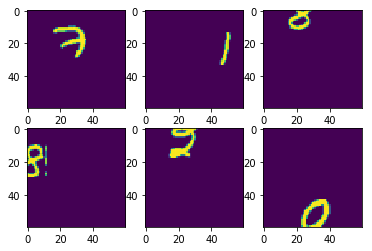

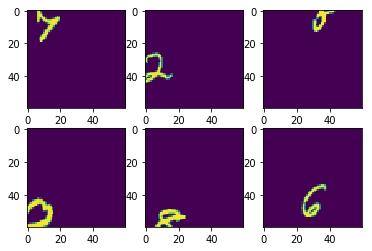

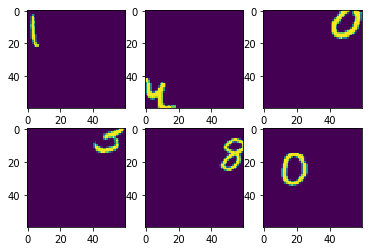

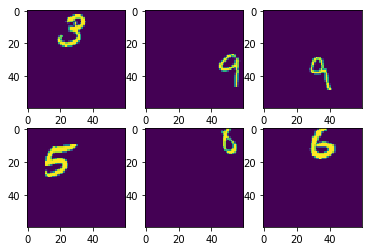

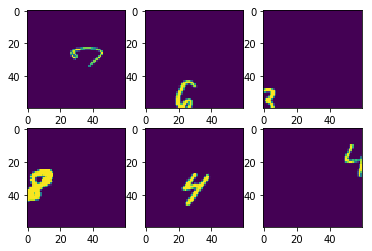

In [24]:
data_path = 'mnist_shifted_train_data.tfrecords'  # address to save the hdf5 file
with tf.Session() as sess:
    feature = {'train/image': tf.FixedLenFeature([], tf.string),
               'train/label': tf.FixedLenFeature([], tf.int64)}
   
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['train/image'], tf.float32)
    
    # Cast label data into int32
    label = tf.cast(features['train/label'], tf.int32)
    # Reshape image data into the original shape
    image = tf.reshape(image, (60,60))
    
    # Any preprocessing here ...
    
    # Creates batches by randomly shuffling tensors
    images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)


# Initialize all global and local variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for batch_index in range(5):
        img, lbl = sess.run([images, labels])
        for j in range(6):
            plt.subplot(2, 3, j+1)
            plt.imshow(img[j, ...])
        plt.show()
    # Stop the threads
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)
    sess.close()

## Reading of Test Data

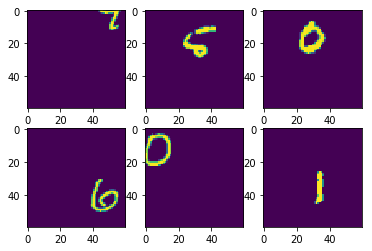

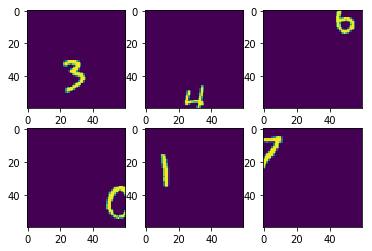

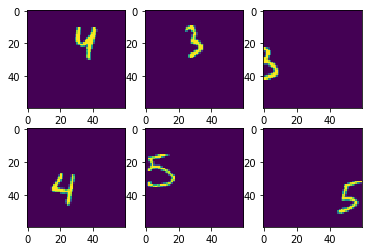

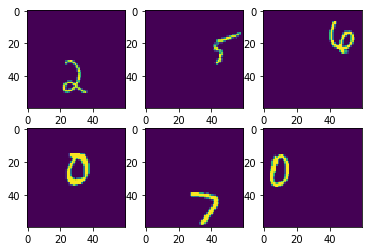

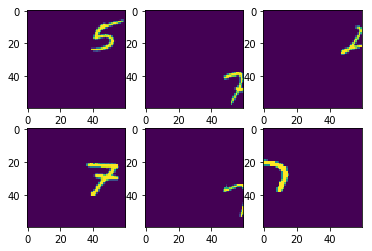

In [25]:
data_path = 'mnist_cluttered_test_data.tfrecords'  # address to save the hdf5 file


with tf.Session() as sess:
    feature = {'test/image': tf.FixedLenFeature([], tf.string),
               'test/label': tf.FixedLenFeature([], tf.int64)}
   
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['test/image'], tf.float32)
    
    # Cast label data into int32
    label = tf.cast(features['test/label'], tf.int32)
    # Reshape image data into the original shape
    image = tf.reshape(image, (60,60))
    
    # Any preprocessing here ...
    
    # Creates batches by randomly shuffling tensors
    images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)


# Initialize all global and local variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for batch_index in range(5):
        img, lbl = sess.run([images, labels])
        for j in range(6):
            plt.subplot(2, 3, j+1)
            plt.imshow(img[j, ...])
        plt.show()
    # Stop the threads
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)
    sess.close()